In [263]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams['figure.dpi'] = 300
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)
plt.rc('legend',fontsize=20)
plt.rc('text', usetex=True)

In [304]:
from platform import python_version

print(python_version())

3.8.12


In [63]:
markers = ["o","D","<","p",">","v","*","^"]

In [2]:
import numpy as np
import random
import time

#Generate a lattice of size L*L with random spin configuration
#Generate random float from 0 to 1, then minus 0.5, then take the sign
def lattice(L):
    Config = np.zeros((L,L), dtype=int)
    for i in range(L):
        for j in range(L):
            Config[i,j] = np.sign(np.random.rand()-0.5)
    return Config

### 1.2 Physics Observables

In this section, we are going to construct model for the expected value of magnetization, specific heat and susceptibility of the system.
The magnetization is defined as the sum of the magnetization of each configuration divided by the size of the lattice.

The energy of the whole lattice $E$ is given by the sum of the interactions of the spins with their nearest neighbors.

In [3]:
#Calculate the energy of the configuration
def Energy(Config,L):
    E = 0
    for i in range(L):
        for j in range(L):
            S1 = Config[i,j]
            S2 = Config[(i+1)%L, j] + Config[i,(j+1)%L] + Config[(i-1)%L,j] + Config[i,(j-1)%L]
            E += -S1*S2 
    return E

The magnetization of the lattice $m$ is defined as the sum of spins divided by the dimension of the lattice $N$.

In [4]:
#Calculate the magnetization of the configuration
def Magnetization(Config,L):
    m = np.sum(Config)/(L*L)
    return m

On the other hand, the value of specific heat $C$ is defined as the expected value of square of energy $E$ minus the square of the expected value of $E$ divided by the multiplication of $N$ and square of temperature $T$, where $N$ is the size of the lattice. 

In [5]:
#Calculate the specific heat of the expected value of energy
def Specific_Heat(E_list,L,T):
    return (np.mean([i**2 for i in E_list])-np.mean(E_list)**2)/((T*L)**2)

Similarly, the susceptibility $\chi$ is given by the sum of the configurations divided by the multiplication of $N$ and temperature $T$, where $N$ is the size of the lattice.

In [6]:
#Calculate the Susceptibility of the sum of spin in a configuration
def Susceptibility(M_list,N,T):
    return (np.mean([i**2 for i in M_list])-np.mean([abs(i) for i in M_list])**2)/(N*T)

In [7]:
from numba import jit
@jit
def Correlation(Config,L):
    result=np.zeros(L,dtype=np.int32)

    for i in range(L):
        for j in range(L):
            for r in range(L):
                result[r] += Config[i,j] * ( Config[(i+r)%L, j] + Config[i,(j+r)%L] + Config[(i-r)%L,j] + Config[i,(j-r)%L] )
                
    return (result/(4*L**2))

## 1.3 Monte Carlo Simulation

In the section, we perform the Metropolis algorithm for the Monte Carlo Simulation. 
The first step is to set up the lattice which we did in the first section. The second step is to randomly select a spin and perform the flip to observe the change in energy dE due to the flip and the probability. To flip the spin, we multiply $-1$ to the spin. If the change in energy is smaller than zero, we accept the flip. Otherwise, if the probability is equals to the exponential function of $-dE$ divided by the temperature, we accept the flip.

In [8]:
#The Metropolis algorithm for Monte Carlo simulation
@jit
def Metropolis(Config,L,T):
    for a in range(L):
        for b in range(L):
                i = np.random.randint(0, L)
                j = np.random.randint(0, L)
                S1 = Config[i,j]
                S2 = Config[(i+1)%L, j] + Config[i,(j+1)%L] + Config[(i-1)%L,j] + Config[i,(j-1)%L]
                dE = 2*S1*S2
                # if P_accept(C_i -> C_j) > 1, i.e. W(C_j)>W(C_i)
                if dE < 0:
                    S1 *= -1
                # if P_accept(C_i -> C_j) < 1 & r < P_accept(C_i -> C_j)
                elif np.random.rand() < np.exp(-dE/T):
                    S1 *= -1
                Config[i, j] = S1
                
    return Config

Cluster algorithm

In [9]:
@jit(nopython=True)
def SwendsenWang(Config,L,T):
    bprob = 1 - np.exp(-2/T)
    #generate bond configuration
    bond = np.full((2,L,L), False)
    for i in range(L):
        for j in range(L):
            if Config[i,j] == Config[(i+1)%L,j]:
                if np.random.rand() < bprob: #correct to 1 - np.exp(-2/T) later
                    bond[0,i,j] = True
            if Config[i,j] == Config[i,(j+1)%L]:
                if np.random.rand() < bprob: #correct to 1 - np.exp(-2/T) later
                    bond[1,i,j] = True
    #print("bond:")
    #print(bond)
    #cluster search procedure
    notvisited = np.full((L,L), True)
    for i in range(L):
        for j in range(L):
            if notvisited[i,j]:
                #print("new cluster")
                cseed = Config[i,j]
                #print(f"cseed = [{i},{j}]")
                if np.random.rand() < 0.5: #corrrect to 0.5 later
                    flipclus = True
                    Config[i,j] *= -1
                    #rint(f"flip [{i},{j}]")
                else:
                    flipclus = False
                notvisited[i,j] = False
                    
                stack = np.empty((L*L,2), dtype=np.int32)
                stack[0] = np.array([i,j])
                nstack = 1
                #print("notvisited:")
                #print(notvisited)
                while nstack > 0:
                    a,b = stack[nstack-1]
                    s0 = Config[a,b]
                    #print(f"s0=[{a},{b}]")
                    nstack -= 1
                    
                    #down
                    if bond[0,a,b] and notvisited[(a+1)%L,b]:
                        notvisited[(a+1)%L,b] = False
                        if flipclus:
                            Config[(a+1)%L,b] *= -1
                        nstack += 1
                        stack[nstack-1] = [(a+1)%L,b]
                        #print(f"connect down: {stack[nstack-1]}")
                        #print(nstack)
                    #right
                    if bond[1,a,b] and notvisited[a,(b+1)%L]:
                        notvisited[a,(b+1)%L] = False
                        if flipclus:
                            Config[a,(b+1)%L] *= -1
                        nstack +=1
                        stack[nstack-1] = [a,(b+1)%L]
                        #print(f"connect right: {stack[nstack-1]}")
                        #print(nstack)
                        
                    
                    #print(f"notvisited[{(a-1)%L},{b}] = {notvisited[(a-1)%L,b]}")
                    #up    
                    if bond[0,(a-1)%L,b] and notvisited[(a-1)%L,b]:
                        notvisited[(a-1)%L,b] = False
                        if flipclus:
                            Config[(a-1)%L,b] *= -1
                        nstack +=1
                        stack[nstack-1] = [(a-1)%L,b]
                        #print(f"connect up: {stack[nstack-1]}")
                        #print(nstack)
                        
                    #left
                    if bond[1,a,(b-1)%L] and notvisited[a,(b-1)%L]:
                        notvisited[a,(b-1)%L] = False
                        if flipclus:
                            Config[a,(b-1)%L] *= -1
                        nstack +=1
                        stack[nstack-1] = [a,(b-1)%L]
                        #print(f"connect left: {stack[nstack-1]}")
                        #print(nstack)

    return Config

In [10]:
#Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#Cost function
def computeCost(theta,X,y):
    
    m = float(len(y))
    
    predictions = sigmoid(X.dot(theta))
    cost = -(1/m) * (y.T.dot(np.log(predictions))+(1-y).T.dot(np.log(1-predictions)))
    return cost

In [11]:
#logistic regression
def LogisticRegression(T,x,L):
    
    #prepare data
    y = []
    #decision boundary
    for i in x:
        if i>=0.5:
            y.append(1)
        else:
            y.append(0)

    alpha =0.01
    iterations =100000

    
    T_b = np.c_[np.ones((len(T),1)),T]
    theta = np.zeros((T_b.shape[1],1))
    y = np.array(y)
    y = y.reshape((len(y),1))

    
    #gradient descent
    m = float(y.shape[0])
    cost_history = np.zeros(iterations)
    theta_history = np.zeros((iterations,T_b.shape[1]))
    for i in range(iterations):
        prediction = sigmoid(T_b.dot(theta))
        theta = theta -(1/m)*alpha*(T_b.T.dot((prediction - y)))
        theta_history[i,:] = theta.T
        cost_history[i]  = computeCost(theta,T_b,y)   
    
    print('Cost history of L =',L,':\n',cost_history)
    #Determine the Ising phase transition point
    T_c = -(theta[0][0]/theta[1][0])
    print(f'T_c for L = {L} is {T_c}')
    return T_c

In [12]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [13]:
from scipy.sparse.linalg import cg
def ConjugateDescent(x, y):
    X = x.reshape((-1, 1))
    y = y.reshape((-1, 1))
    X_b = np.c_[np.ones((len(X),1)),X]

    theta = np.zeros((2,1))

    A = X_b.T @ X_b
    b = (X_b.T @ y)+ np.linalg.pinv(theta.T) @ y.T @ X_b @ theta
    c = y.T @ y

    intercept, slope = cg(A,b)[0]
    
    return [intercept, slope]

In [14]:
# Autocorrelation functions
def computeAutocorrelation(Q_list,taunum,knum):
    A_list_tau = []
    A_std_tau = []
    #print(f"Q list = {Q_list}")
    for tau in range(taunum):
        product = []
        Q_list_k = []
        Q_list_k_square = []
        A_bin_k = []
        
        for k in range(knum-tau):
            product.append(Q_list[k]*Q_list[k+tau])
            Q_list_k.append(Q_list[k])
            Q_list_k_square.append(Q_list[k]**2)
            if k%(knum/10) == 0 and k !=0:
                A_list_k = (np.mean(product)-np.mean(Q_list_k)**2)/(np.mean(Q_list_k_square)-np.mean(Q_list_k)**2)
                A_bin_k.append(A_list_k)
                product=[]
                Q_list_k=[]
                Q_list_k_square=[]
                
        A_list_tau.append(np.mean(A_bin_k))
        A_std_tau.append(np.std(A_bin_k))

        if A_list_tau[-1] <=0.01:
            A_list_tau.extend([np.nan]*(taunum-len(A_list_tau)))
            A_std_tau.extend([np.nan]*(taunum-len(A_std_tau)))
            break

    return A_list_tau, A_std_tau

In [15]:
def power_law(x, a, b):
    return a*np.power(x, b)

In [16]:
#Cost function for conjugate descent
def findcost(X,theta,y):                    
    J = 0.5*np.matmul(((X.dot(theta)-y).T),(X.dot(theta)-y))
    return J

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

def Q1(algorithm,L_list, Mcstep, t1, taunum):
    Equstep=1000
    A_M_abs_L=[]
    A_M_abs_std_L=[]
    for L in L_list:
        #print("L = " + str(L))
        #record start time of the loop
        #start_time = time.time()
        #size of the configuration
        N = L*L

        init_state = lattice(L)
        if algorithm == "M":
            for j in range(Equstep):
                MC = Metropolis(init_state,L,t1)
            M_abs_list = []
            for k in range(Mcstep):
                MC = Metropolis(init_state,L,t1)
                M_abs_list.append(abs(np.sum(MC)/N))
        
        elif algorithm == "SW":   
            for j in range(Equstep):
                MC = SwendsenWang(init_state,L,t1)
            M_abs_list = []
            for k in range(Mcstep):
                MC = SwendsenWang(init_state,L,t1)
                M_abs_list.append(abs(np.sum(MC)/N))
                
            #check progress
            #if (k+1)%1000 == 0 and k!=0:
                #print(str(k+1)+" k points finished")
        #autocorrelation function of |M| at certain temperature
        A_M_abs_tau, A_M_abs_std_tau = computeAutocorrelation(M_abs_list,taunum,Mcstep)
        A_M_abs_L.append(A_M_abs_tau)
        A_M_abs_std_L.append(A_M_abs_std_tau)
    
        #time used for the loop for each L
        #print("computing time for L="+str(L)+": %s seconds" % (time.time() - start_time))    
    plt.figure(figsize=(10,6), dpi=300)
    for i in range(len(L_list)):
        plt.errorbar(list(range(taunum)), A_M_abs_L[i], A_M_abs_std_L[i], fmt=markers[i], markersize=3,label="L="+str(L_list[i]))
    plt.xlabel(r"$\tau$ [MC steps]", fontsize=25) 
    plt.ylabel(r"$A_{|M|}(\tau)$", fontsize=25)
    if algorithm == "M":
        #plt.title(f"Autocorrelation function at T = {round(t1,2)} of Metropolis algorithm", fontsize=25)
        plt.yscale("log")
        plt.legend()
        plt.savefig('/Users/johnngan/Desktop/PHYS3999/images/autocorr_M.pdf', bbox_inches='tight')
        plt.show()
    if algorithm =="SW":
        #plt.title(f"Autocorrelation function at T = {round(t1,2)} of Swendsen-Wang algorithm", fontsize=25)
        plt.yscale("log")
        plt.legend()
        plt.savefig('/Users/johnngan/Desktop/PHYS3999/images/autocorr_SW.pdf', bbox_inches='tight')
        plt.show()
    return A_M_abs_L, A_M_abs_std_L

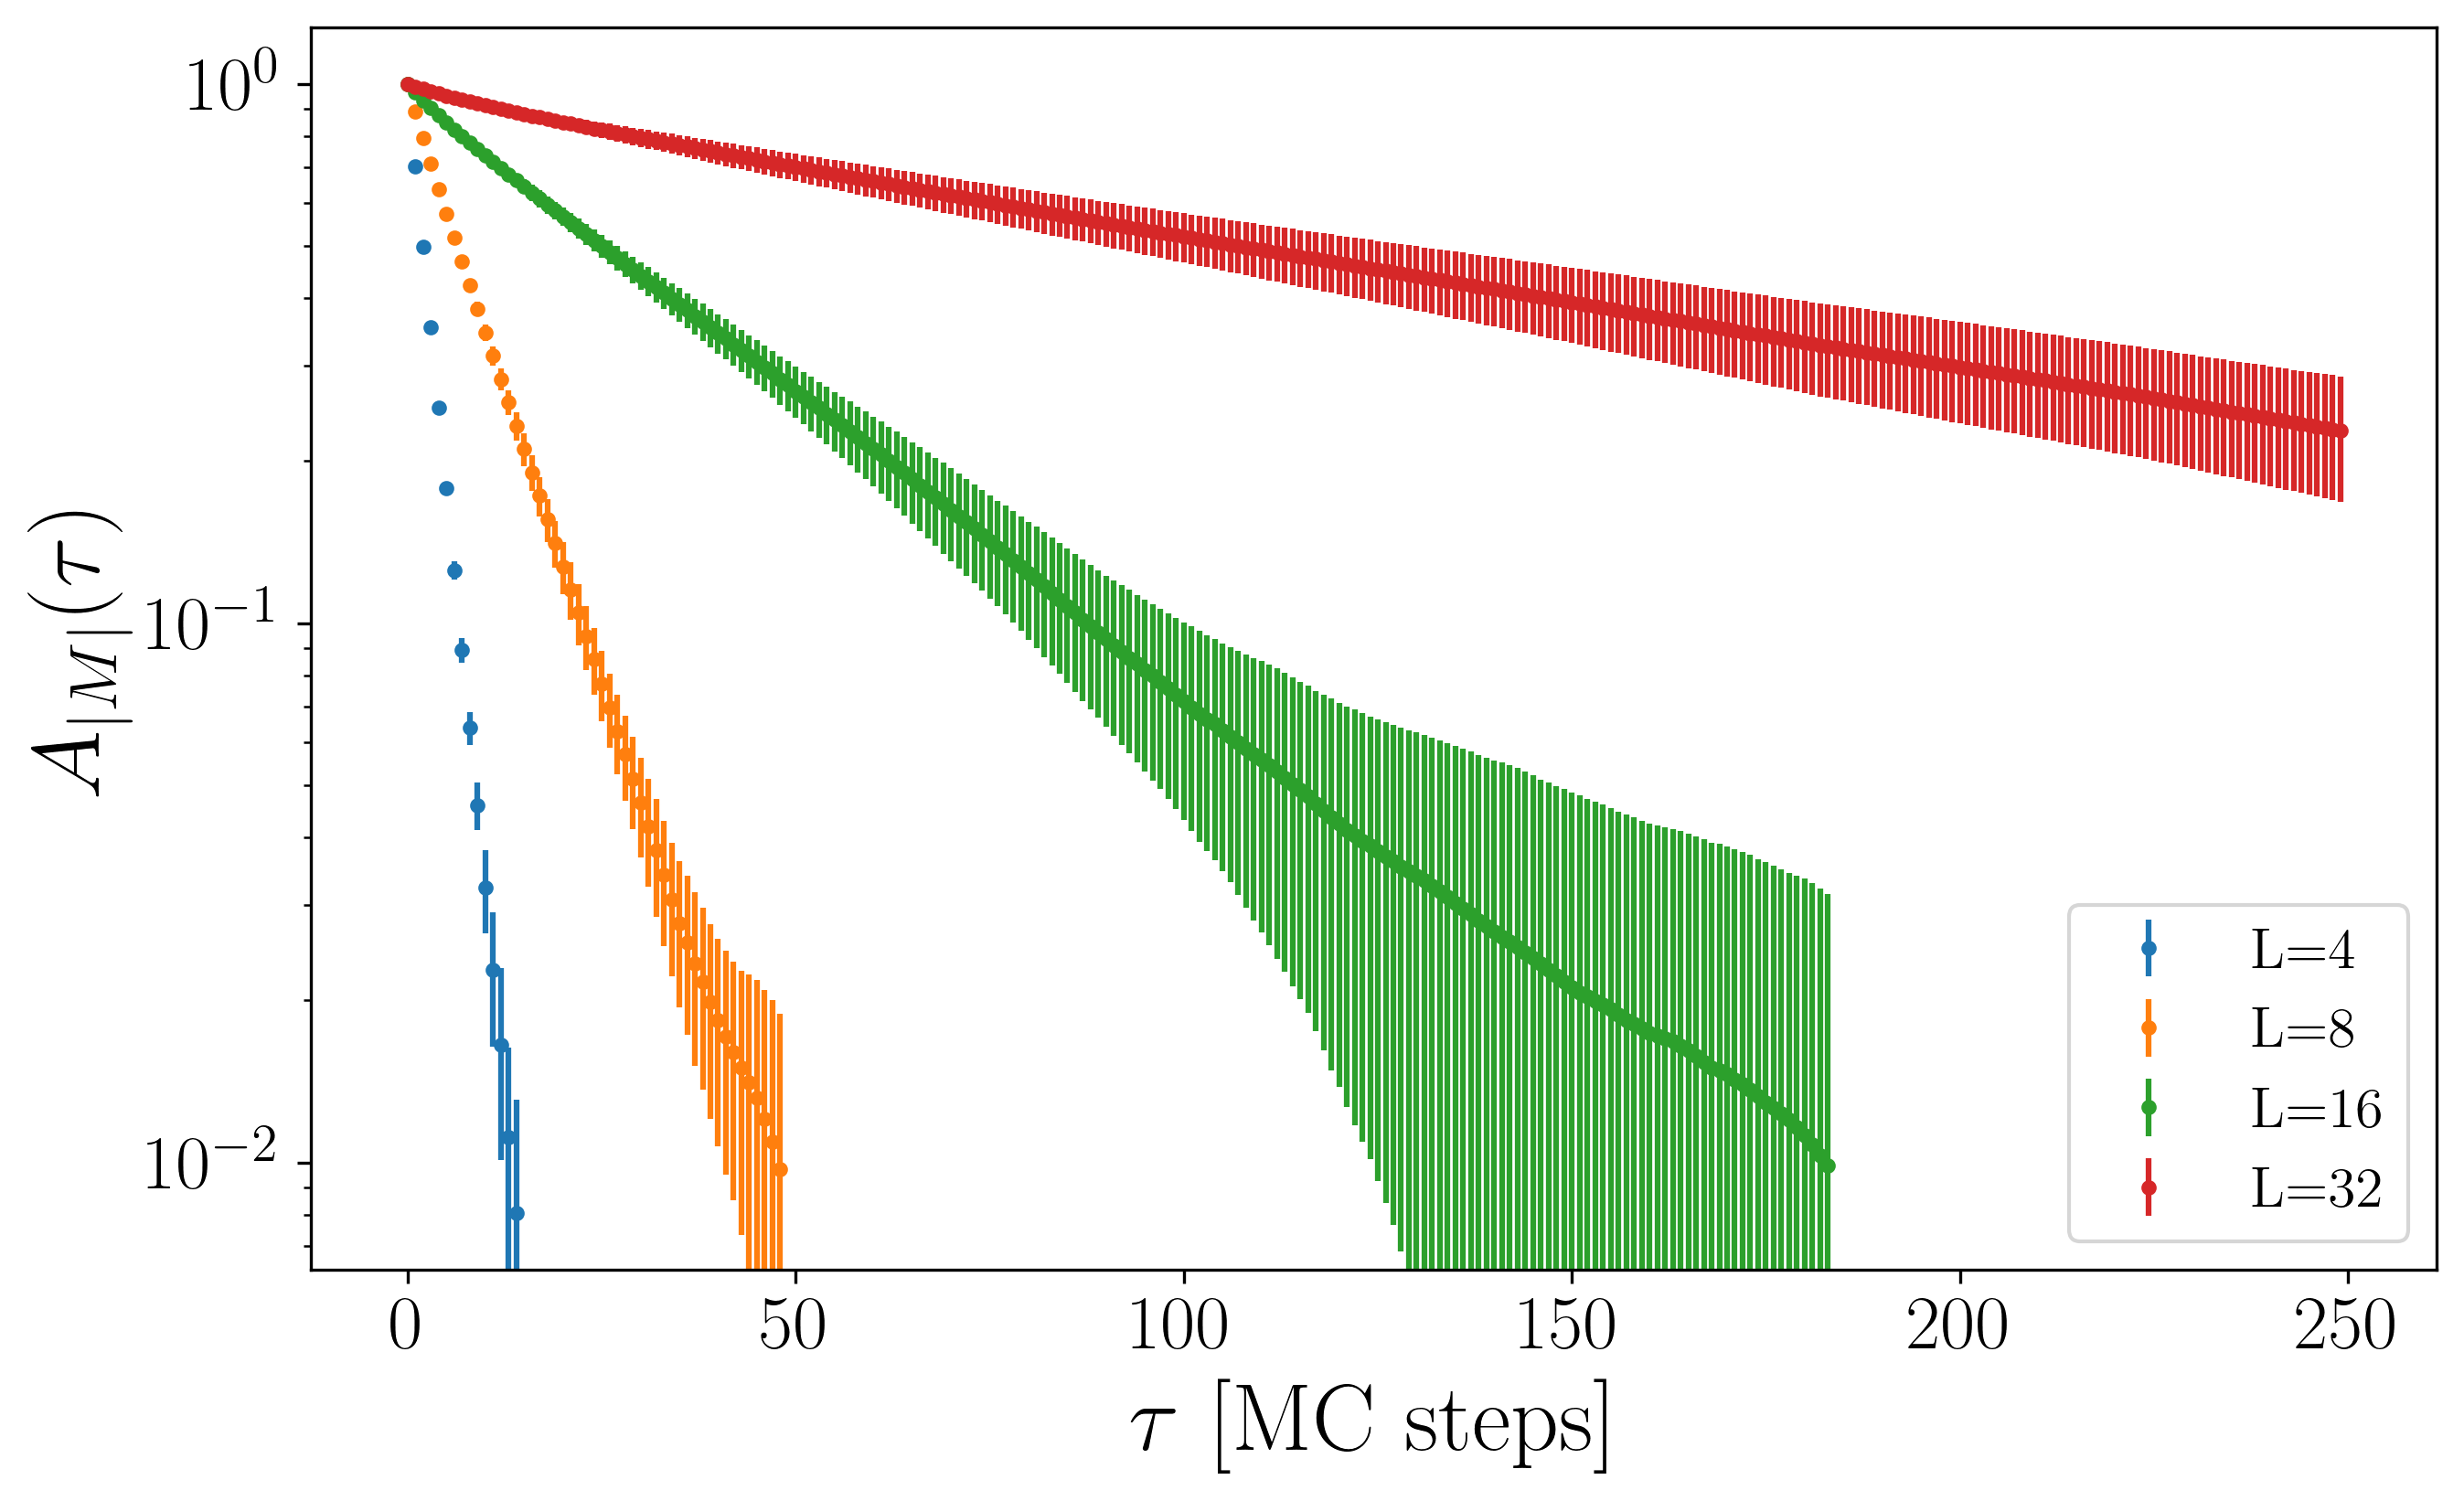

In [165]:
AML_M, AMS_M = Q1(
    algorithm = "M",
    L_list=[4,8,16,32],
    Mcstep=1000000,
    t1=2.269,
    taunum=250,
    )

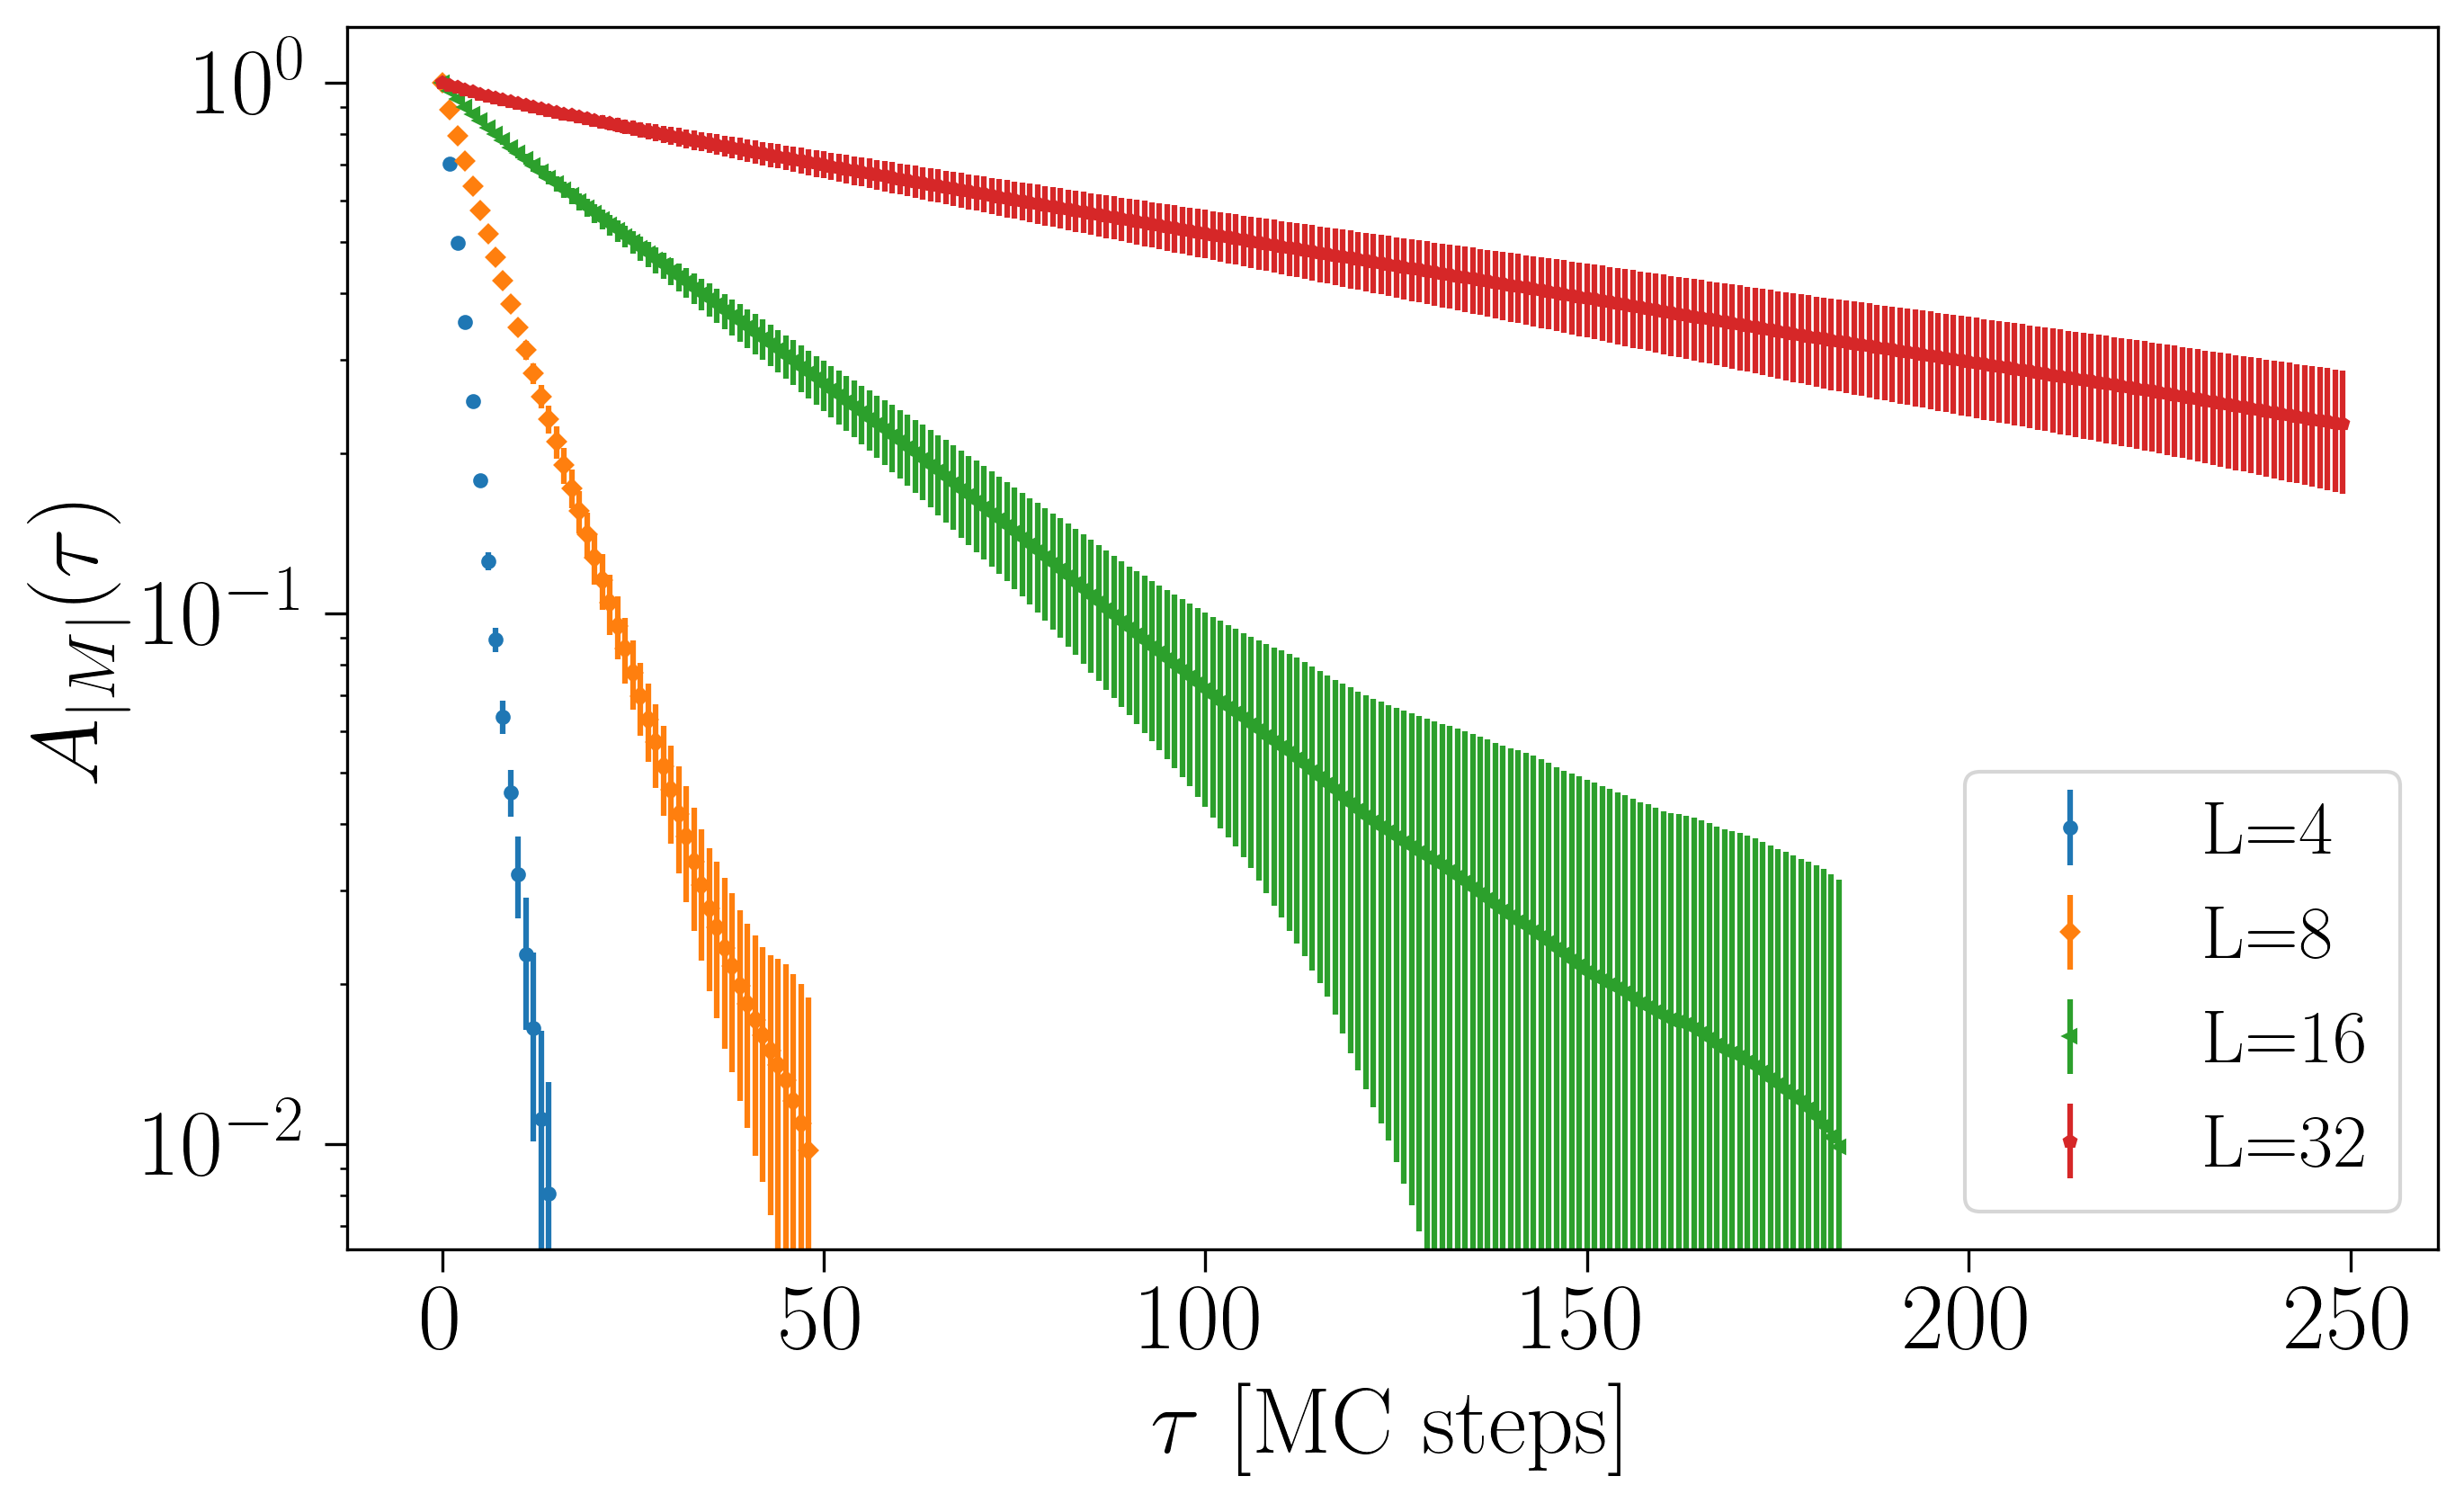

In [264]:
taunum=250
plt.figure(figsize=(10,6), dpi=300)
for i in range(len(L_list)):
    plt.errorbar(list(range(taunum)), AML_M[i], AMS_M[i], fmt=markers[i],markersize=3,label="L="+str(L_list[i]))
plt.xlabel(r"$\tau$ [MC steps]", fontsize=25) 
plt.ylabel(r"$A_{|M|}(\tau)$", fontsize=25)

#plt.title(f"Autocorrelation function at T = {round(t1,2)} of Metropolis algorithm", fontsize=25)
plt.yscale("log")
plt.legend()
plt.savefig('/Users/johnngan/Desktop/PHYS3999/images/autocorr_M.pdf', bbox_inches='tight')
plt.show()

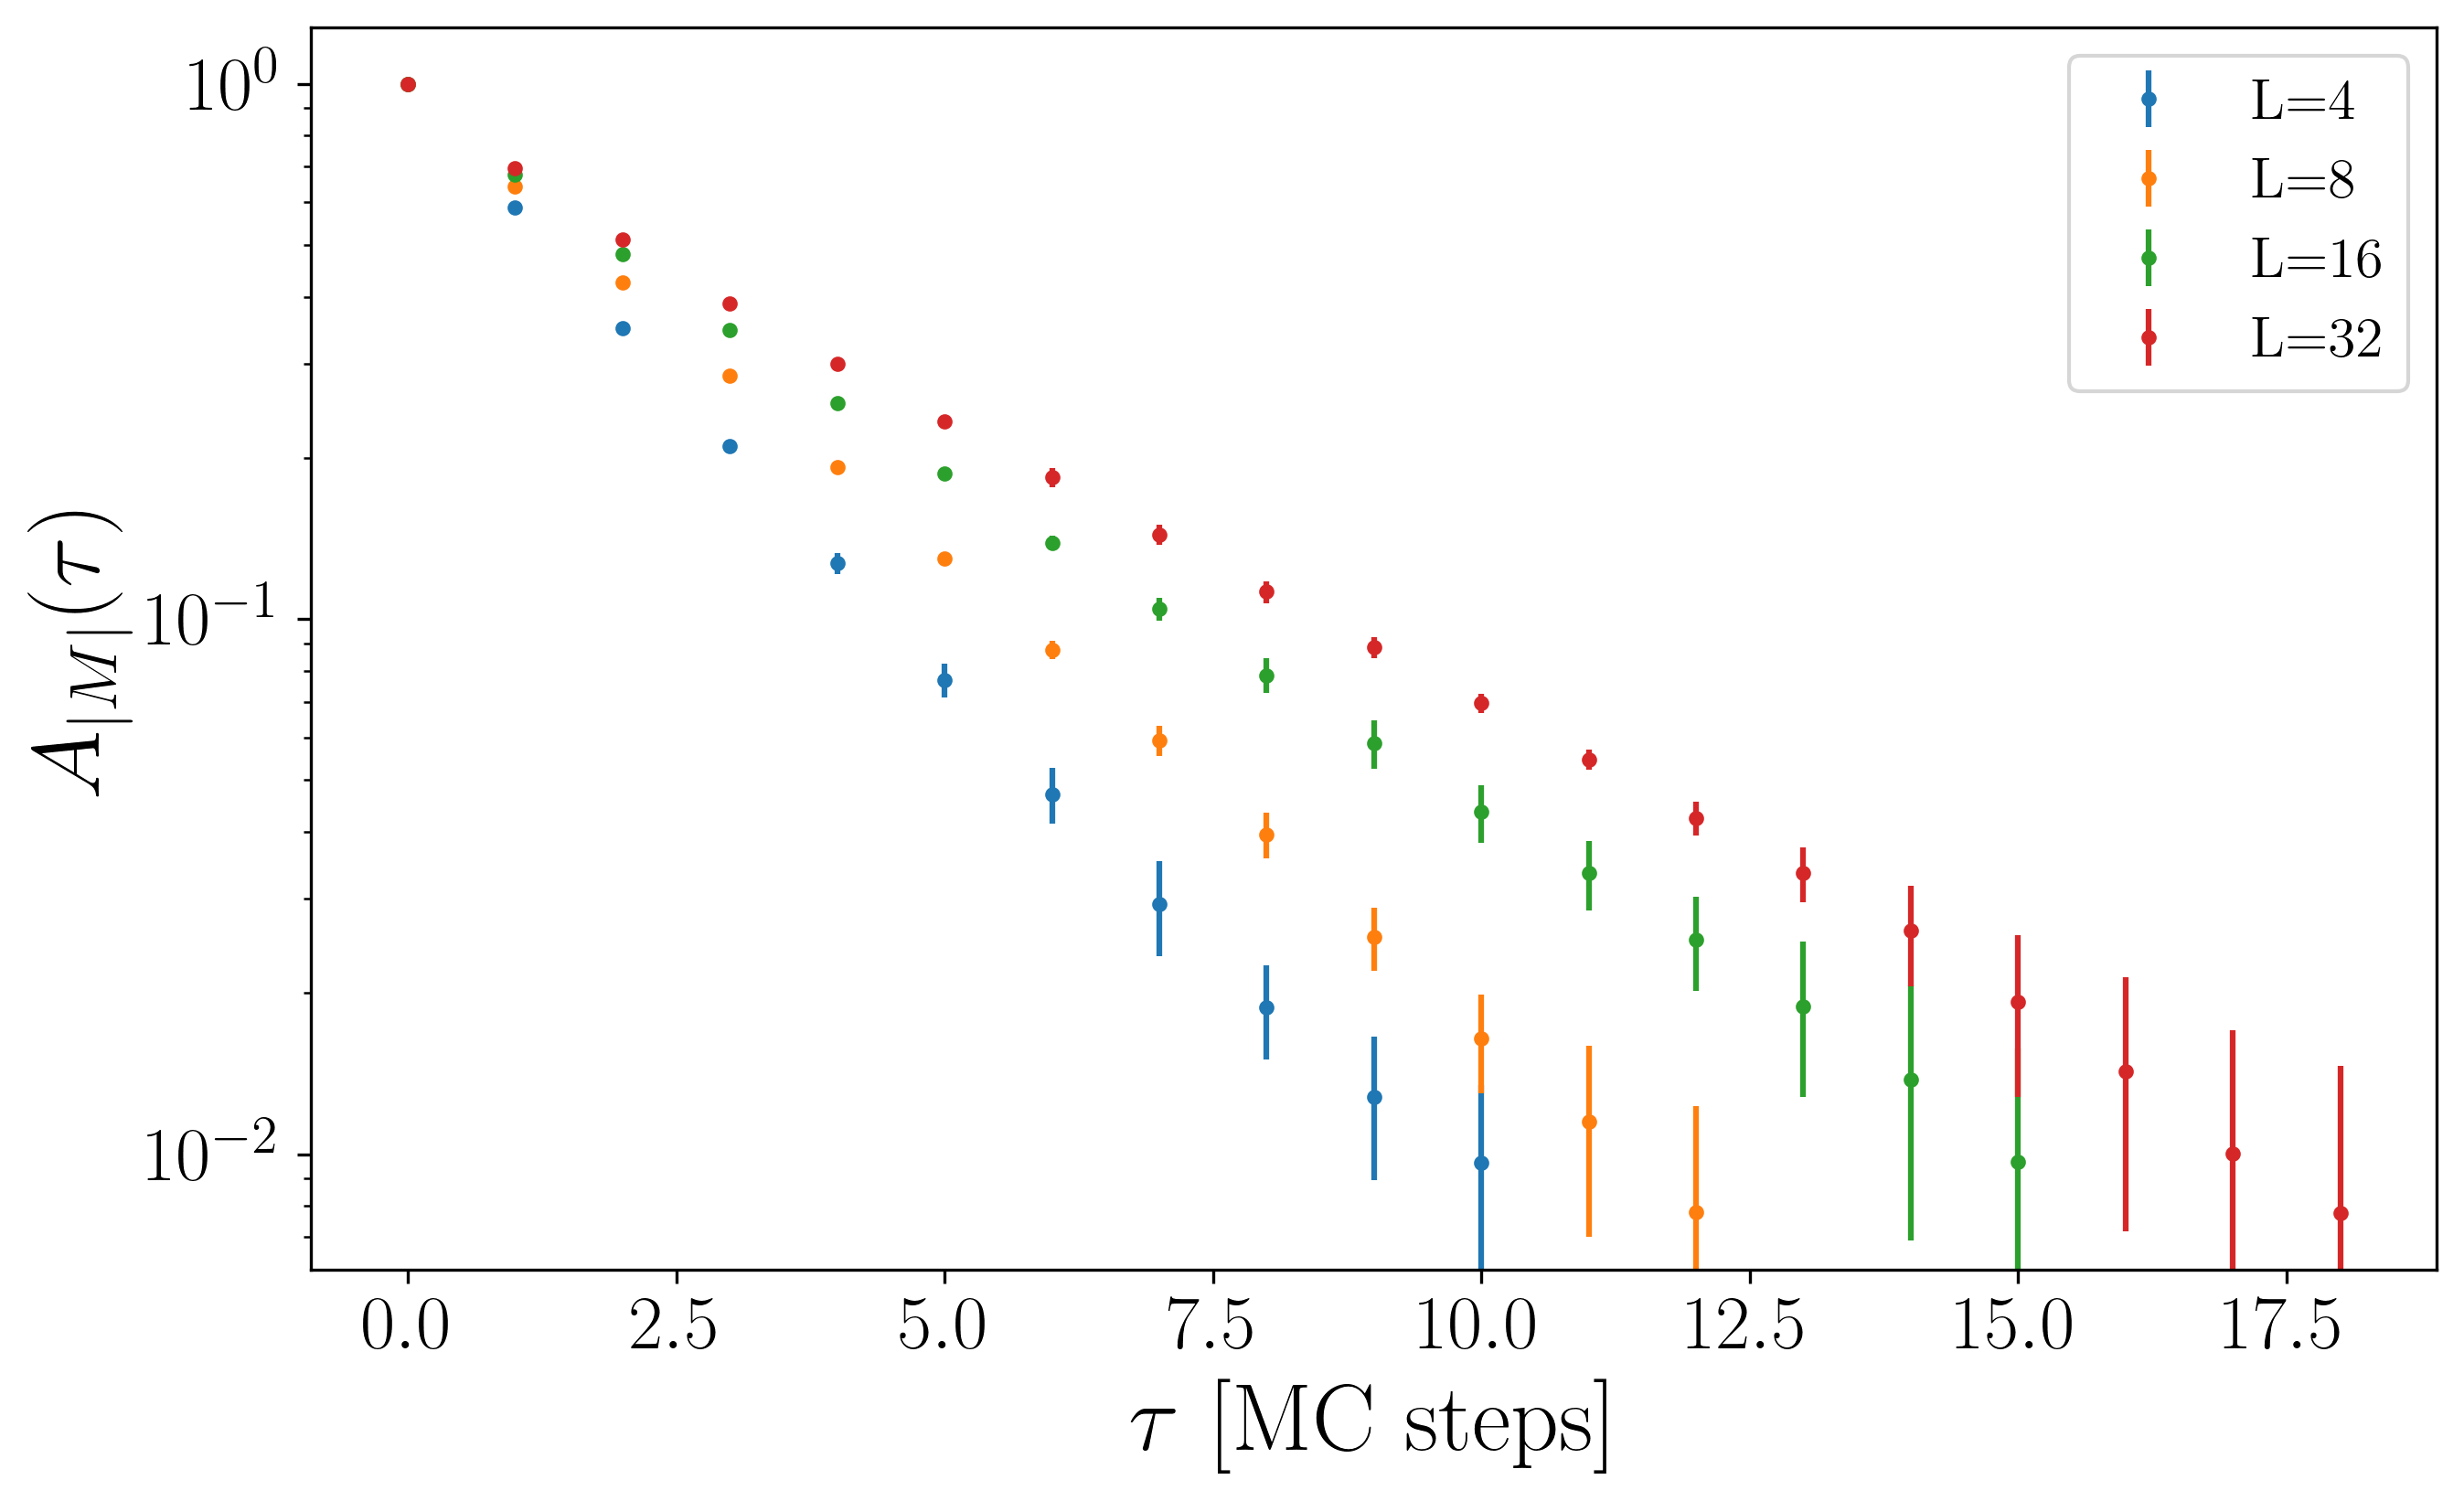

In [166]:
AML_SW, AMS_SW = Q1(
    algorithm = "SW",
    L_list=[4,8,16,32],
    Mcstep=1000000,
    t1=2.269,
    taunum=250,
    )

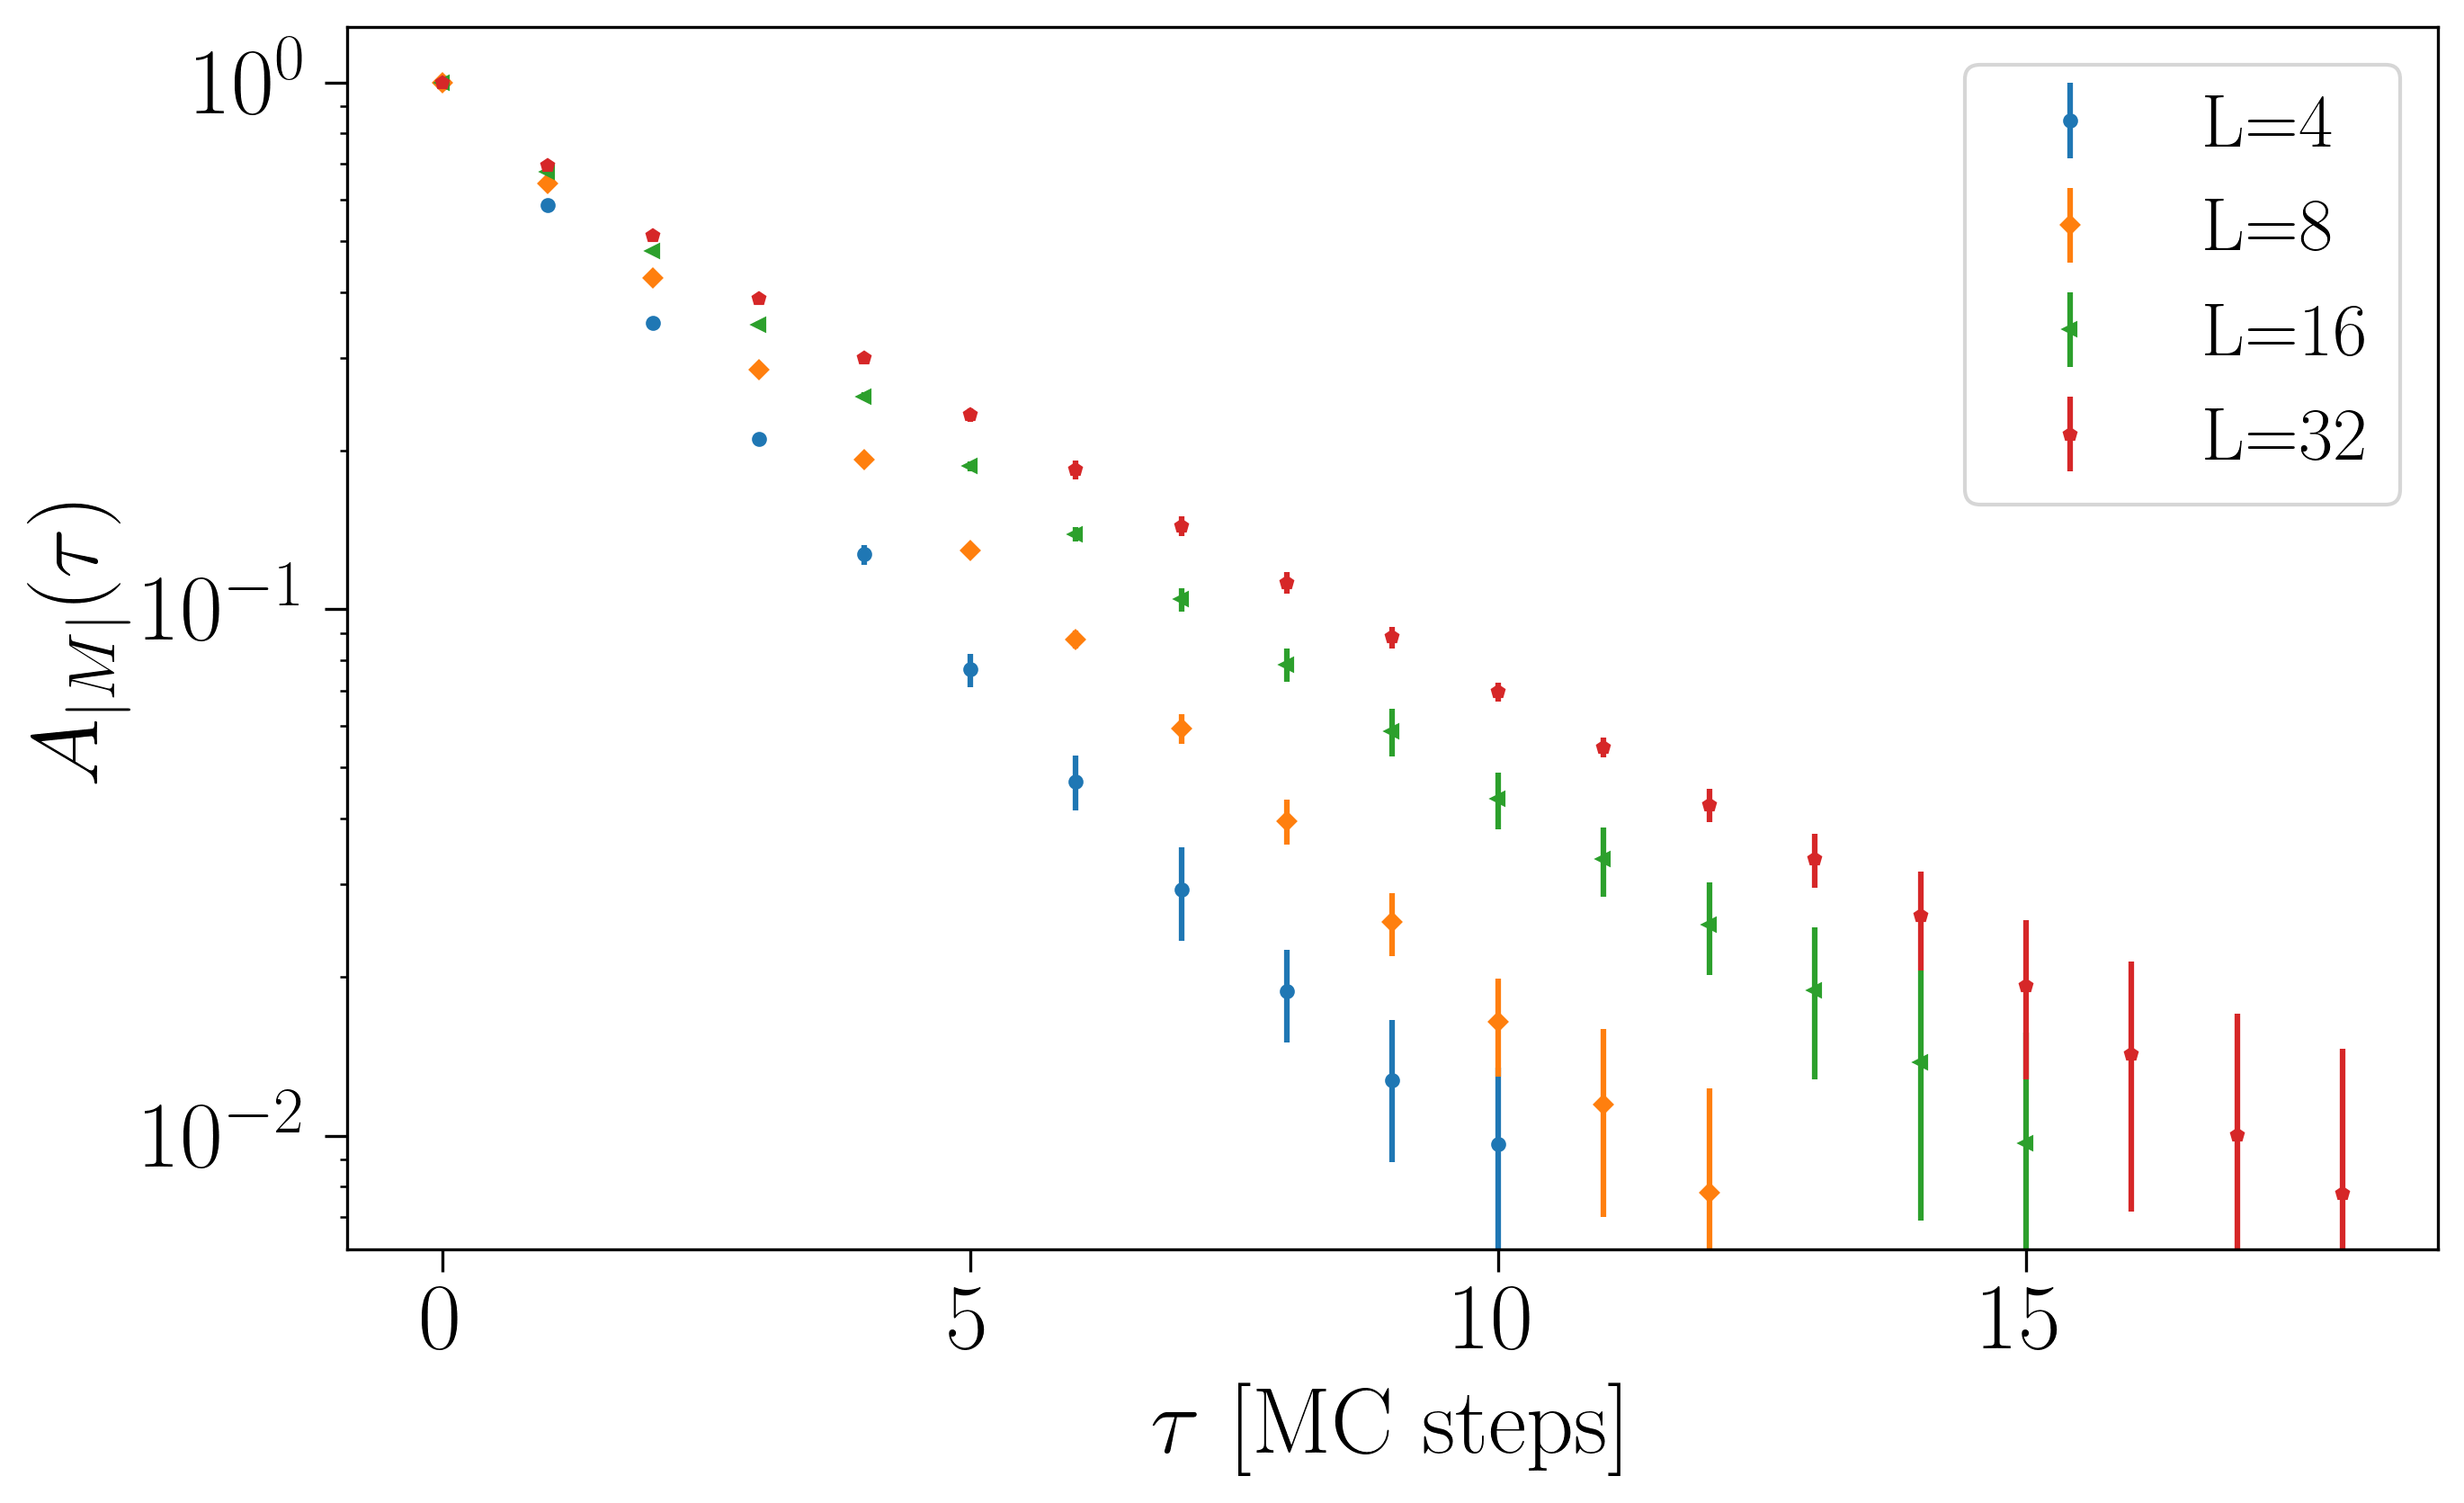

In [265]:
plt.figure(figsize=(10,6), dpi=300)
for i in range(len(L_list)):
    plt.errorbar(list(range(taunum)), AML_SW[i], AMS_SW[i], fmt=markers[i], markersize=3,label="L="+str(L_list[i]))
plt.xlabel(r"$\tau$ [MC steps]", fontsize=25) 
plt.ylabel(r"$A_{|M|}(\tau)$", fontsize=25)
#plt.title(f"Autocorrelation function at T = {round(t1,2)} of Swendsen-Wang algorithm", fontsize=25)
plt.yscale("log")
plt.legend()
plt.savefig('/Users/johnngan/Desktop/PHYS3999/images/autocorr_SW.pdf', bbox_inches='tight')
plt.show()

In [290]:
from scipy.optimize import curve_fit
def AutocorrelationTime(algorithm,A_M_abs_L,L_list):
    #Conjugate descent to find out the autocorrelation time
    autocorr_time_list=[]
    integrated_autocorr_time=[]
    AL_log_list=[]
    A_M_abs_L=np.array(A_M_abs_L)

    for i in range(len(A_M_abs_L)):
        AL=A_M_abs_L[i]
        integrated_autocorr_time.append(np.sum(AL[AL>0])-0.5)
        AL_log = np.log(AL[AL>0])
        AL_log_list.append(AL_log)
        autocorr_time = -1 * ConjugateDescent(AL_log,np.arange(len(AL_log)))[1]
        autocorr_time_list.append(autocorr_time)
    print(f"autocorrelation time = {autocorr_time_list}")
    print(f"integrated autocorrelation time = {integrated_autocorr_time}")
    
    #fit autocorrelation time versus system size
    pars, cov = curve_fit(power_law, L_list[1:], autocorr_time_list[1:], p0=[0, 1])
    stdevs = np.sqrt(np.diag(cov))# Calculate the residuals
    res = autocorr_time_list - power_law(L_list, *pars)
    ss_tot = np.sum((autocorr_time_list-np.mean(autocorr_time_list))**2)
    ss_res = np.sum(residuals**2)

    r_squared = 1 - (ss_res / ss_tot)

    
    f = plt.figure(figsize=(10,12), dpi=300)  
    sp1 = f.add_subplot(2,1,1)
    for i in range(len(L_list)):
        y_cg = -autocorr_time_list[i]*AL_log_list[i]
        plt.plot(y_cg, AL_log_list[i],linestyle = 'dashed', label=f"L={L_list[i]}")
        plt.scatter(np.arange(len(AL_log_list[i])),AL_log_list[i],marker = markers[i],s=20,label=f"L={L_list[i]}")
    plt.title('Conjugate descent', fontsize=25)
    plt.ylabel(r"$\ln{A_{|M|}(\tau)}$", fontsize=25)
    plt.xlabel(r"$\tau$ [MC steps]", fontsize=25)
    plt.legend()
    plt.grid(True)
    if algorithm == "M":
        plt.savefig('/Users/johnngan/Desktop/PHYS3999/images/autocorr_LR_M.pdf', bbox_inches='tight')
    if algorithm == "SW":
        plt.savefig('/Users/johnngan/Desktop/PHYS3999/images/autocorr_LR_SW.pdf', bbox_inches='tight')
    plt.show()
    
    f = plt.figure(figsize=(10,12), dpi=300)
    sp2 = f.add_subplot(2,1,2)
    L = np.linspace(L_list[0],L_list[-1],100)
    plt.scatter(L_list,autocorr_time_list,s=20, marker = markers[0],label=r"$T = 2.27$")
    plt.plot(L,power_law(L, *pars),linestyle = 'dashed', label=fr"${round(pars[0],2)}L^{{{round(pars[1],2)}}}$(fit)")
    if algorithm == "M":
        plt.plot(L,power_law(L, pars[0], 2.2), label=fr"${round(pars[0],2)}L^{{{2.2}}}$")
        plt.title('Autocorrelation time versus system size of Metropolis Algorithm', fontsize=25)
        plt.yscale('log')
        plt.ylabel(r"$\Theta_{int}$", fontsize=25)
        plt.xlabel("L", fontsize=25)
        plt.xscale('log')
        plt.legend()
        plt.grid(True)
        plt.show()
    if algorithm == "SW":
        plt.title('Autocorrelation time versus system size of Swendsen-Wang Algorithm', fontsize=25)
        plt.ylabel(r"$\Theta_{int}$", fontsize=25)
        plt.xlabel("L", fontsize=25)
        plt.xscale('log')
        plt.legend()
        plt.grid(True)
        plt.show()
    return autocorr_time_list, pars

autocorrelation time = [2.9113510469500476, 10.288349111173112, 39.92267049643436, 173.44342097808823]
integrated autocorrelation time = [2.8996650888148836, 9.473935303534178, 37.10473266192113, 124.42817159582756]


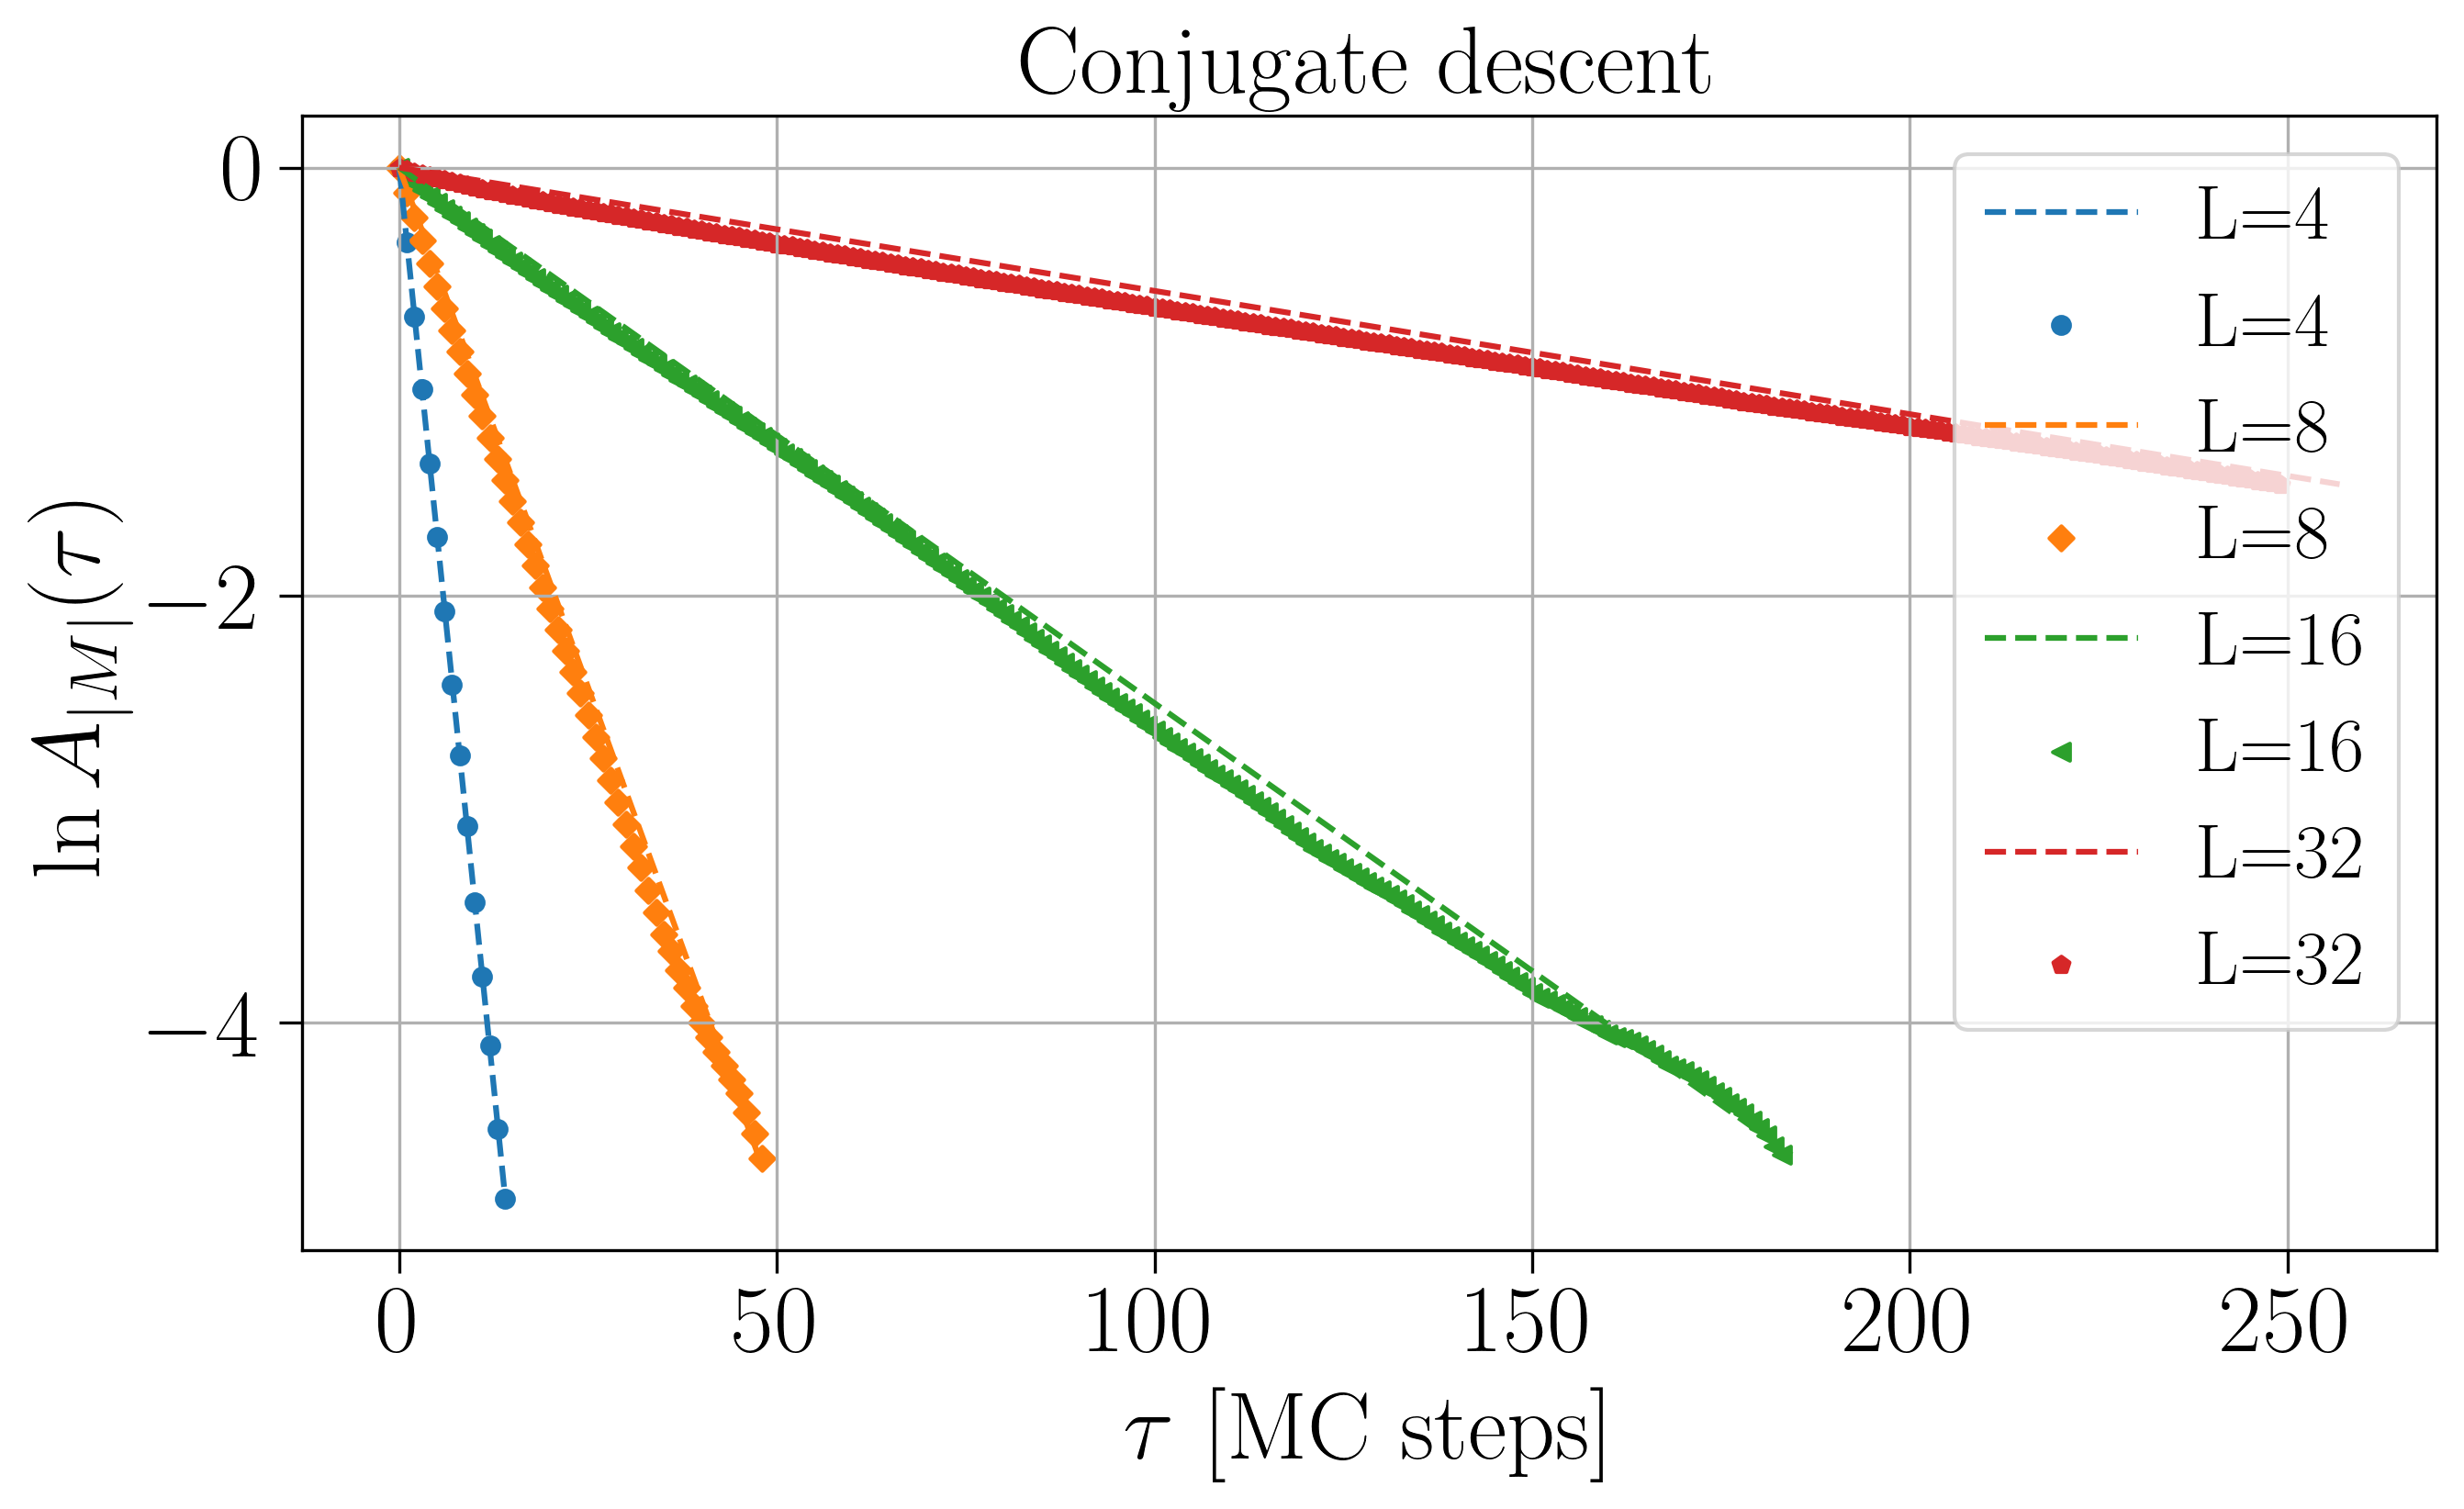

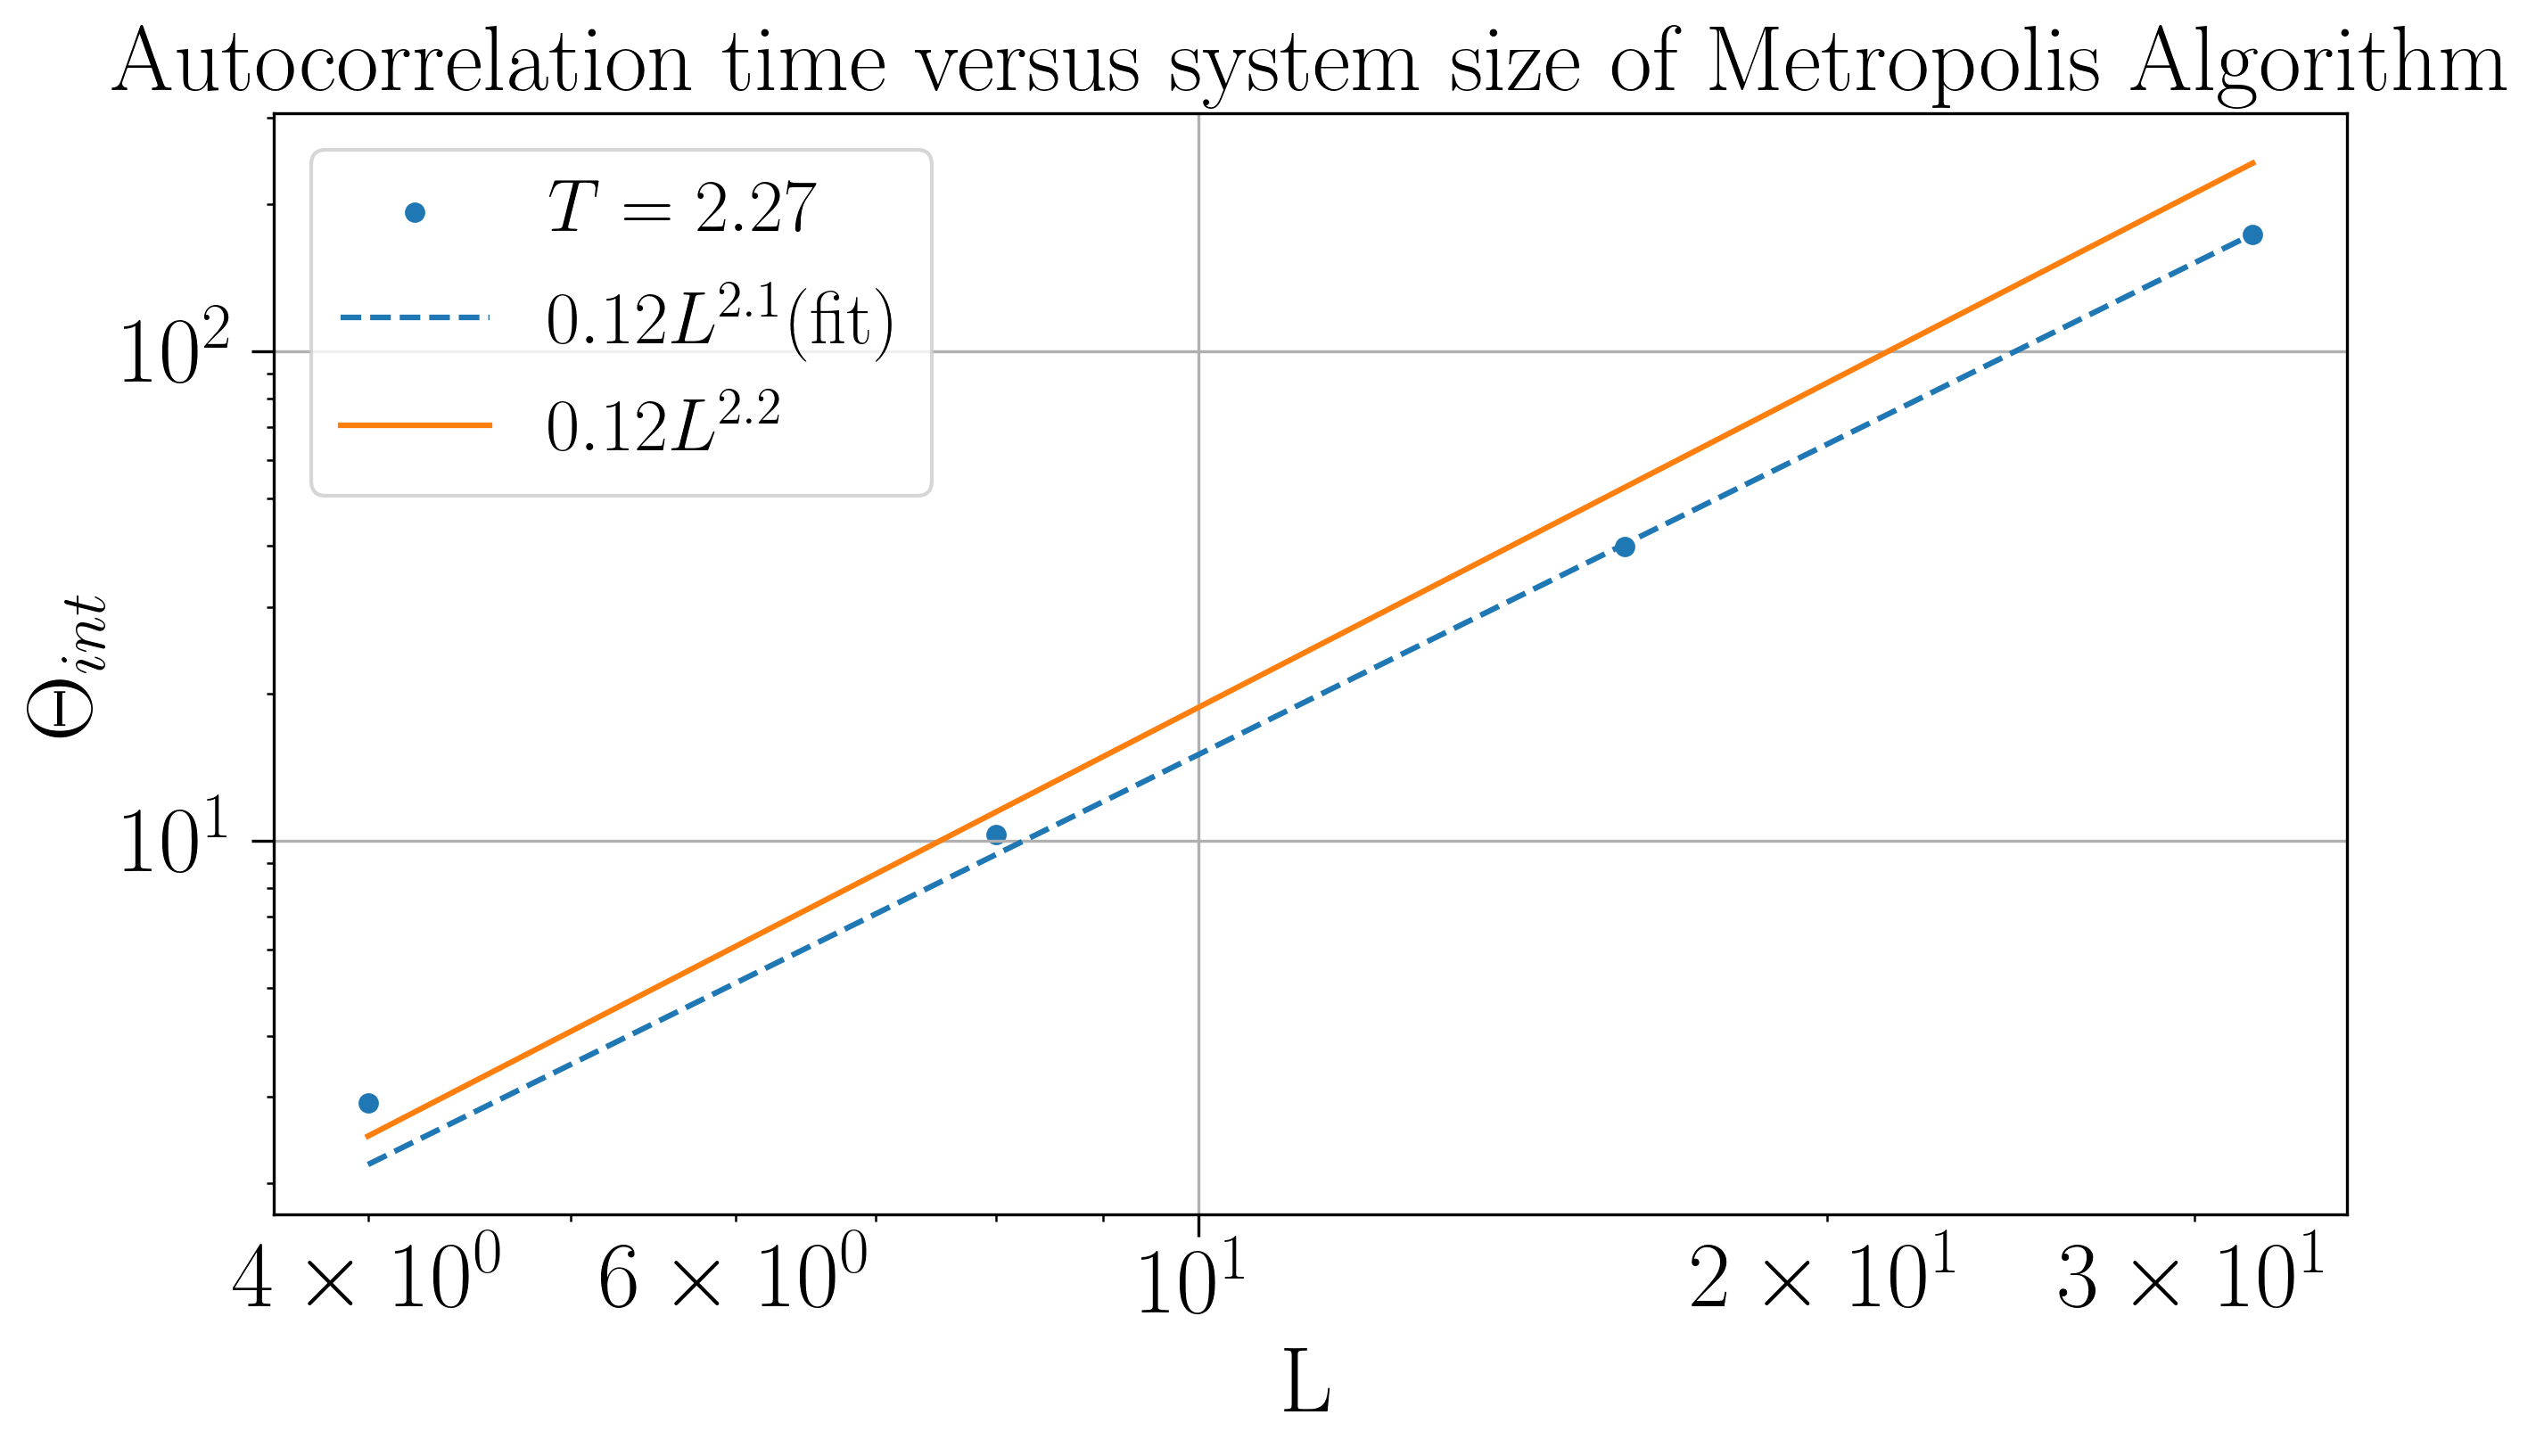

In [291]:
L_list=[4,8,16,32]
ATL_M, PARS_M = AutocorrelationTime("M",AML_M,L_list)

autocorrelation time = [2.098454683907502, 2.4769997490364726, 3.3341338891787906, 3.8576406780035075]
integrated autocorrelation time = [1.9667179445857386, 2.422602091040114, 2.9681916928847416, 3.435122676624552]


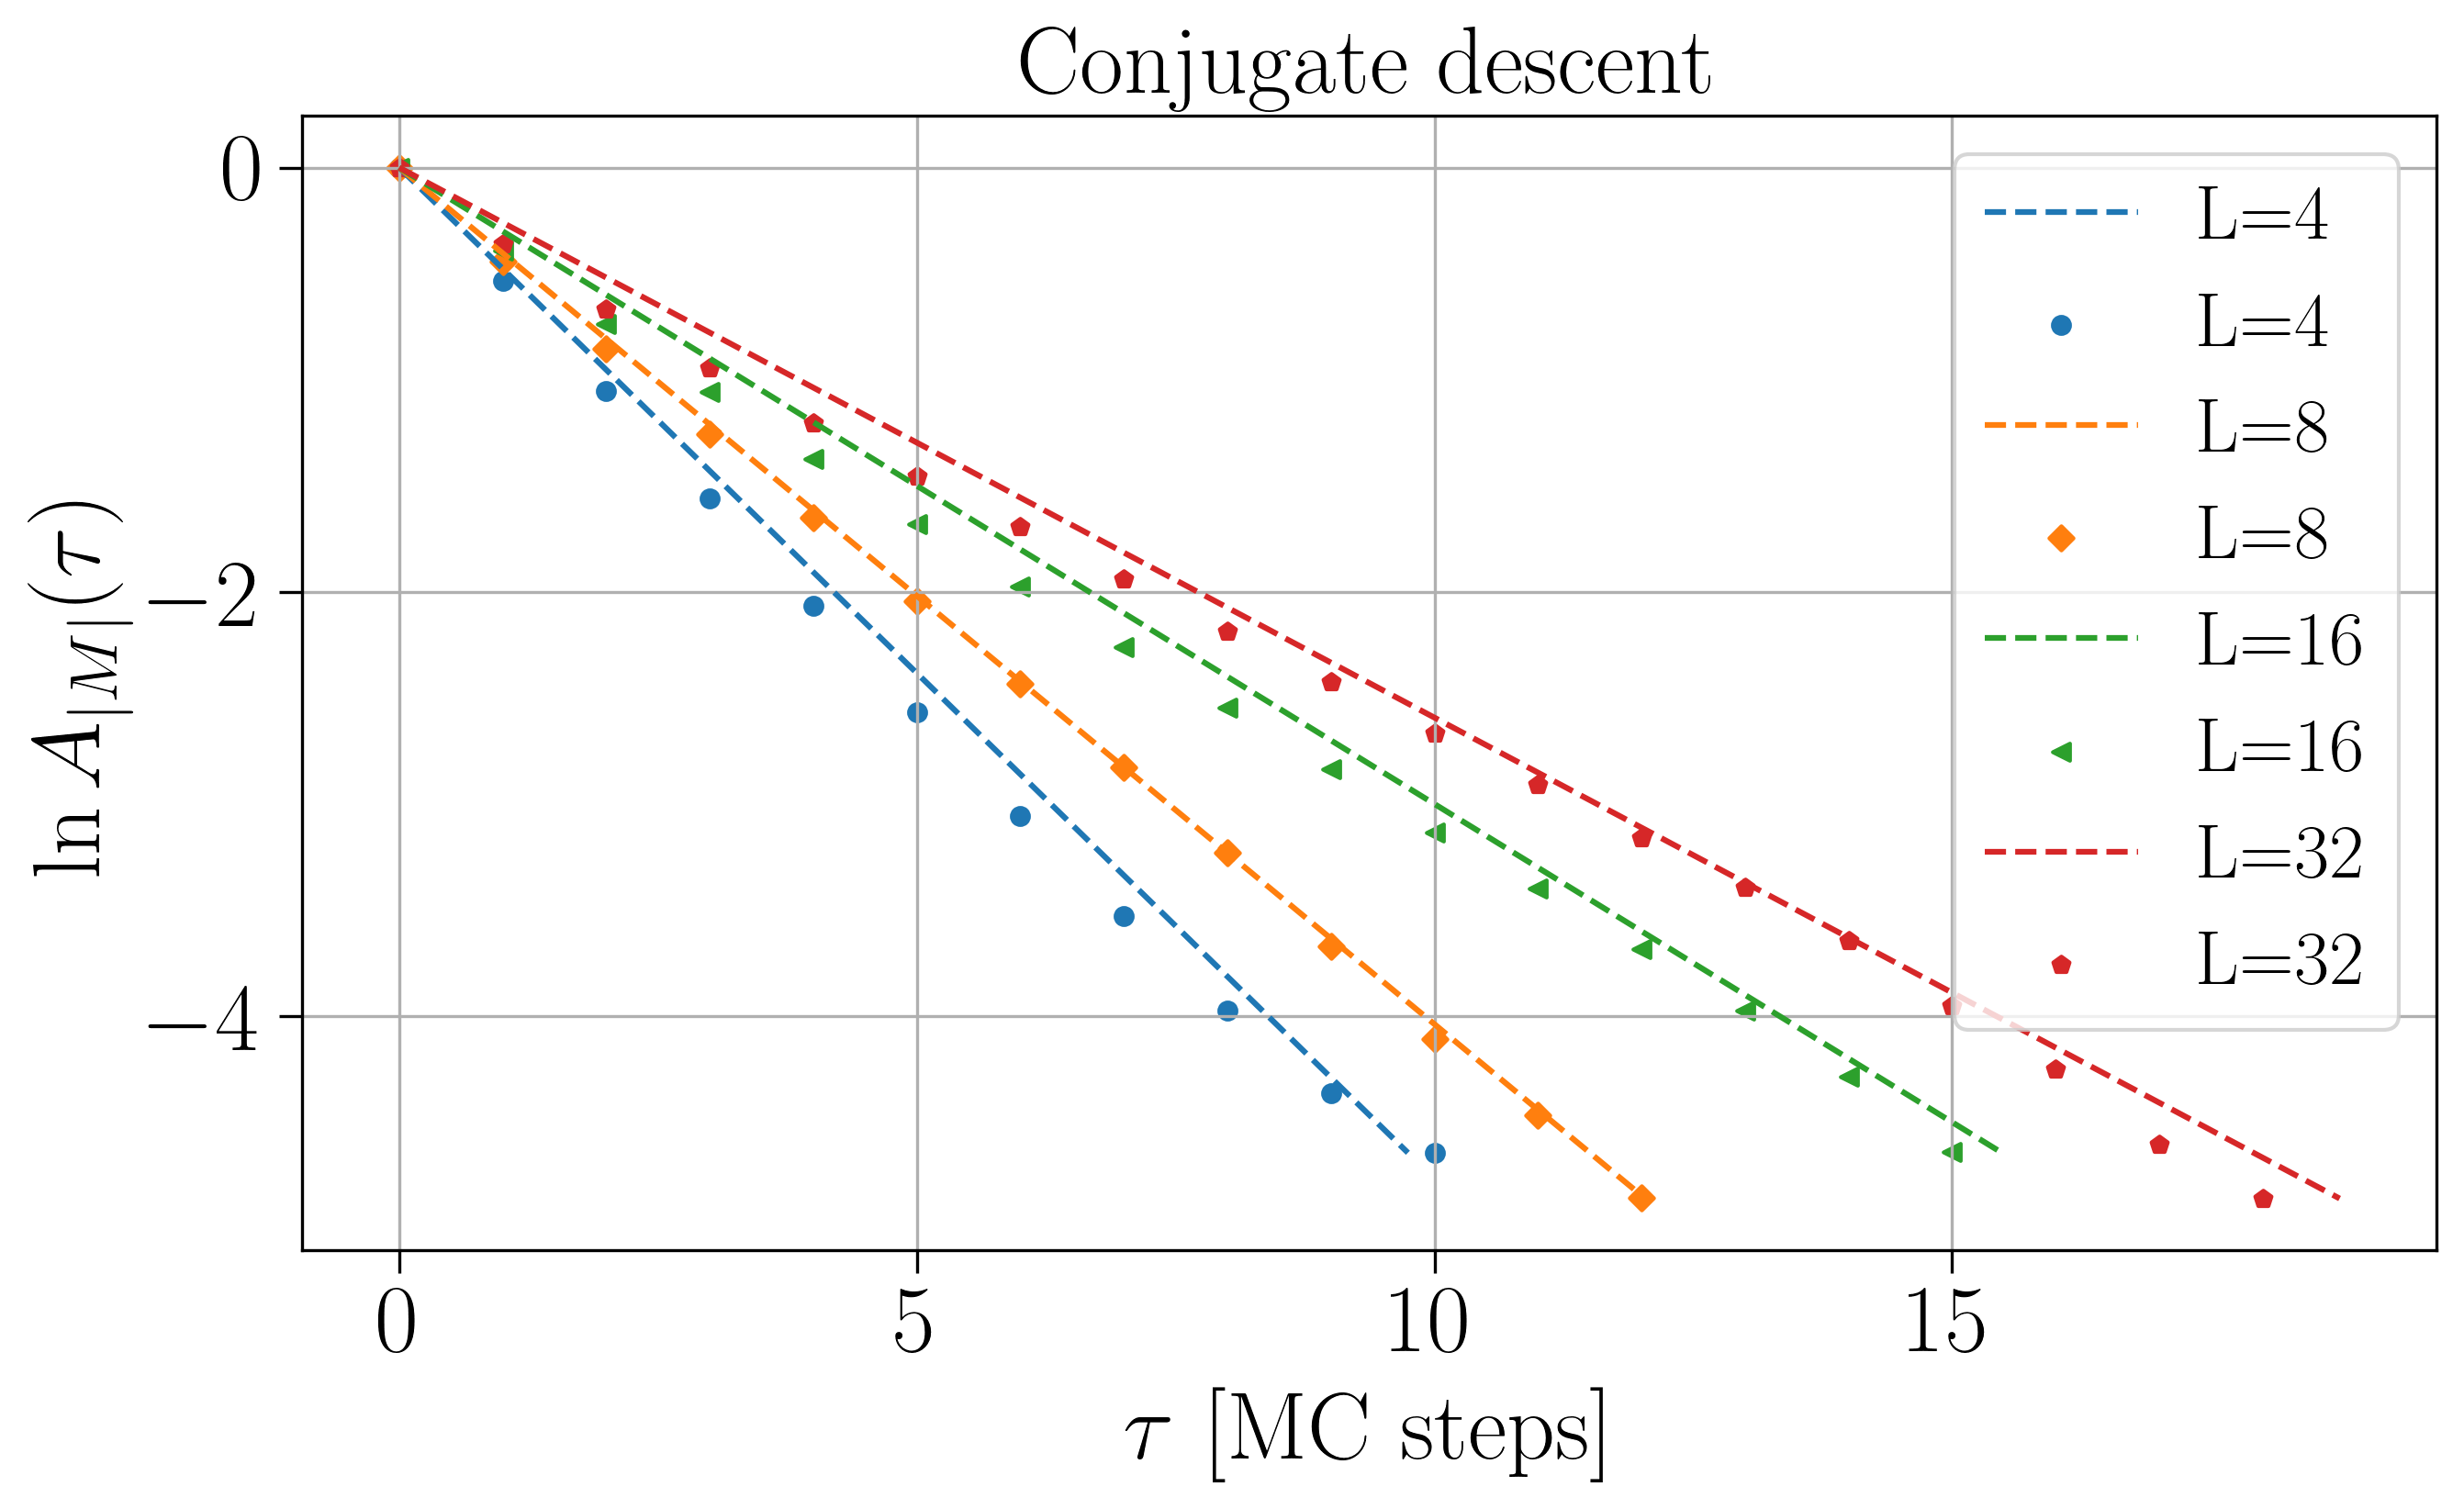

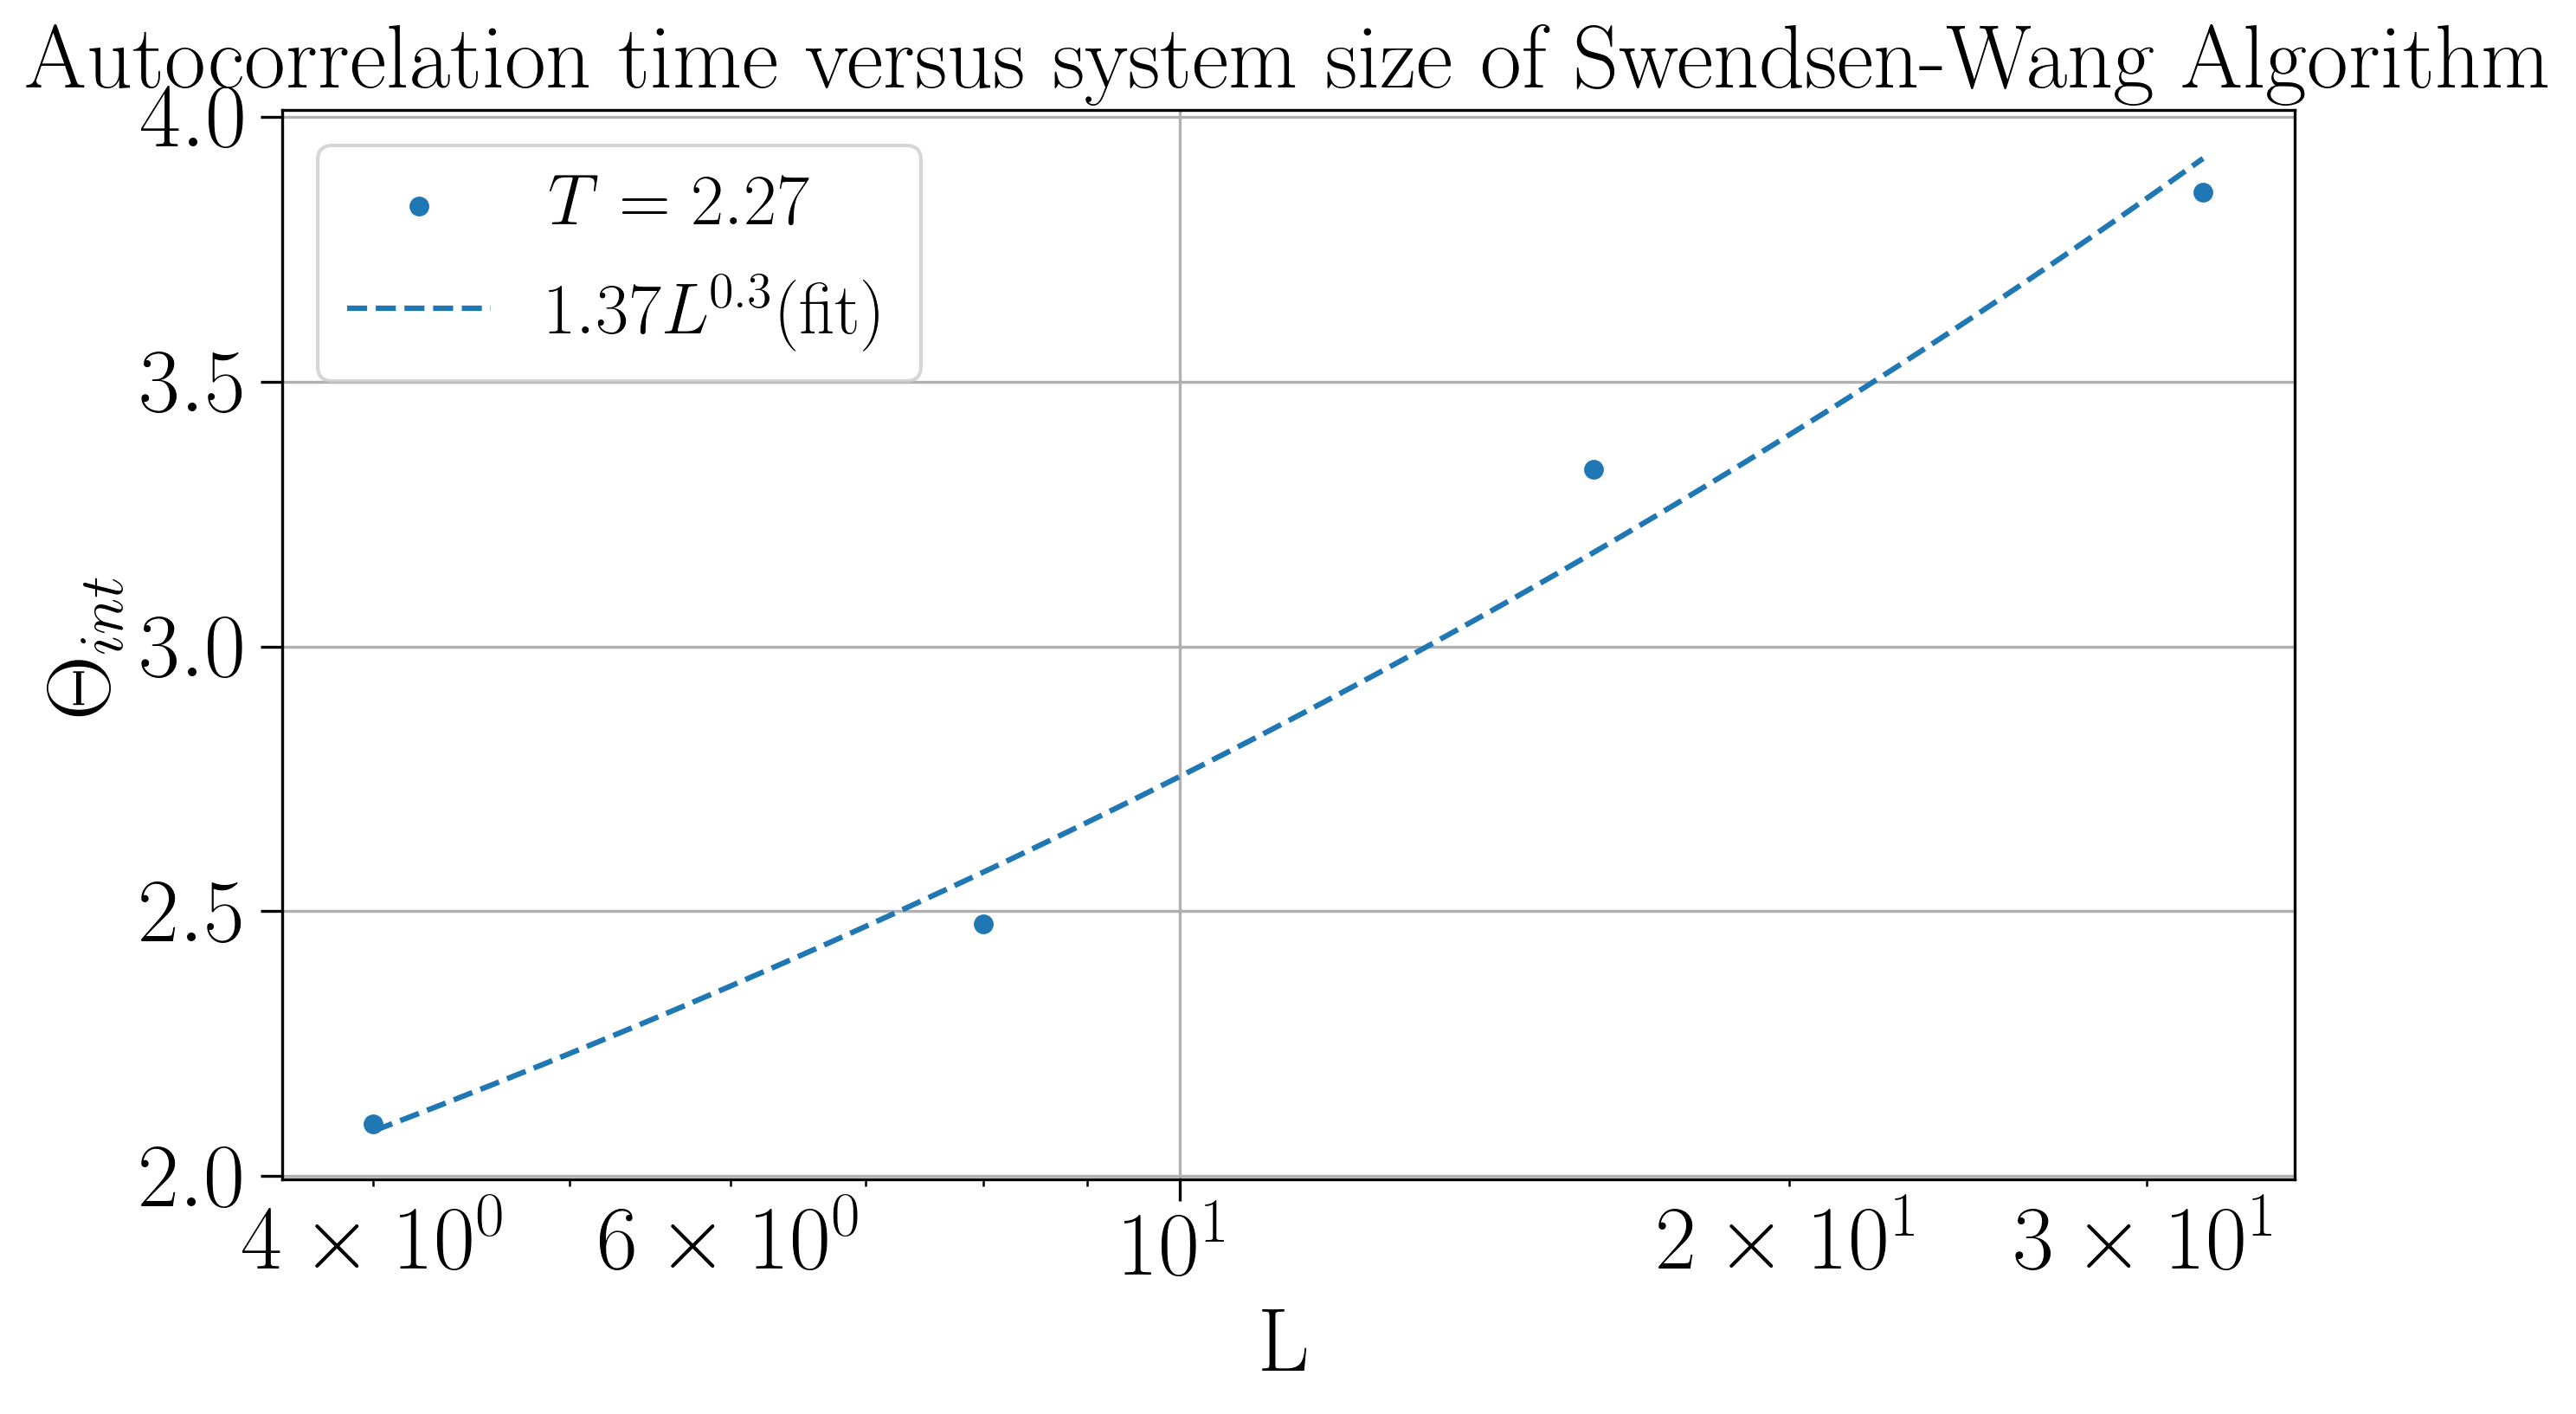

In [292]:
L_list=[4,8,16,32]
ATL_SW, PARS_SW = AutocorrelationTime("SW",AML_SW,L_list)

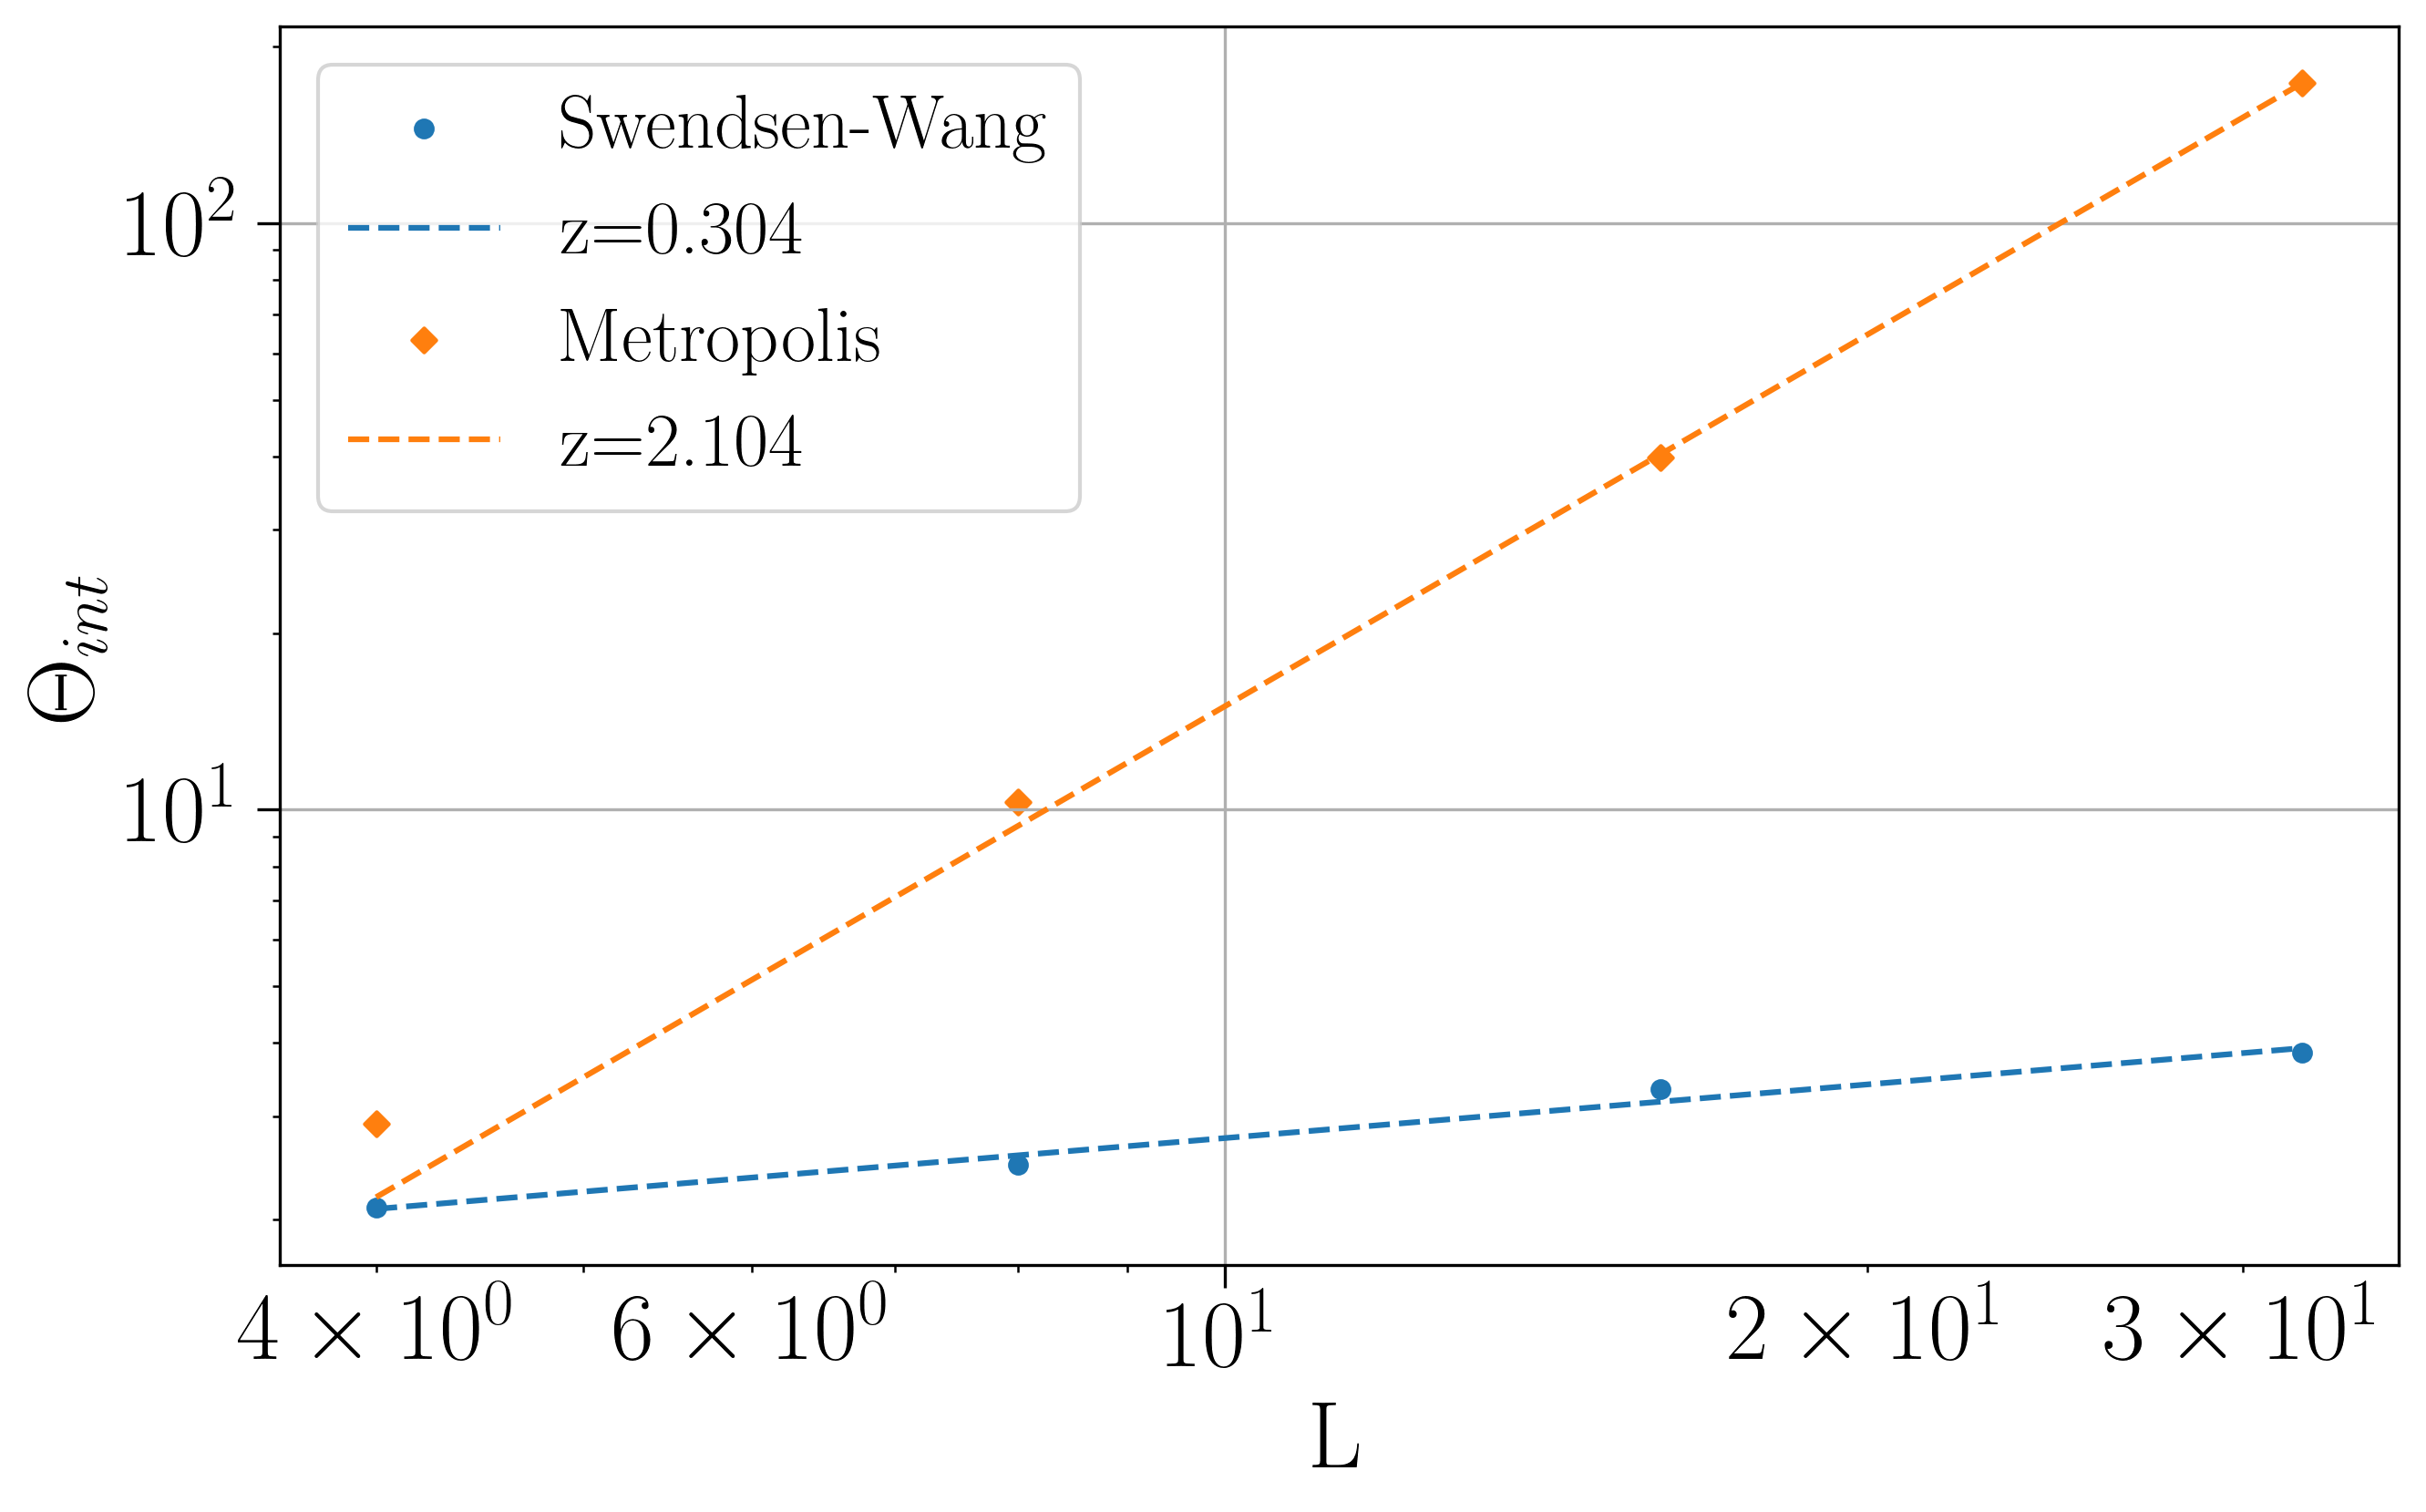

In [293]:
f = plt.figure(figsize=(10,6), dpi=300)
L = np.linspace(L_list[0],L_list[-1],100)
plt.scatter(L_list,ATL_SW,s=20, marker = markers[0],label="Swendsen-Wang")
plt.plot(L,power_law(L, *PARS_SW),linestyle = 'dashed', label=f"z={round(PARS_SW[1],3)}")
plt.scatter(L_list,ATL_M,s=20, marker = markers[1],label="Metropolis")
plt.plot(L,power_law(L, *PARS_M),linestyle = 'dashed', label=f"z={round(PARS_M[1],3)}")
plt.ylabel(r"$\Theta_{int}$", fontsize=25)
plt.xlabel("L", fontsize=25)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.savefig('/Users/johnngan/Desktop/PHYS3999/images/autocorr_time.pdf', bbox_inches='tight')
plt.show()

In [294]:
PARS_M[1]

2.1036876065734957

In [171]:
%matplotlib inline

def Project(algorithm,L_list,Mcstep):
    
    #iterations until it reaches equilibrium state
    Equstep = 1000
    #maximum temperature
    tmax = 3.5
    #minimum temperature
    tmin = 1.5
    #number of temperature points
    tp = int((tmax-tmin)/0.1)
    #temperature
    T = np.linspace(tmin,tmax,tp)
    T_corr = find_nearest(T, 2.269)
    
    #setting up lists
    E_N_expect_L = []
    m_abs_expect_L = []
#     m_sq_expect_L = []
    C_expect_L = []
    X_expect_L = []
    G_expect_L = []
#     G_corr_expect_L = []
    E_N_std_L = []
    m_abs_std_L = []
#     m_sq_std_L = []
    C_std_L = []
    X_std_L = []

    G_std_L = []

    
    
    #for each lattice size
    for L in L_list:
        #record start time of the loop
        start_time = time.time()
        
        #size of the configuration
        N = L*L
    
        #reset lists
        E_expect_tp = []
        m_abs_expect_tp = []
#         m_sq_expect_tp = []
        E_std_tp = []
        m_abs_std_tp = []
#         m_sq_std_tp = []
        C_expect_tp = []
        X_expect_tp = []
        C_std_tp = []
        X_std_tp = []

        G_expect_tp = []
        G_std_tp = []

        

        #for each temerature point
        for i in range(tp):
            #reset lists
            E_expect = []
            m_abs_expect = []
#             m_sq_expect = []
            C_list = []
            X_list = []

            G_expect = []

            

            Config = lattice(L)
            #perform metropolis algorithm until it reaches equilibrium state
            if algorithm == "M":
                for j in range(Equstep):         
                    MC = Metropolis(Config,L,T[i])

                #setting up lists
                M_list = []
                E_list = []
                m_list = []

                G_list = []


                #perform metropolis algorithm to collect data
                for k in range(Mcstep):
                    MC = Metropolis(Config,L,T[i])
                    #Sum of Spin M
                    M_list.append(np.sum(MC))           
                    #Energy E
                    E_list.append(Energy(MC,L)) 
                    #Magnitization m
                    m_list.append(Magnetization(MC,L))
                    
                    if T[i] in [tmin, T_corr, tmax]:
                        G_list.append(Correlation(MC,L))
                    
                    #binning
                    if k%(Mcstep/100) ==0 and k!=0:
                        #<E> per bin
                        E_expect.append(np.mean(E_list))         
                        #<|m|> per bin
                        m_abs_expect.append(np.mean([abs(i) for i in m_list]))
#                         #<m^2> per bin
#                         m_sq_expect.append(np.mean([i**2 for i in m_list]))
                        #Specific Heat C per bin
                        C_list.append(Specific_Heat(E_list,L,T[i]))
                        #Susceptibility X per bin
                        X_list.append(Susceptibility(M_list,N,T[i]))
                        if T[i] in [tmin, T_corr, tmax]:
                            G_expect.append(np.mean(G_list, axis =0))
                            G_list = []


                        #reset the list
                        M_list = []
                        E_list = []
                        m_list = []
            
            elif algorithm == "SW":
                for j in range(Equstep):         
                    MC = SwendsenWang(Config,L,T[i])

                #setting up lists
                M_list = []
                E_list = []
                m_list = []
                G_list = []

                #perform Swendsen-Wang algorithm to collect data
                for k in range(Mcstep):
                    MC = SwendsenWang(Config,L,T[i])
                    #Sum of Spin M
                    M_list.append(np.sum(MC))           
                    #Energy E
                    E_list.append(Energy(MC,L)) 
                    #Magnitization m
                    m_list.append(Magnetization(MC,L))
                    
                    if T[i] in [tmin, T_corr, tmax]:
                        G_list.append(Correlation(MC,L))

                    #binning
                    if k%(Mcstep/100) ==0 and k!=0:
                        #<E> per bin
                        E_expect.append(np.mean(E_list))         
                        #<|m|> per bin
                        m_abs_expect.append(np.mean([abs(i) for i in m_list]))
#                         #<m^2> per bin
#                         m_sq_expect.append(np.mean([i**2 for i in m_list]))
                        #Specific Heat C per bin
                        C_list.append(Specific_Heat(E_list,L,T[i]))
                        #Susceptibility X per bin
                        X_list.append(Susceptibility(M_list,N,T[i]))
                        if T[i] in [tmin, T_corr, tmax]:
                            G_expect.append(np.mean(G_list, axis =0))
                            G_list = []
                            
                        #reset the list
                        M_list = []
                        E_list = []
                        m_list = []
                        
            
            #<E> per temperature point
            E_expect_tp.append(np.mean(E_expect))
            #<|m|> per temperature point
            m_abs_expect_tp.append(np.mean(m_abs_expect))
#             #<m^2> per temperature point
#             m_sq_expect_tp.append(np.mean(m_sq_expect))
            #<C> per temperature point
            C_expect_tp.append(np.mean(C_list))
            #<X> per temperature point
            X_expect_tp.append(np.mean(X_list))
            
            #standard deviation of E per temperature point
            E_std_tp.append(np.std(E_expect, ddof = 1))
            #standard deviation of |m| per temperature point
            m_abs_std_tp.append(np.std(m_abs_expect, ddof = 1))
#             #standard deviation of m^2 per temperature point
#             m_sq_std_tp.append(np.std(m_sq_expect, ddof = 1))
            #standard deviation of C per temperature point
            C_std_tp.append(np.std(C_list, ddof = 1))
            #standard deviation of X per temperature point
            X_std_tp.append(np.std(X_list, ddof = 1))
            
            if T[i] in [tmin, T_corr, tmax]:
                #<C(r)> of target temperature
                G_expect_tp.append(np.mean(G_expect, axis=0))
                #standard deviation of C(r) of target temperature
                G_std_tp.append(np.std(G_expect, axis=0, ddof = 1))
            
            #check progress
            if (i+1)%10 == 0 and i!=0:
                print(str(i+1)+" temperature points finished")
            
        #perform Logsitic Regression to find out T_c 
        T_c = LogisticRegression(T,m_abs_expect_tp,L)
        
        #<E>/N per L
        E_N_expect_L.append([i/N for i in E_expect_tp])
        #<|m|> per L
        m_abs_expect_L.append(m_abs_expect_tp)
#         #<m^2> per L
#         m_sq_expect_L.append(m_sq_expect_tp)
        #<C> per L
        C_expect_L.append(C_expect_tp)
        #<X> per L
        X_expect_L.append(X_expect_tp)
        #<C(r)> per L
        G_expect_L.append(G_expect_tp)

        #standard deviation of E/N per L
        E_N_std_L.append([i/N for i in E_std_tp])
        #standard deviation of |m| per L
        m_abs_std_L.append(m_abs_std_tp)
#         #standard deviation of m^2 per L
#         m_sq_std_L.append(m_sq_std_tp)
        #standard deviation of C per L
        C_std_L.append(C_std_tp)
        #standard deviation of X per L
        X_std_L.append(X_std_tp)
        #standard deviation of C(r) per L
        G_std_L.append(G_std_tp)
        
        #time used for the loop for each L
        print("computing time for L="+str(L)+": %s seconds" % (time.time() - start_time))
    
    f = plt.figure(figsize=(20, 16), dpi = 300)     
    
    plt.rc('font', family='serif')
    plt.rc('xtick', labelsize=25)
    plt.rc('ytick', labelsize=25)
    plt.rc('legend',fontsize=25)

    #<E> / N vs Temperature graph
    sp =  f.add_subplot(2,2,1)
    for i in range(len(L_list)):
        plt.errorbar(T, E_N_expect_L[i],yerr=E_N_std_L[i], fmt=markers[i],label="L="+str(L_list[i]))
    plt.xlabel("T", fontsize=25)
    plt.ylabel(r"$\left< E \right> / N$", fontsize=25)        
    plt.legend()

    #<|m|> vs Temperature graph
    sp =  f.add_subplot(2,2,2)
    for i in range(len(L_list)):
        plt.errorbar(T, m_abs_expect_L[i],yerr=m_abs_std_L[i], fmt=markers[i],label="L="+str(L_list[i]))
    plt.xlabel("T", fontsize=25) 
    plt.ylabel(r"$\left< |m| \right> $", fontsize=25)   
    plt.legend()

#     #<m^2> vs Temperature graph
#     sp =  f.add_subplot(2,2,3)
#     for i in range(len(L_list)):
#         plt.errorbar(T, m_sq_expect_L[i], yerr= m_sq_std_L[i], fmt=markers[i],label="L="+str(L_list[i]))
#     plt.xlabel("Temperature", fontsize=25); 
#     plt.ylabel("<m^2>", fontsize=25)   
#     plt.title("<m^2> vs Temperature graph", fontsize=25)
#     plt.legend()

    #<C> vs Temperature graph
    sp =  f.add_subplot(2,2,3)
    for i in range(len(L_list)):
        plt.errorbar(T, C_expect_L[i], yerr=C_std_L[i], fmt=markers[i],label="L="+str(L_list[i]))
    plt.xlabel("T", fontsize=25) 
    plt.ylabel(r"$\left< C \right>$", fontsize=25)    
    plt.legend()

    #<X> vs Temperature graph
    sp =  f.add_subplot(2,2,4)
    for i in range(len(L_list)):
        plt.errorbar(T, X_expect_L[i],yerr=X_std_L[i], fmt=markers[i],label="L="+str(L_list[i]))
    plt.xlabel("T", fontsize=25) 
    plt.ylabel(r"$\left< X \right>$", fontsize=25)
    plt.yscale("log")
    plt.legend()

#     #<SiSj> vs Temperature graph
#     sp =  f.add_subplot(4,2,6)
#     for i in range(len(L_list)):
#         plt.errorbar(list(range(L_list[i])), G_expect_L[i][1],yerr=G_std_L[i][1], fmt=markers[i],label="L="+str(L_list[i]))
#     plt.xlabel("radius", fontsize=25) 
#     plt.ylabel("correlation", fontsize=25)
#     plt.title(f"spin-spin correlation at T = {round(T_corr,2)}", fontsize=25)
#     plt.legend()
    
#     #<SiSj>-<Si>^2 vs Temperature graph
#     sp =  f.add_subplot(4,2,7)
#     for i in range(len(L_list)):
#         plt.errorbar(list(range(L_list[i])), G_corr_expect_L[i][1],yerr=G_corr_std_L[i][1], fmt=markers[i],label="L="+str(L_list[i]))
#     plt.xlabel("radius", fontsize=25) 
#     plt.ylabel("corrected correlation", fontsize=25)
#     plt.title(f"corrected spin-spin correlation at T = {round(T_corr,2)}", fontsize=25)
#     plt.legend()
    
    if algorithm == "M":
        f.savefig('/Users/johnngan/Desktop/PHYS3999/images/observables_M.pdf', bbox_inches='tight')
    if algorithm == "SW":
        f.savefig('/Users/johnngan/Desktop/PHYS3999/images/observables_SW.pdf', bbox_inches='tight')
    plt.show()

#     return T_c,E_N_expect_L, m_abs_expect_L, m_sq_expect_L, C_expect_L, X_expect_L, G_expect_L, E_N_std_L, m_abs_std_L, m_sq_std_L, C_std_L, X_std_L, G_std_L
    return T_c, E_N_expect_L, m_abs_expect_L, C_expect_L, X_expect_L, G_expect_L, E_N_std_L, m_abs_std_L, C_std_L, X_std_L, G_std_L

10 temperature points finished
20 temperature points finished
Cost history of L = 4 :
 [0.67969429 0.66674511 0.6542804  ... 0.11818473 0.11818444 0.11818415]
T_c for L = 4 is 3.9531463087558905
computing time for L=4: 307.6219148635864 seconds
10 temperature points finished
20 temperature points finished
Cost history of L = 8 :
 [0.69293963 0.69273651 0.69253765 ... 0.12073592 0.12073545 0.12073498]
T_c for L = 8 is 2.592031306789198
computing time for L=8: 783.2450277805328 seconds
10 temperature points finished
20 temperature points finished
Cost history of L = 16 :
 [0.69164941 0.69020474 0.68881119 ... 0.11475677 0.11475632 0.11475588]
T_c for L = 16 is 2.3815312773526878
computing time for L=16: 2876.5141048431396 seconds
10 temperature points finished
20 temperature points finished
Cost history of L = 32 :
 [0.69054496 0.68803759 0.68562149 ... 0.11225066 0.11225022 0.11224978]
T_c for L = 32 is 2.2762109624527764
computing time for L=32: 11264.129316091537 seconds


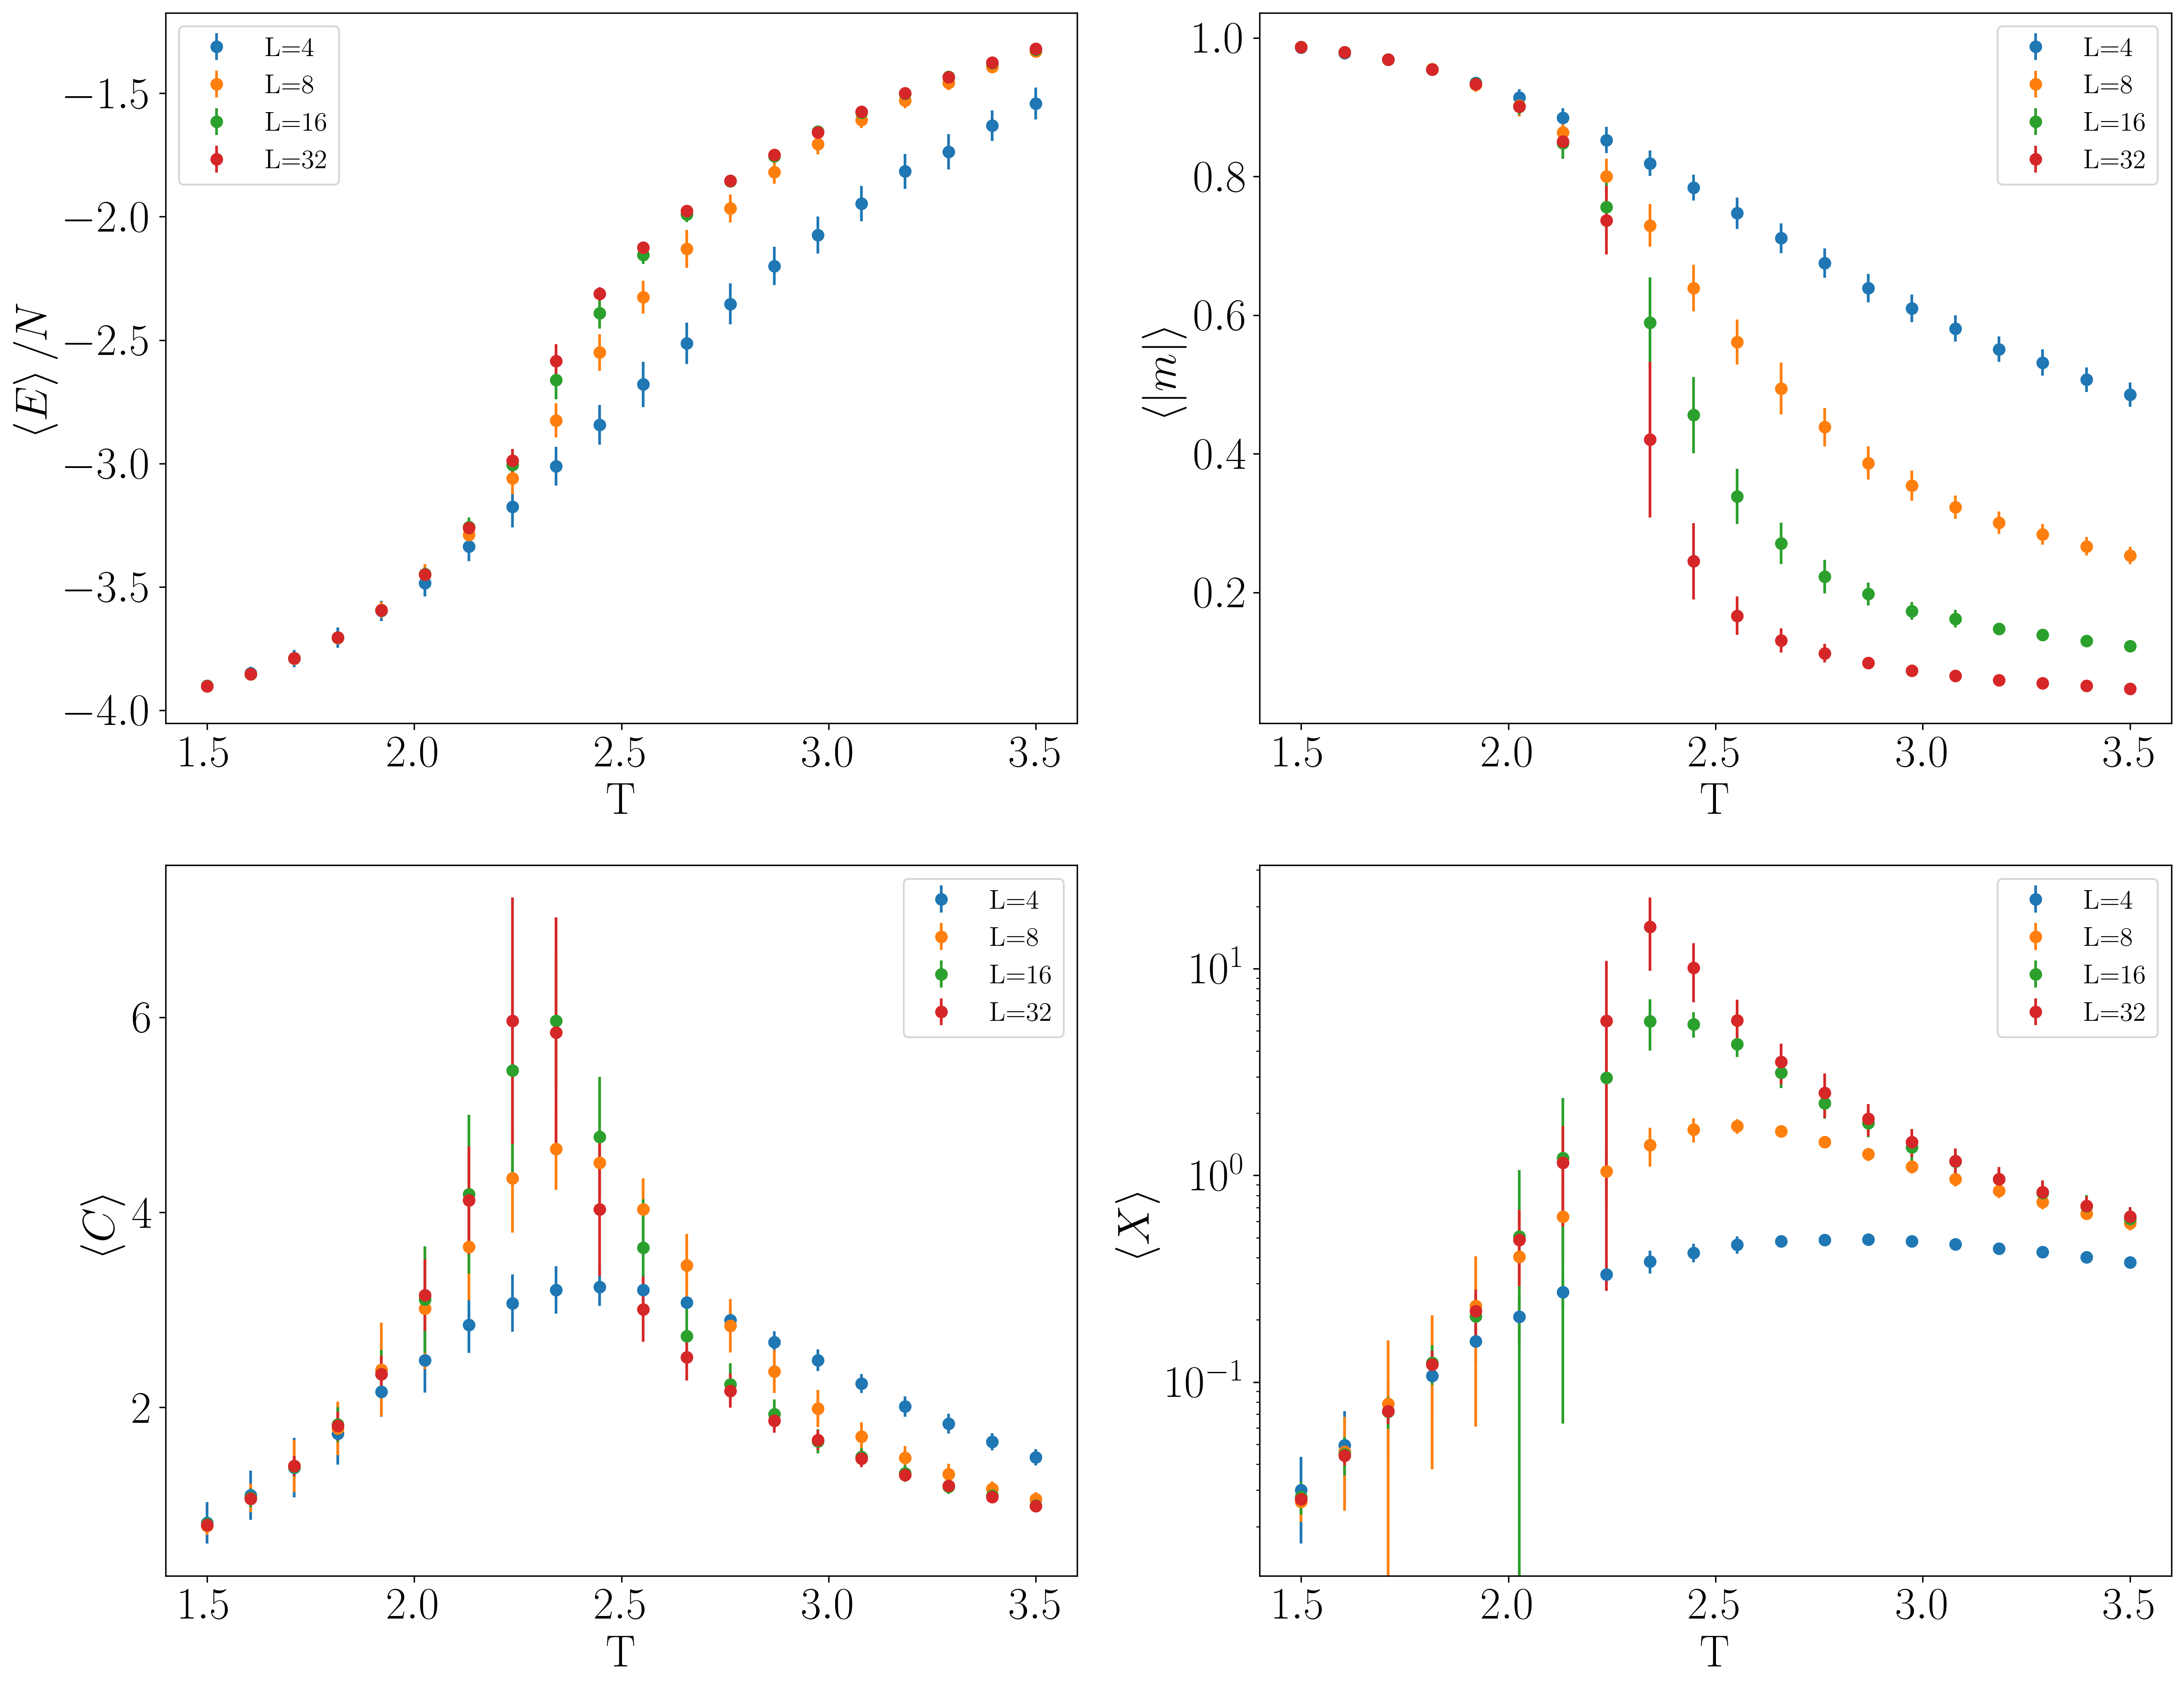

In [61]:
#For L=4,8,16,32, metropolis method
L_list = [4,8,16,32]
#TC, E_M, M_ABS_M, M_SQ_M, C_M, X_M, G_M, G_CORR_M, E_STD_M, M_ABS_STD_M, M_SQ_STD_M, C_STD_M, X_STD_M, G_STD_M, G_CORR_STD_M = Project("M",L_list,100000)
TC, E_M, M_ABS_M, C_M, X_M, G_M, E_STD_M, M_ABS_STD_M, C_STD_M, X_STD_M, G_STD_M = Project("M",L_list,100000)

10 temperature points finished
20 temperature points finished
Cost history of L = 4 :
 [0.67969429 0.66674511 0.6542804  ... 0.11818473 0.11818444 0.11818415]
T_c for L = 4 is 3.9531463087558905
computing time for L=4: 317.73638105392456 seconds
10 temperature points finished
20 temperature points finished
Cost history of L = 8 :
 [0.69293963 0.69273651 0.69253765 ... 0.12073592 0.12073545 0.12073498]
T_c for L = 8 is 2.592031306789198
computing time for L=8: 899.28919506073 seconds
10 temperature points finished
20 temperature points finished
Cost history of L = 16 :
 [0.69164941 0.69020474 0.68881119 ... 0.11475677 0.11475632 0.11475588]
T_c for L = 16 is 2.3815312773526878
computing time for L=16: 3290.670564174652 seconds
10 temperature points finished
20 temperature points finished
Cost history of L = 32 :
 [0.69054496 0.68803759 0.68562149 ... 0.11225066 0.11225022 0.11224978]
T_c for L = 32 is 2.2762109624527764
computing time for L=32: 12934.47417807579 seconds


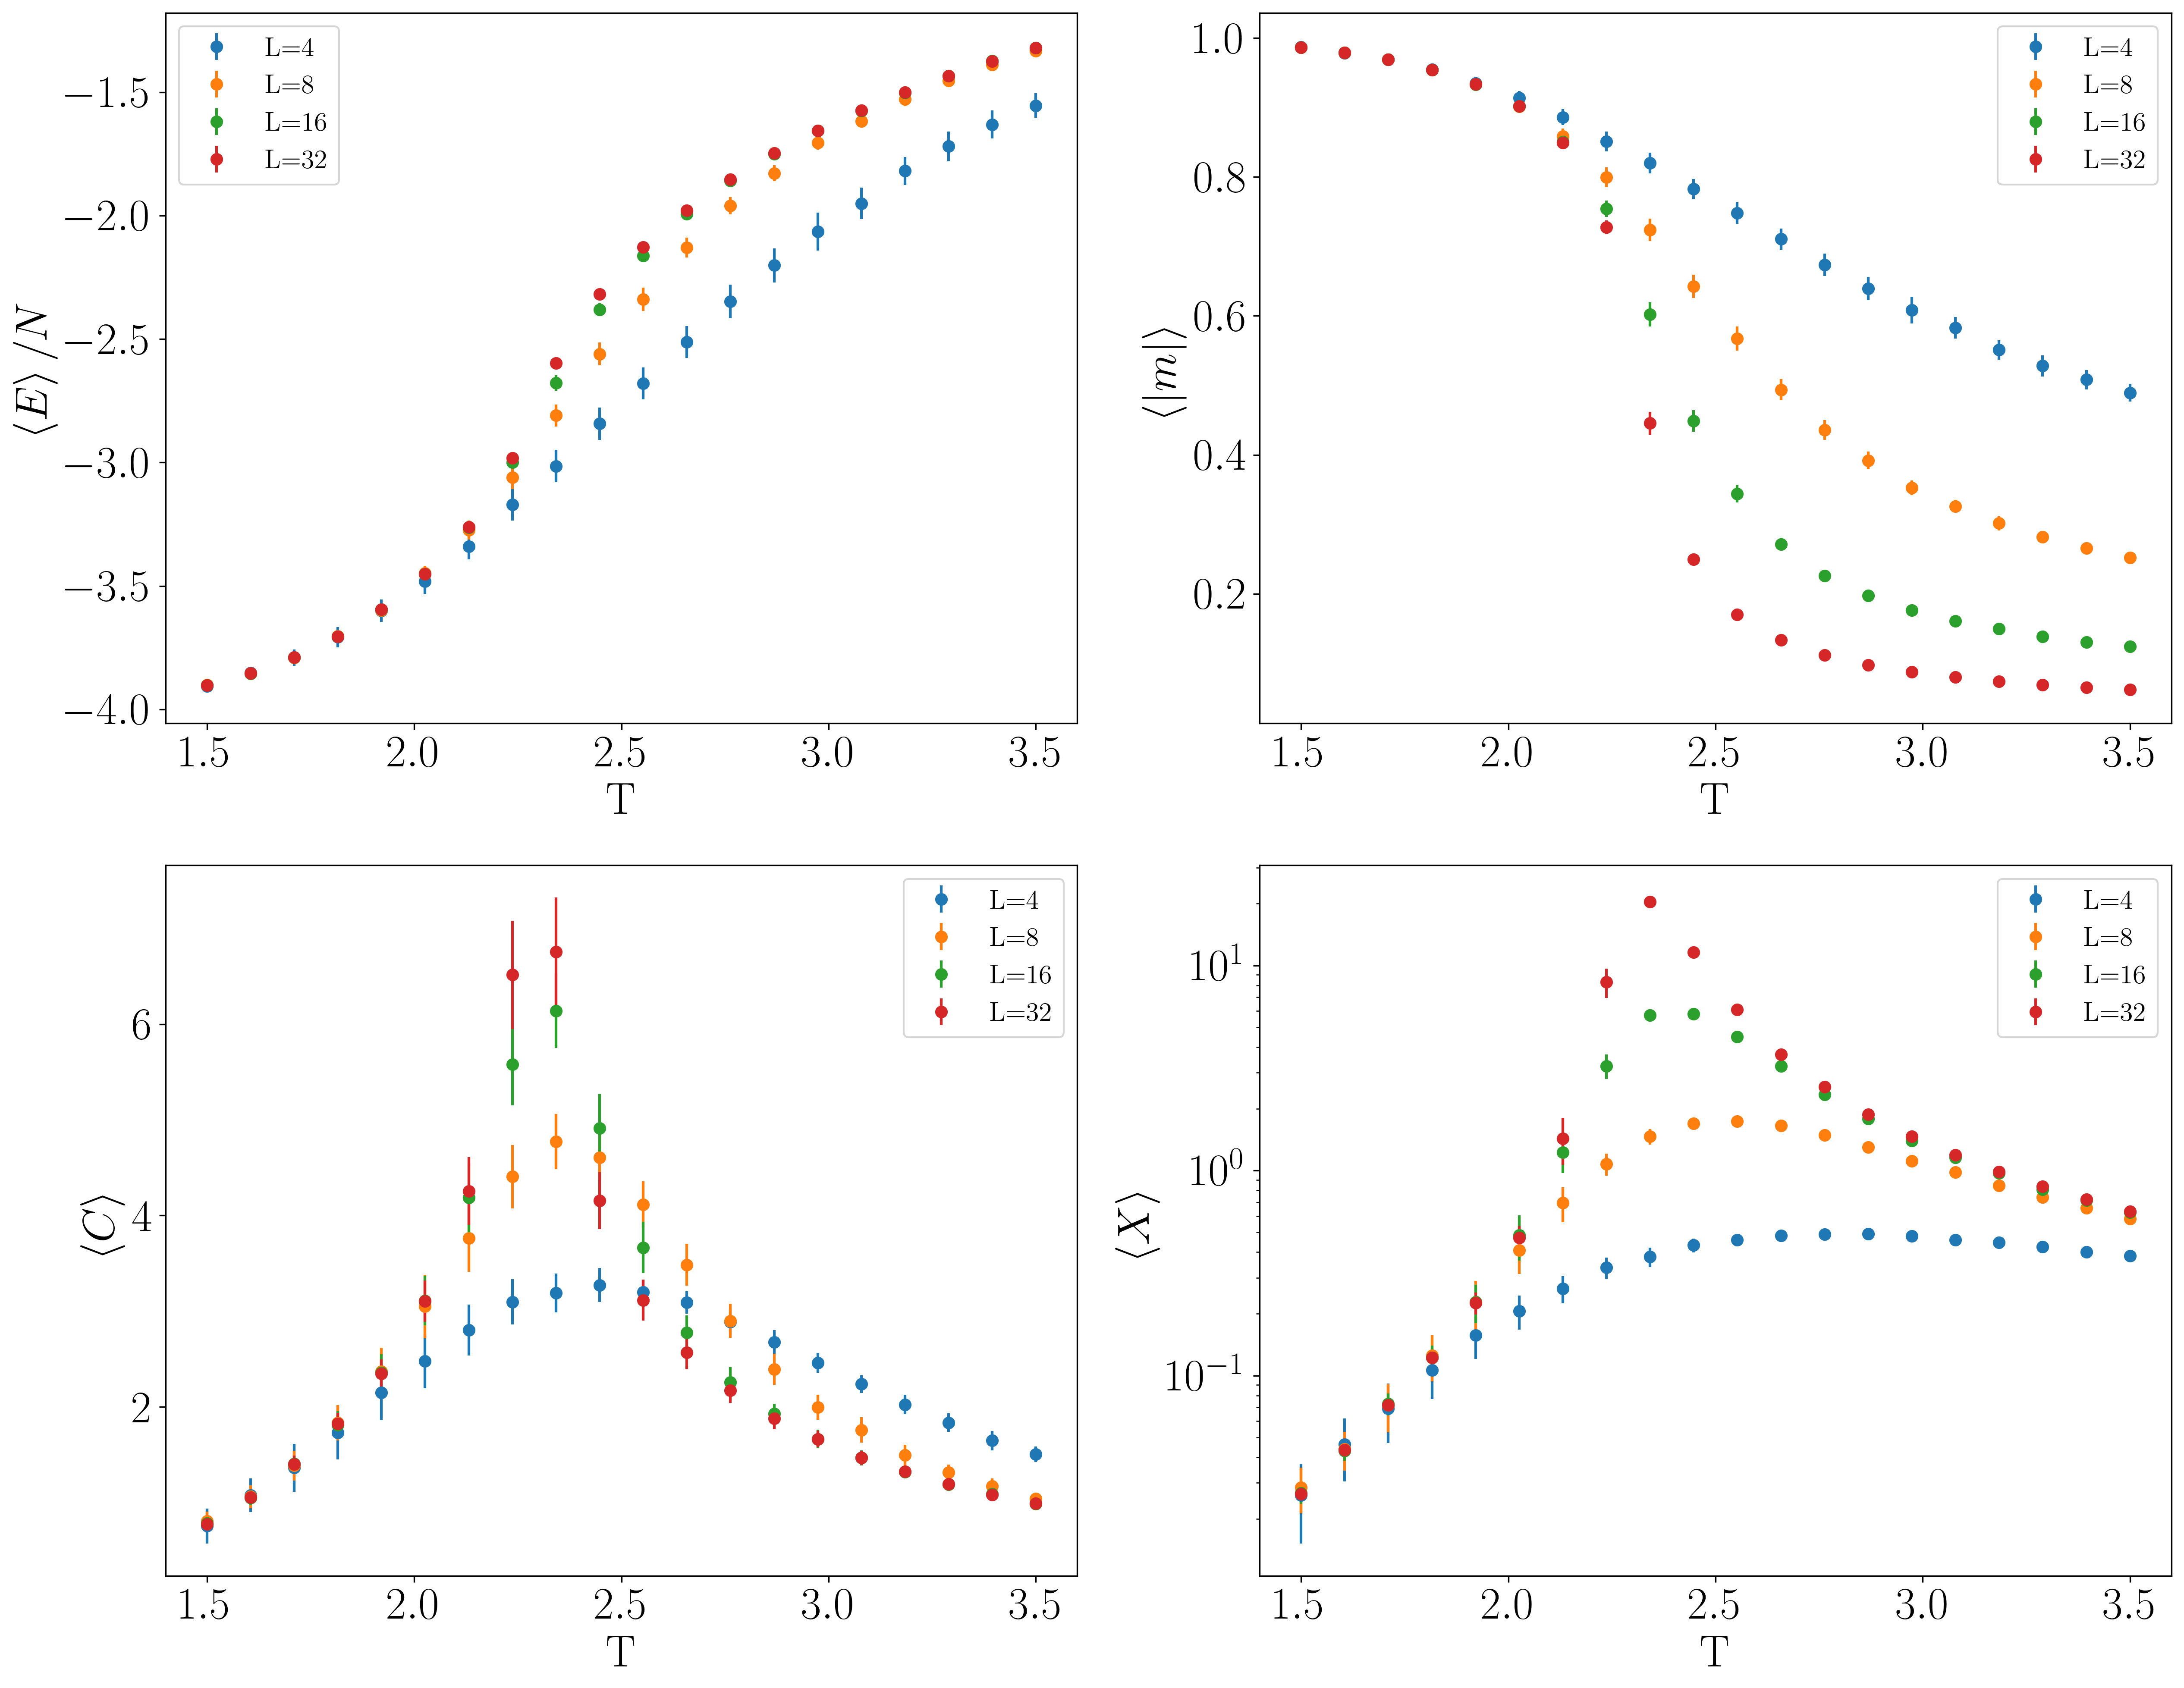

In [62]:
#For L=4,8,16,32, Swendsen-Wang method
L_list = [4,8,16,32]
#TC, E_SW, M_ABS_SW, M_SQ_SW, C_SW, X_SW, G_SW, G_CORR_SW, E_STD_SW, M_ABS_STD_SW, M_SQ_STD_SW, C_STD_SW, X_STD_SW, G_STD_SW, G_CORR_STD_SW = Project("SW",L_list,100000)
TC, E_SW, M_ABS_SW, C_SW, X_SW, G_SW, E_STD_SW, M_ABS_STD_SW, C_STD_SW, X_STD_SW, G_STD_SW = Project("SW",L_list,100000)

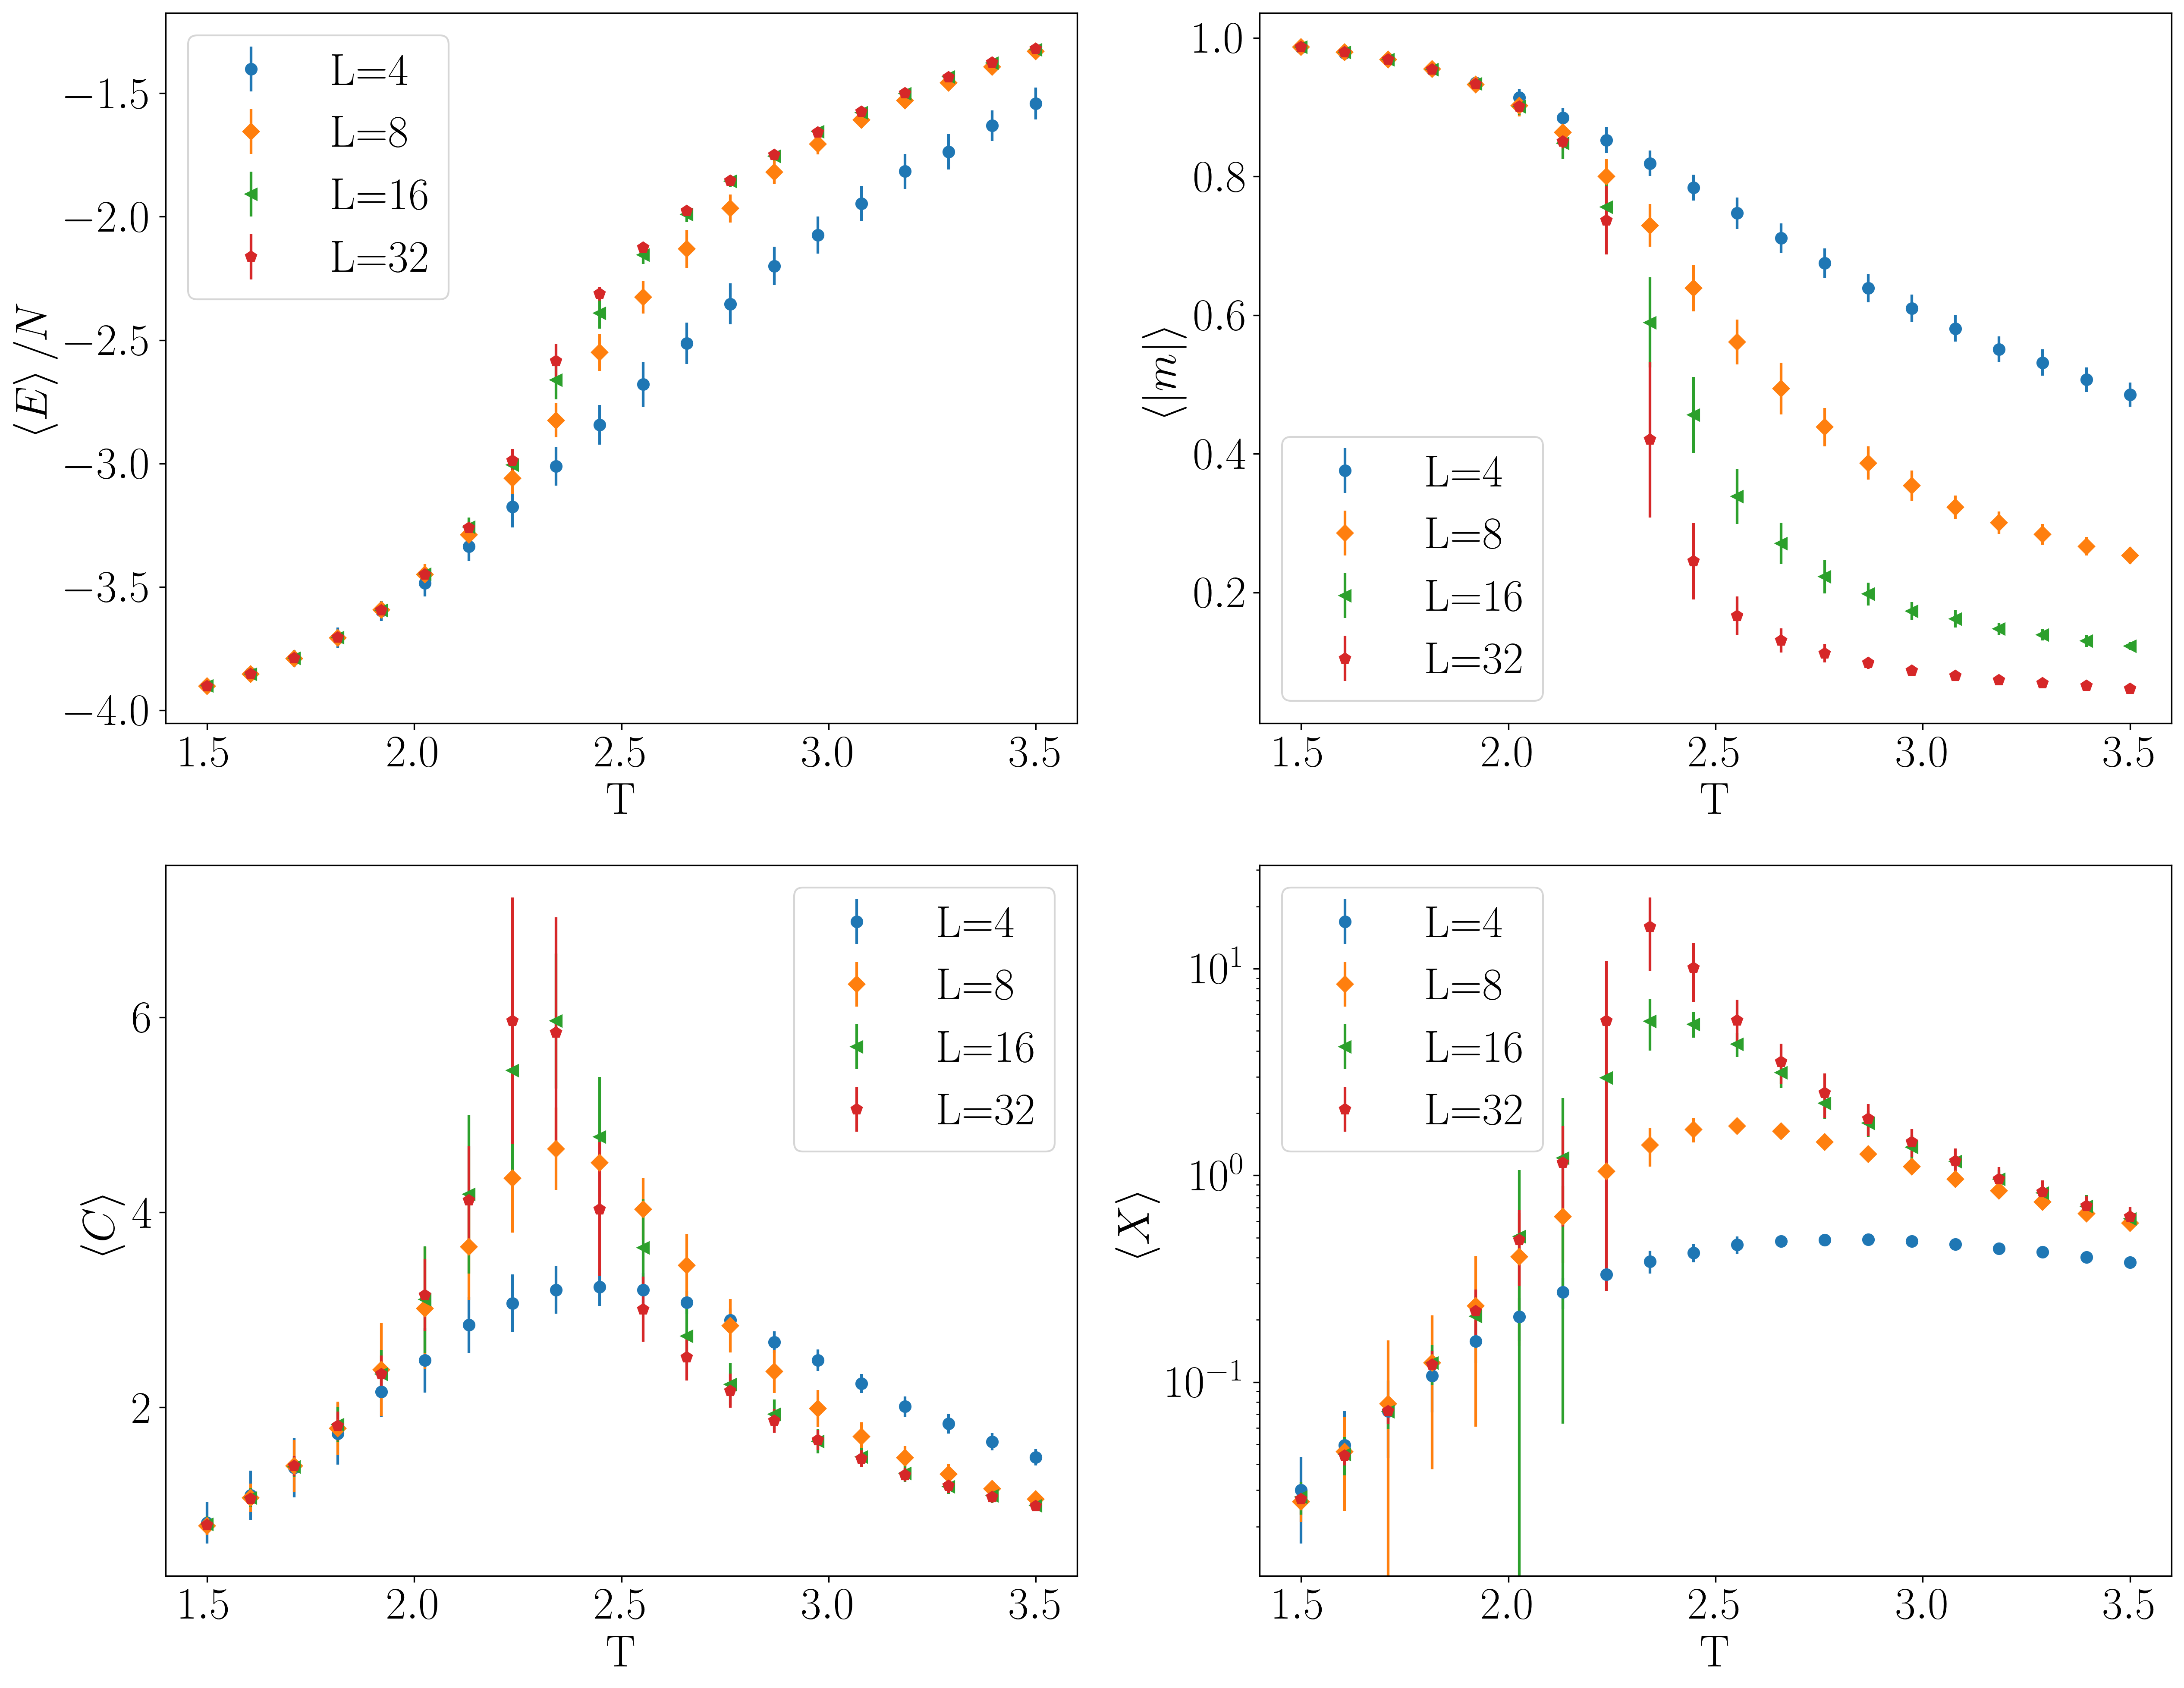

In [197]:
#iterations until it reaches equilibrium state
Equstep = 1000
#maximum temperature
tmax = 3.5
#minimum temperature
tmin = 1.5
#number of temperature points
tp = int((tmax-tmin)/0.1)
#temperature
T = np.linspace(tmin,tmax,tp)
T_corr = find_nearest(T, 2.269)

f = plt.figure(figsize=(20, 16), dpi = 300)     

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)
plt.rc('legend',fontsize=25)

#<E> / N vs Temperature graph
sp =  f.add_subplot(2,2,1)
for i in range(len(L_list)):
    plt.errorbar(T, E_M[i],yerr=E_STD_M[i], fmt=markers[i],label="L="+str(L_list[i]))
plt.xlabel("T", fontsize=25)
plt.ylabel(r"$\left< E \right> / N$", fontsize=25)        
plt.legend()

#<|m|> vs Temperature graph
sp =  f.add_subplot(2,2,2)
for i in range(len(L_list)):
    plt.errorbar(T, M_ABS_M[i],yerr=M_ABS_STD_M[i], fmt=markers[i],label="L="+str(L_list[i]))
plt.xlabel("T", fontsize=25) 
plt.ylabel(r"$\left< |m| \right> $", fontsize=25)   
plt.legend()

#<C> vs Temperature graph
sp =  f.add_subplot(2,2,3)
for i in range(len(L_list)):
    plt.errorbar(T, C_M[i], yerr=C_STD_M[i], fmt=markers[i],label="L="+str(L_list[i]))
plt.xlabel("T", fontsize=25) 
plt.ylabel(r"$\left< C \right>$", fontsize=25)    
plt.legend()

#<X> vs Temperature graph
sp =  f.add_subplot(2,2,4)
for i in range(len(L_list)):
    plt.errorbar(T, X_M[i],yerr=X_STD_M[i], fmt=markers[i],label="L="+str(L_list[i]))
plt.xlabel("T", fontsize=25) 
plt.ylabel(r"$\left< X \right>$", fontsize=25)
plt.yscale("log")
plt.legend()

f.savefig('/Users/johnngan/Desktop/PHYS3999/images/observables_M.pdf', bbox_inches='tight')


In [267]:
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams['figure.dpi'] = 300
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)
plt.rc('legend',fontsize=20)
plt.rc('text', usetex=True)

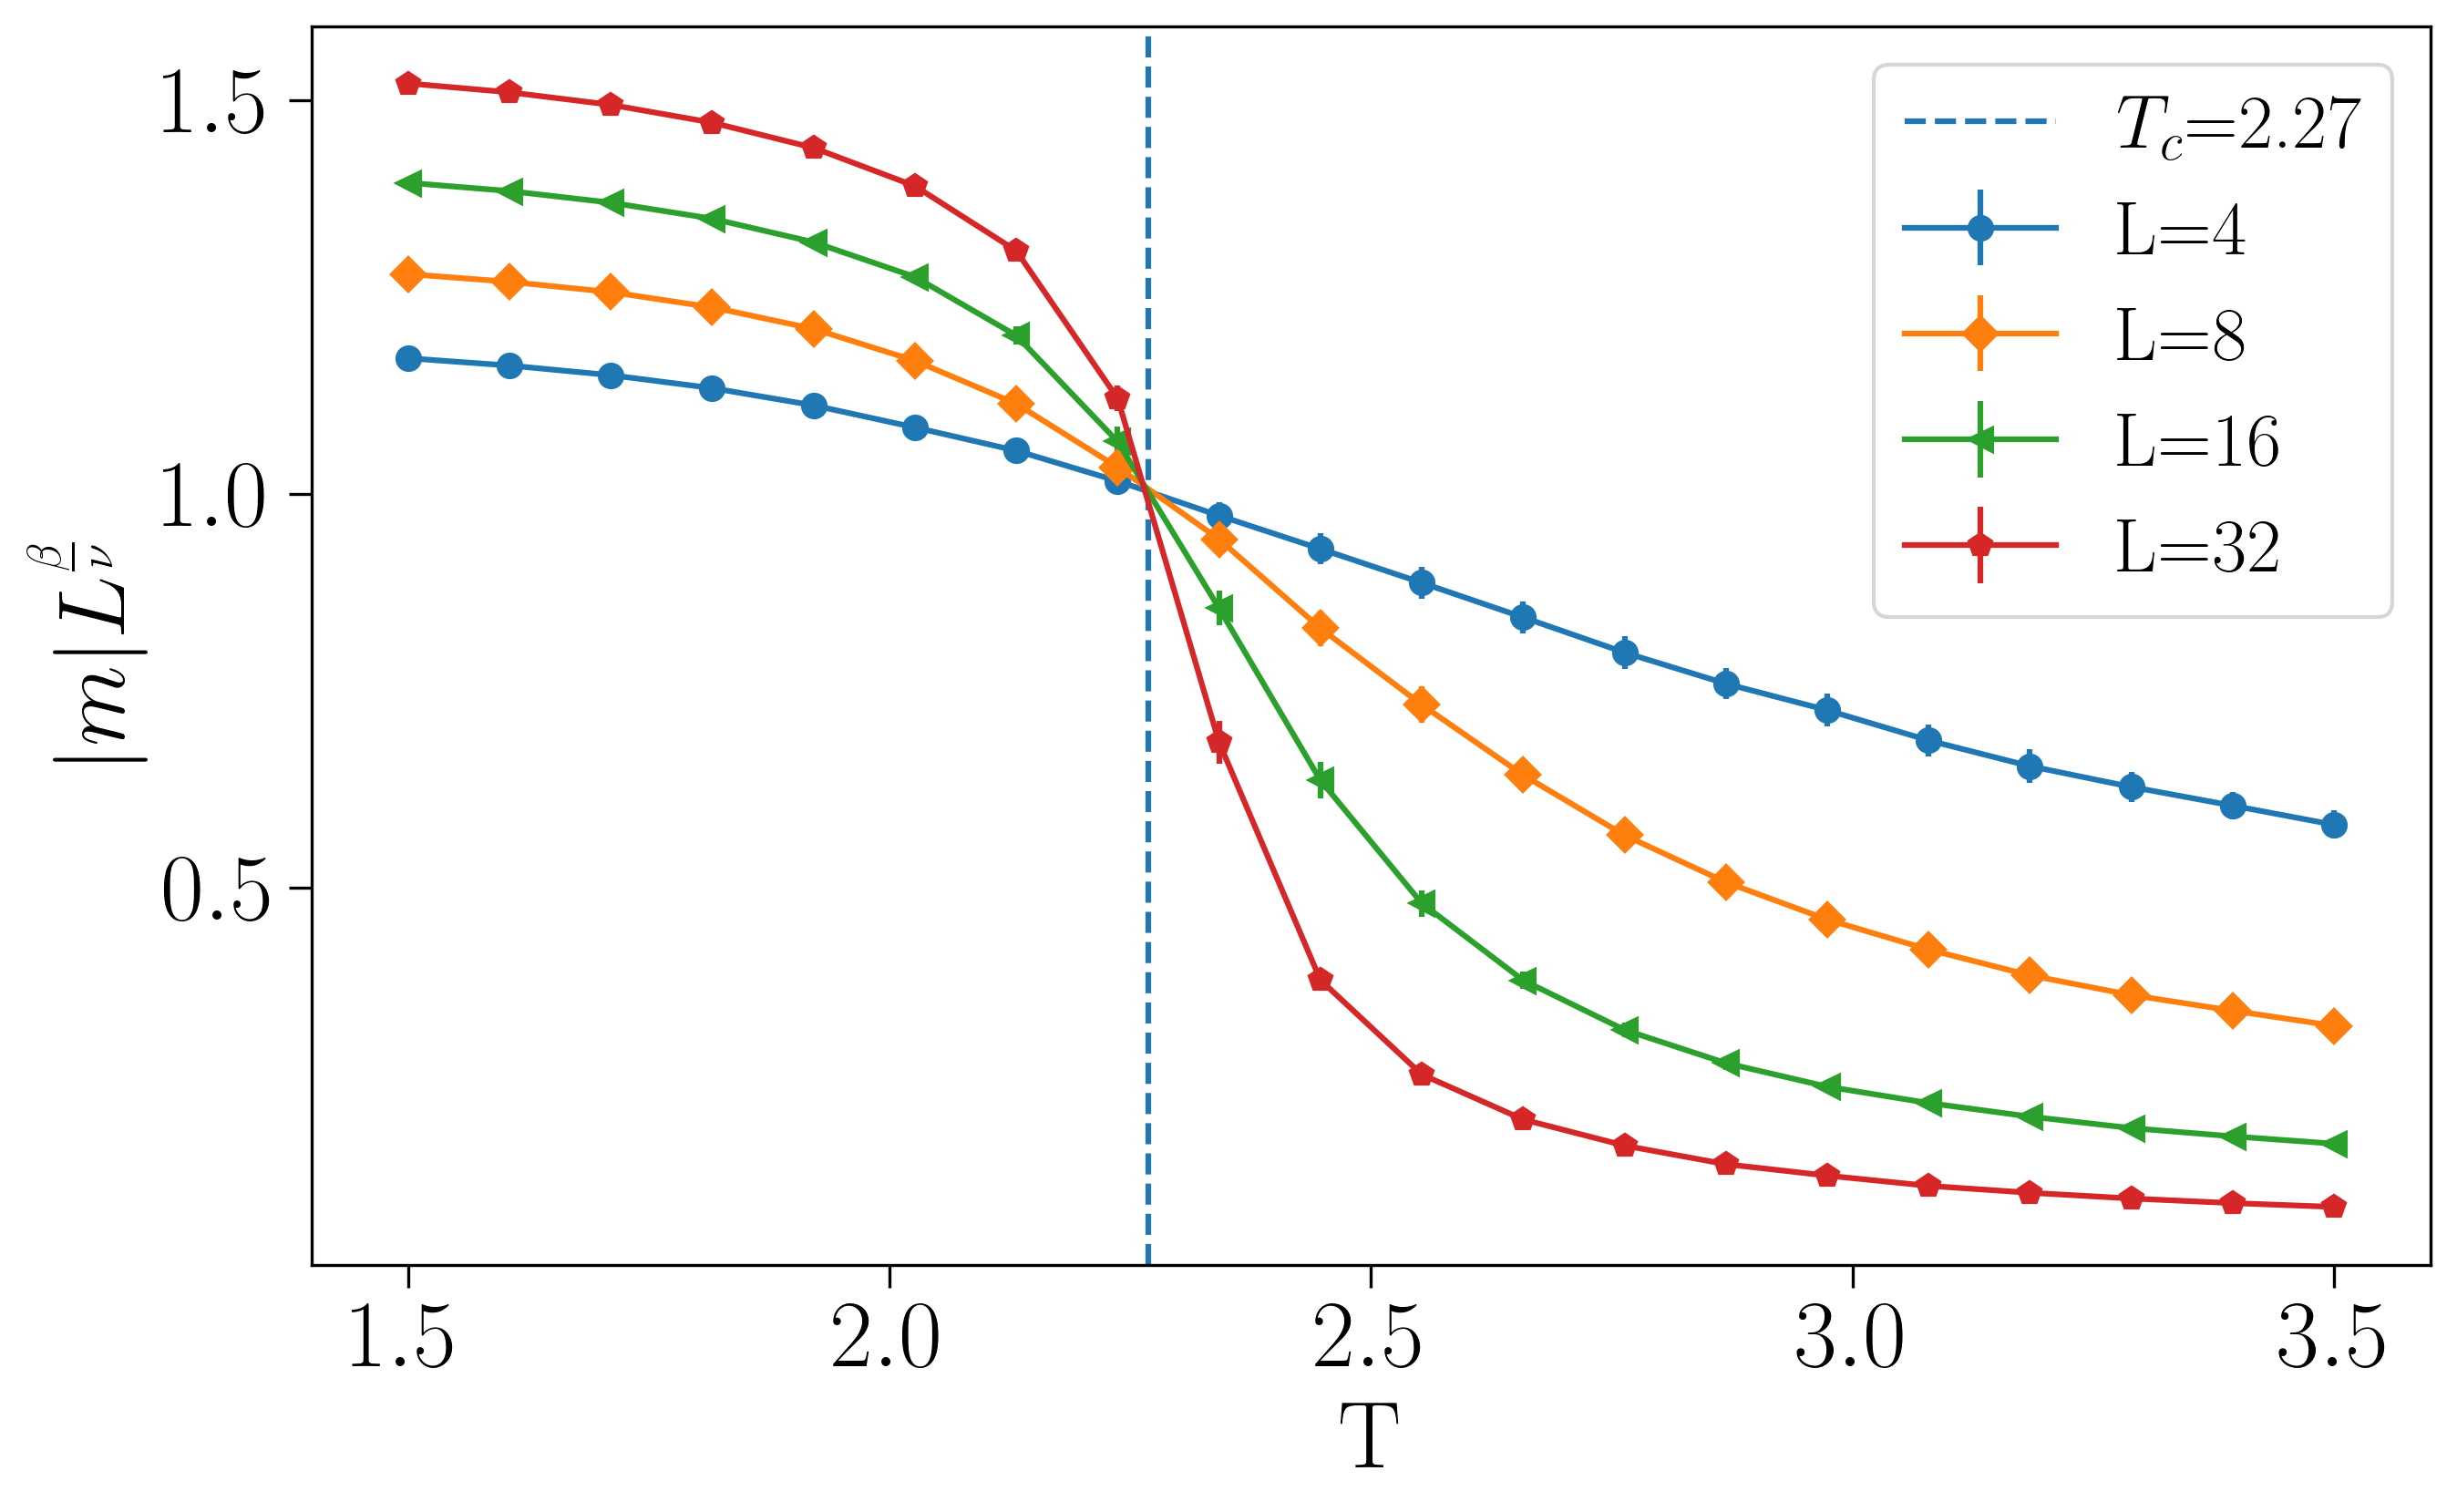

In [303]:
#maximum temperature
tmax = 3.5
#minimum temperature
tmin = 1.5
#number of temperature points
tp = int((tmax-tmin)/0.1)
#temperature
T = np.linspace(tmin,tmax,tp)
T_corr = find_nearest(T, TC)

M_ABS = np.array(M_ABS_SW)
M_ABS_STD = np.array(M_ABS_STD_SW)
L = np.transpose(np.array(L_list))
b_v=1/8

for i in range(len(L_list)):
    plt.errorbar(T, (L[i]**b_v)*M_ABS[i],yerr = (L[i]**b_v)*M_ABS_STD[i],marker=markers[i], linestyle='-',label="L="+str(L_list[i]))
plt.axvline(x=2.269,linestyle = 'dashed', label = fr"$T_c$={round(2.269,2)}")
plt.xlabel("T", fontsize=25) 
plt.ylabel(r"$|m|L^{\frac{\beta}{\nu}}$", fontsize=25)   
plt.legend()
plt.savefig('/Users/johnngan/Desktop/PHYS3999/images/mL_T.pdf', bbox_inches='tight')
plt.show()

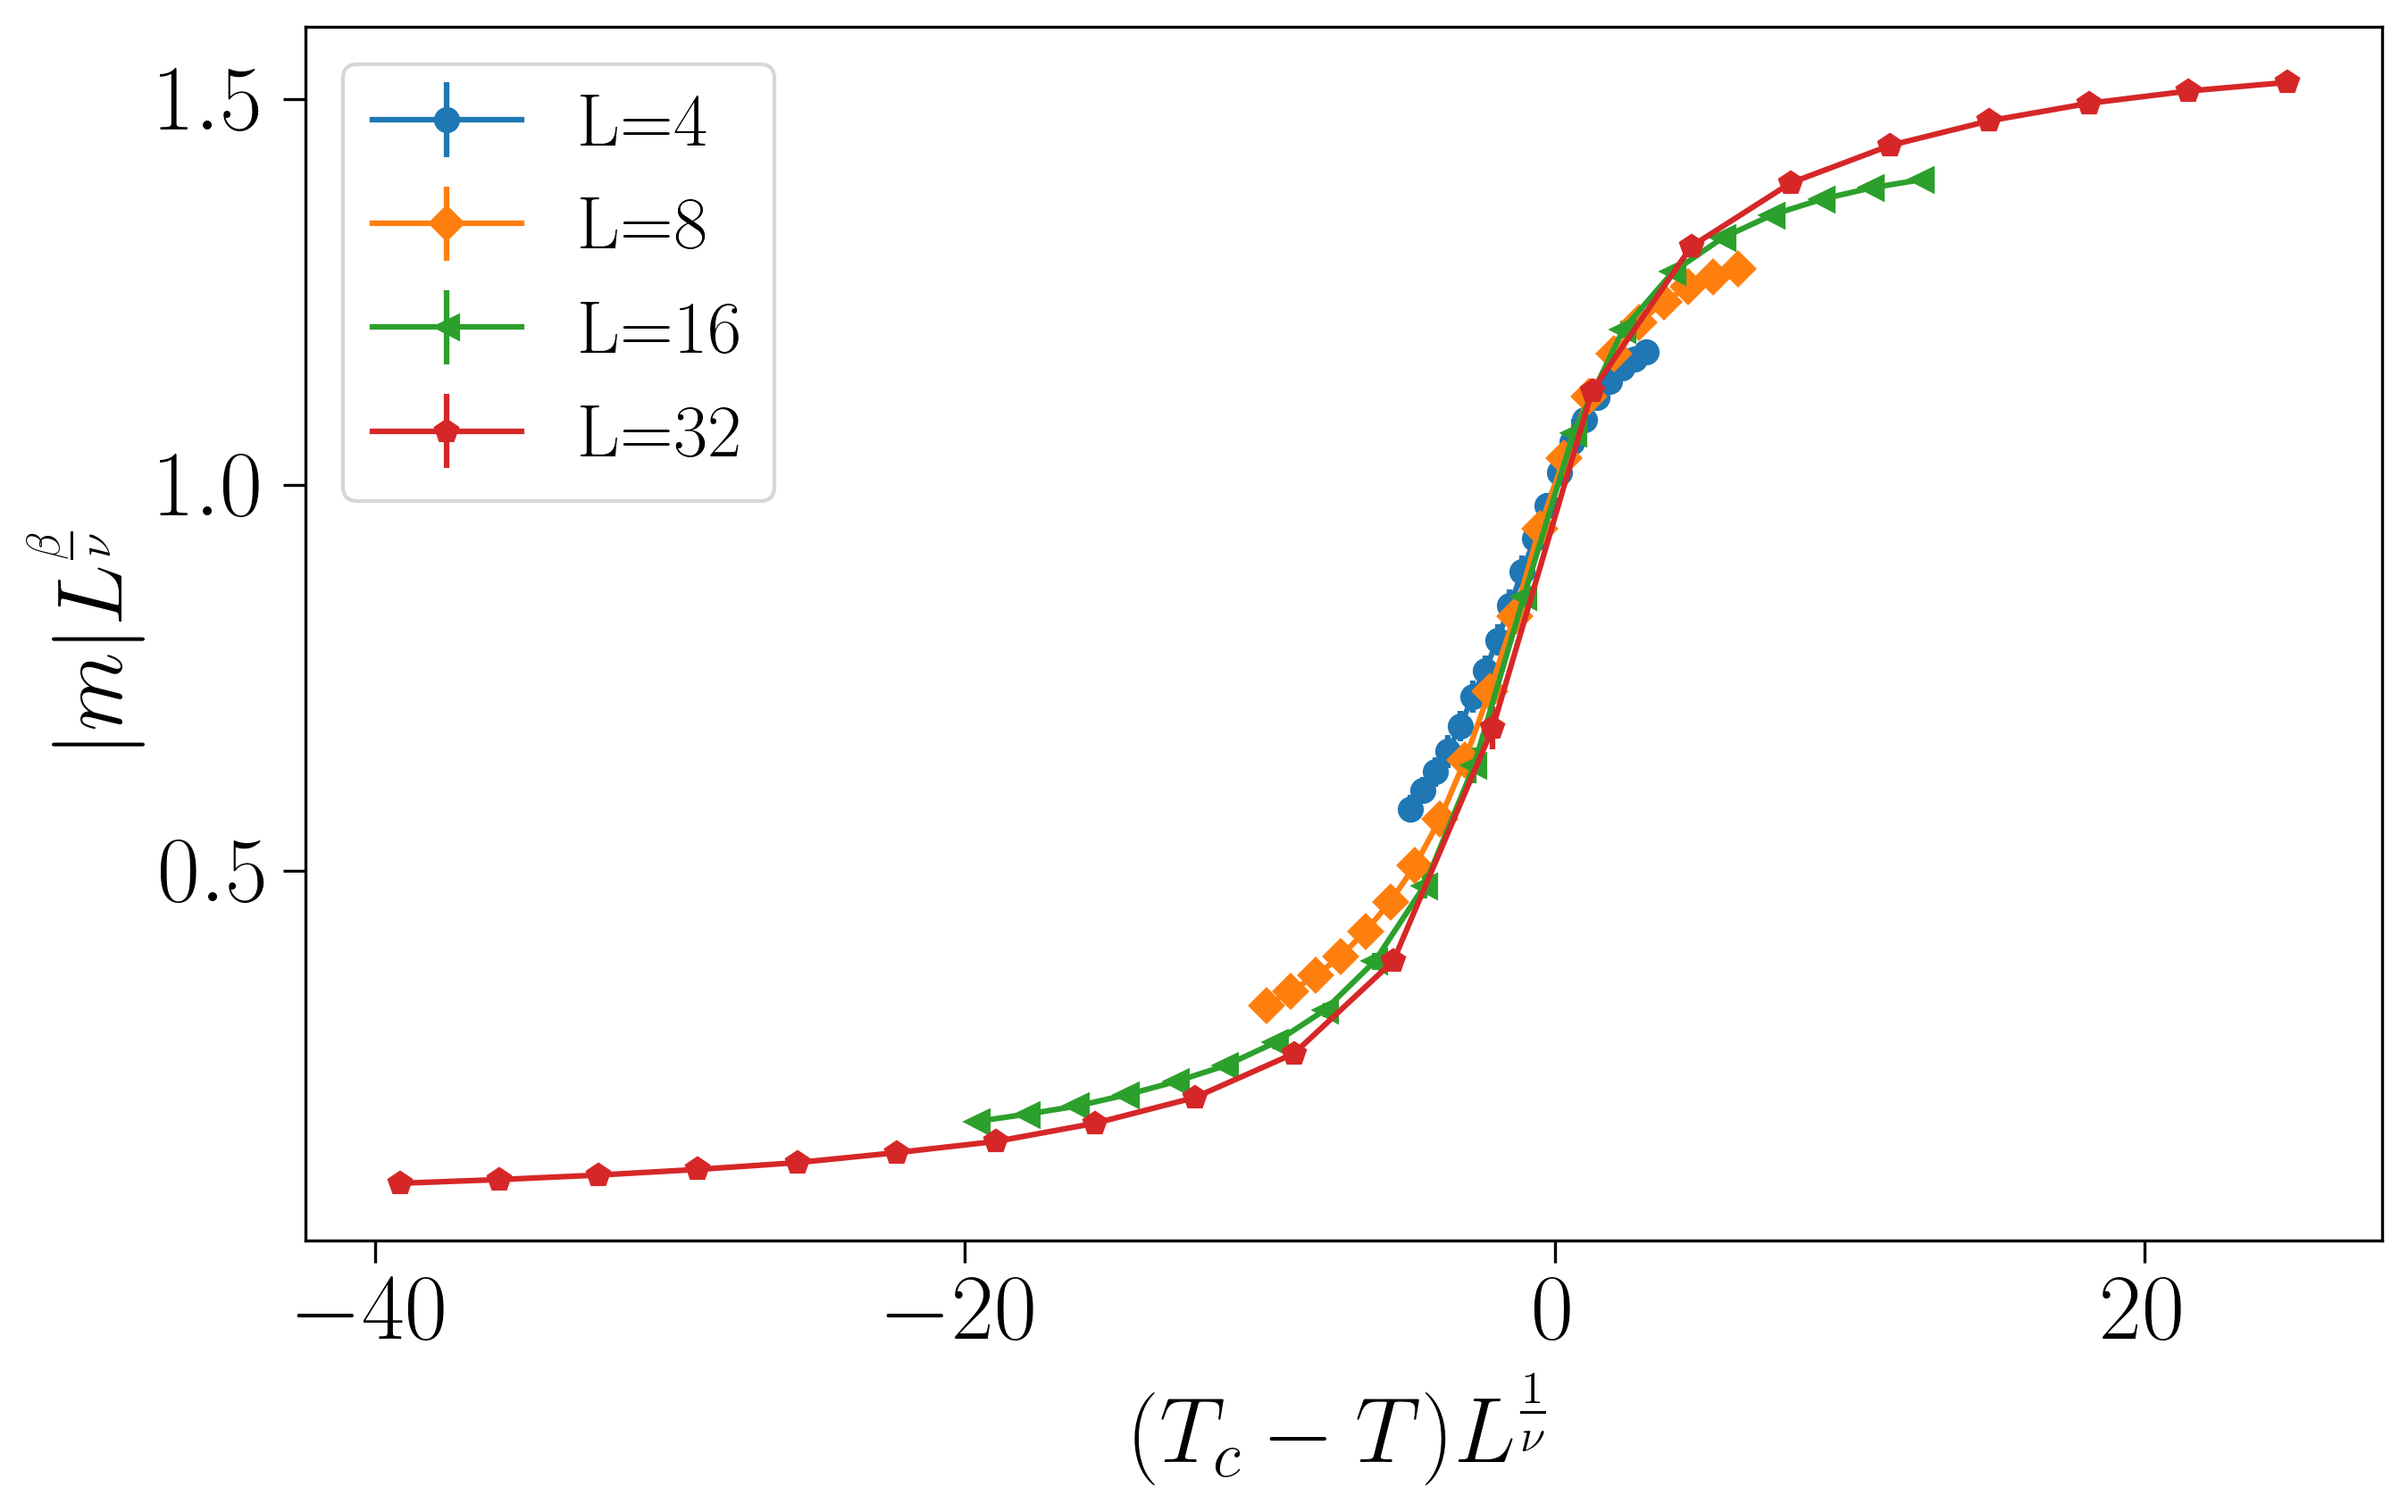

In [286]:
v = 1
for i in range(len(L_list)):
    plt.errorbar((TC-T)*(L[i]**(1/v)), (L[i]**b_v)*M_ABS[i],yerr = (L[i]**b_v)*M_ABS_STD[i],marker=markers[i], linestyle='-',label="L="+str(L_list[i]))
# plt.axvline(x=TC,linestyle = 'dashed', label = fr"$T_c$={round(TC,2)}")
plt.xlabel(r"$(T_{c} - T)L^{\frac{1}{\nu}}$", fontsize=25) 
plt.ylabel(r"$|m|L^{\frac{\beta}{\nu}}$", fontsize=25)   
plt.legend()
plt.savefig('/Users/johnngan/Desktop/PHYS3999/images/mL_tL.pdf', bbox_inches='tight')
plt.show()

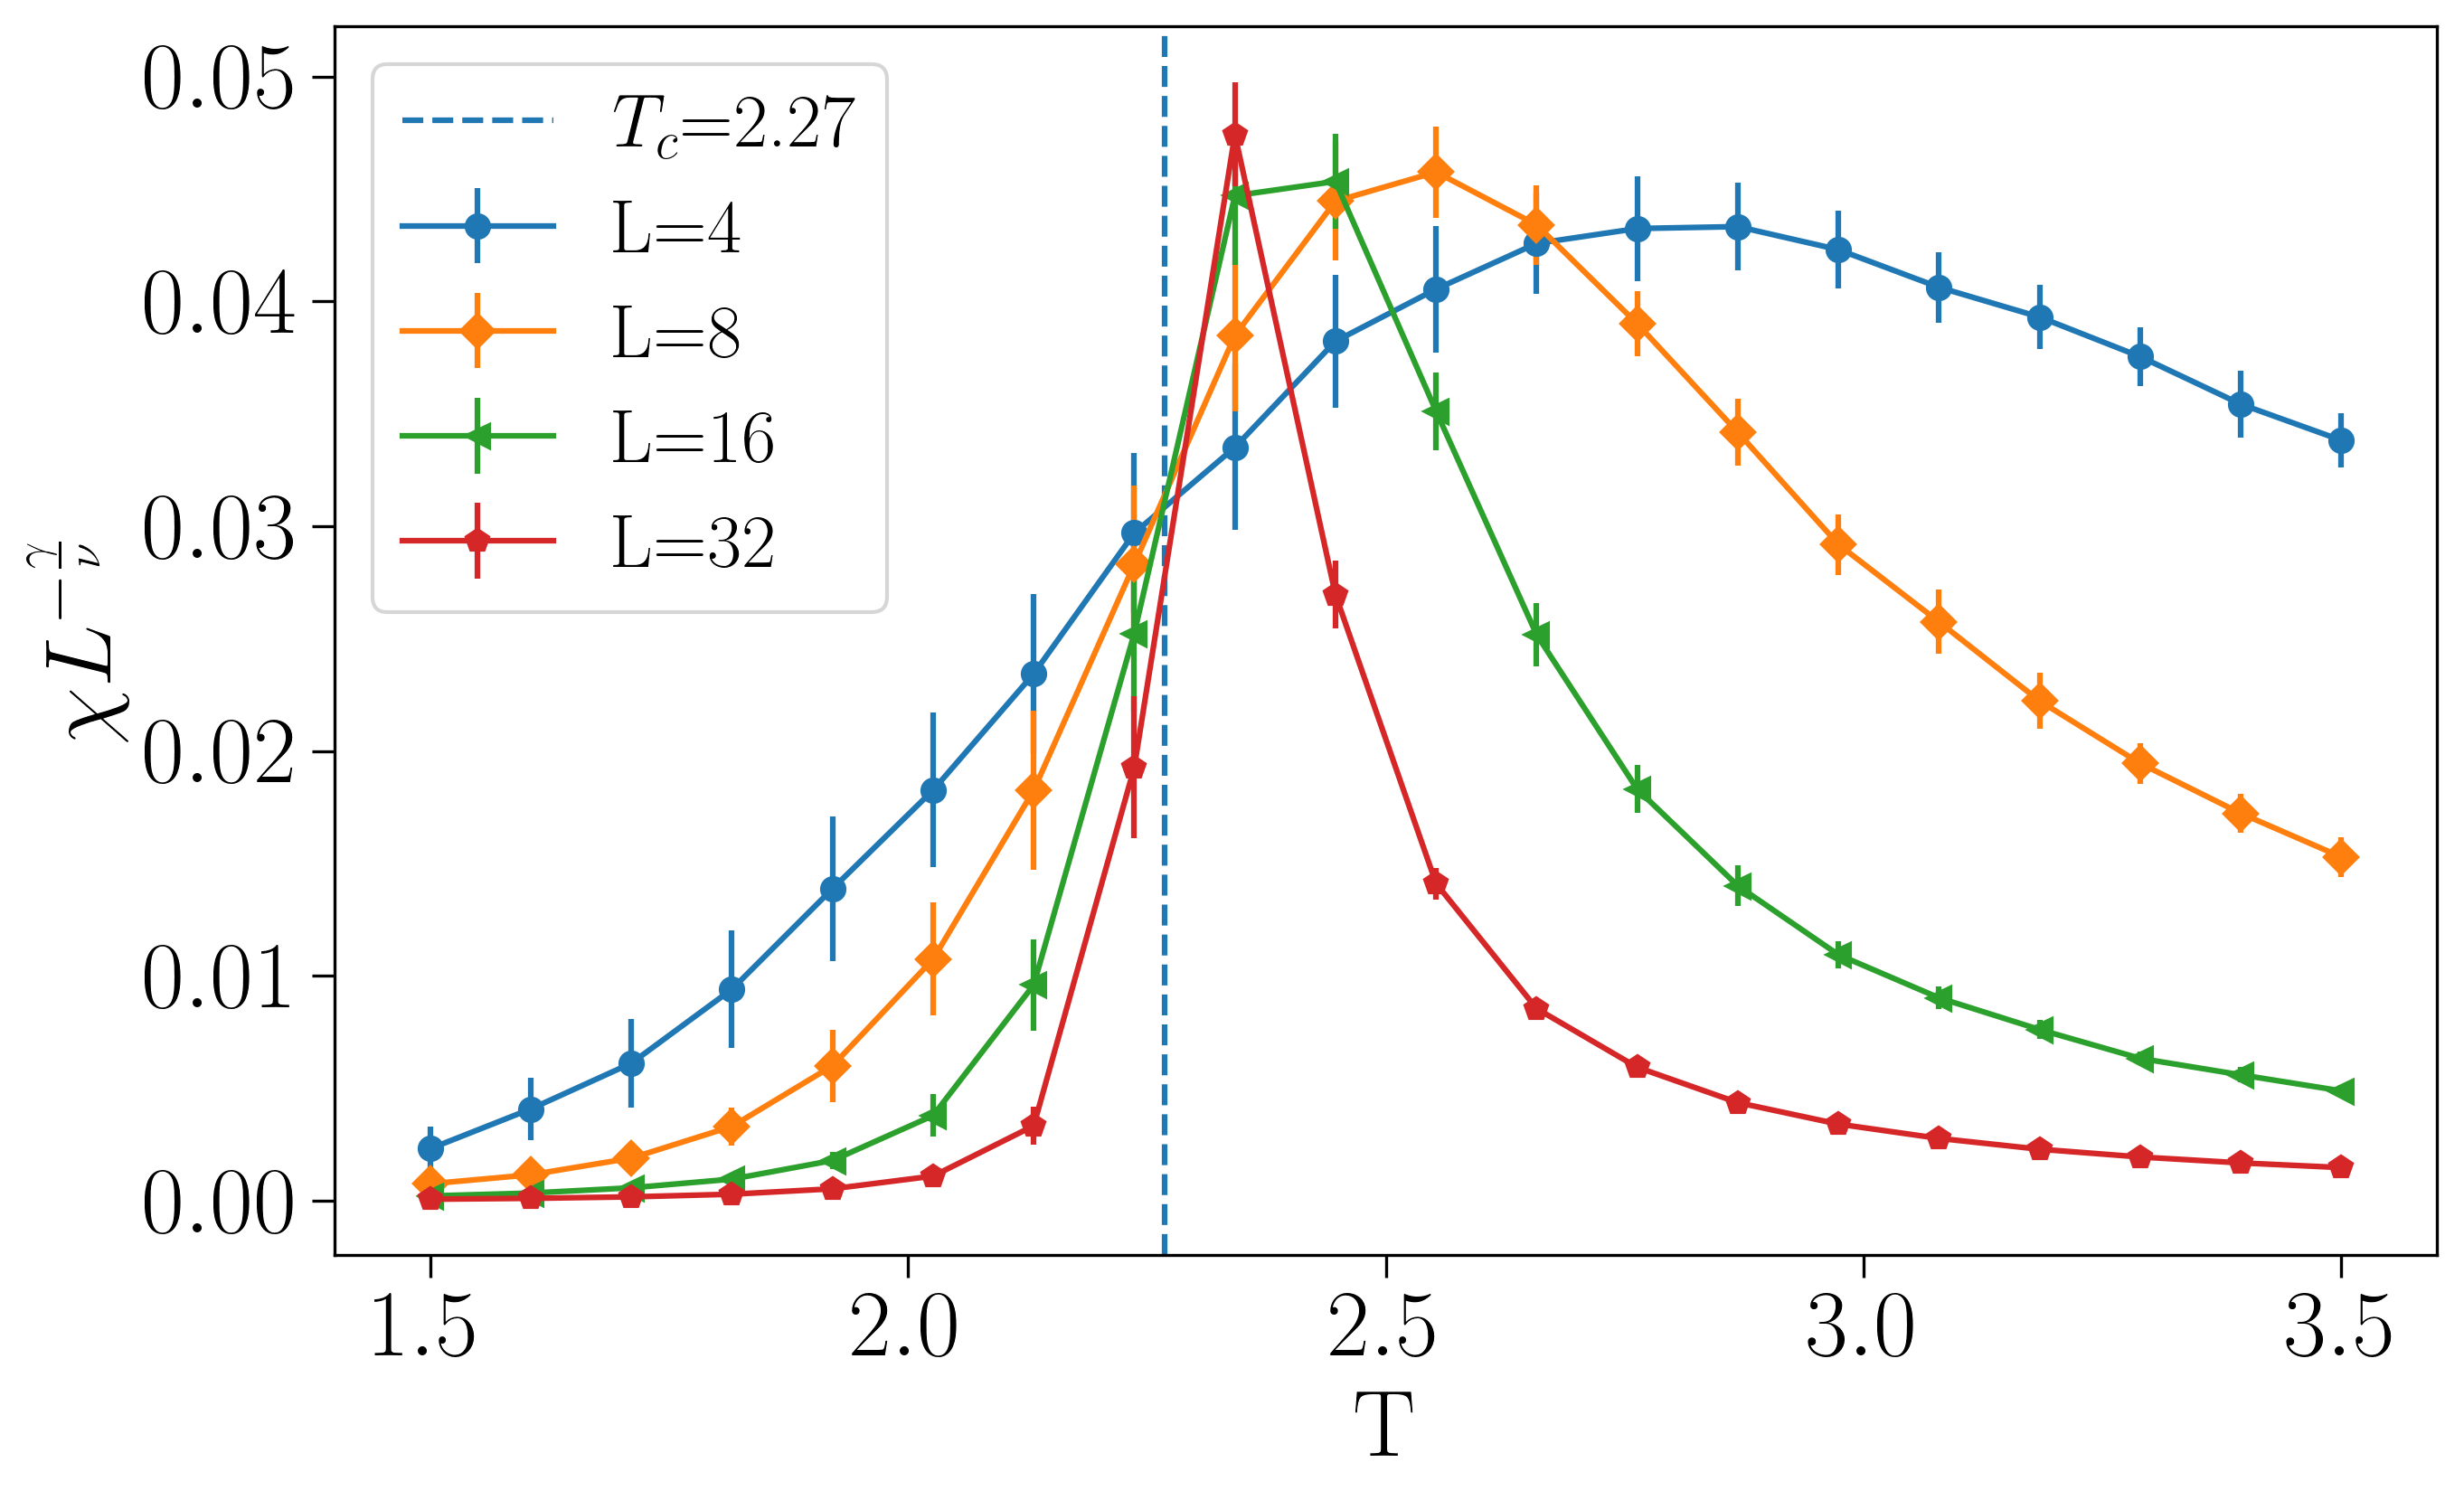

In [271]:
X = np.array(X_SW)
X_STD = np.array(X_STD_SW)
L = np.transpose(np.array(L_list))
g_v=7/4

for i in range(len(L_list)):
    plt.errorbar(T, X[i]/(L[i]**g_v),yerr = X_STD[i]/(L[i]**g_v), marker=markers[i], linestyle='-',label="L="+str(L_list[i]))
plt.axvline(x=2.269,linestyle = 'dashed', label = fr"$T_c$={round(2.269,2)}")
plt.xlabel("T", fontsize=25) 
plt.ylabel(r"$\chi L^{-\frac{\gamma}{\nu}} $", fontsize=25)   
plt.legend()
plt.savefig('/Users/johnngan/Desktop/PHYS3999/images/XL_T.pdf', bbox_inches='tight')
plt.show()

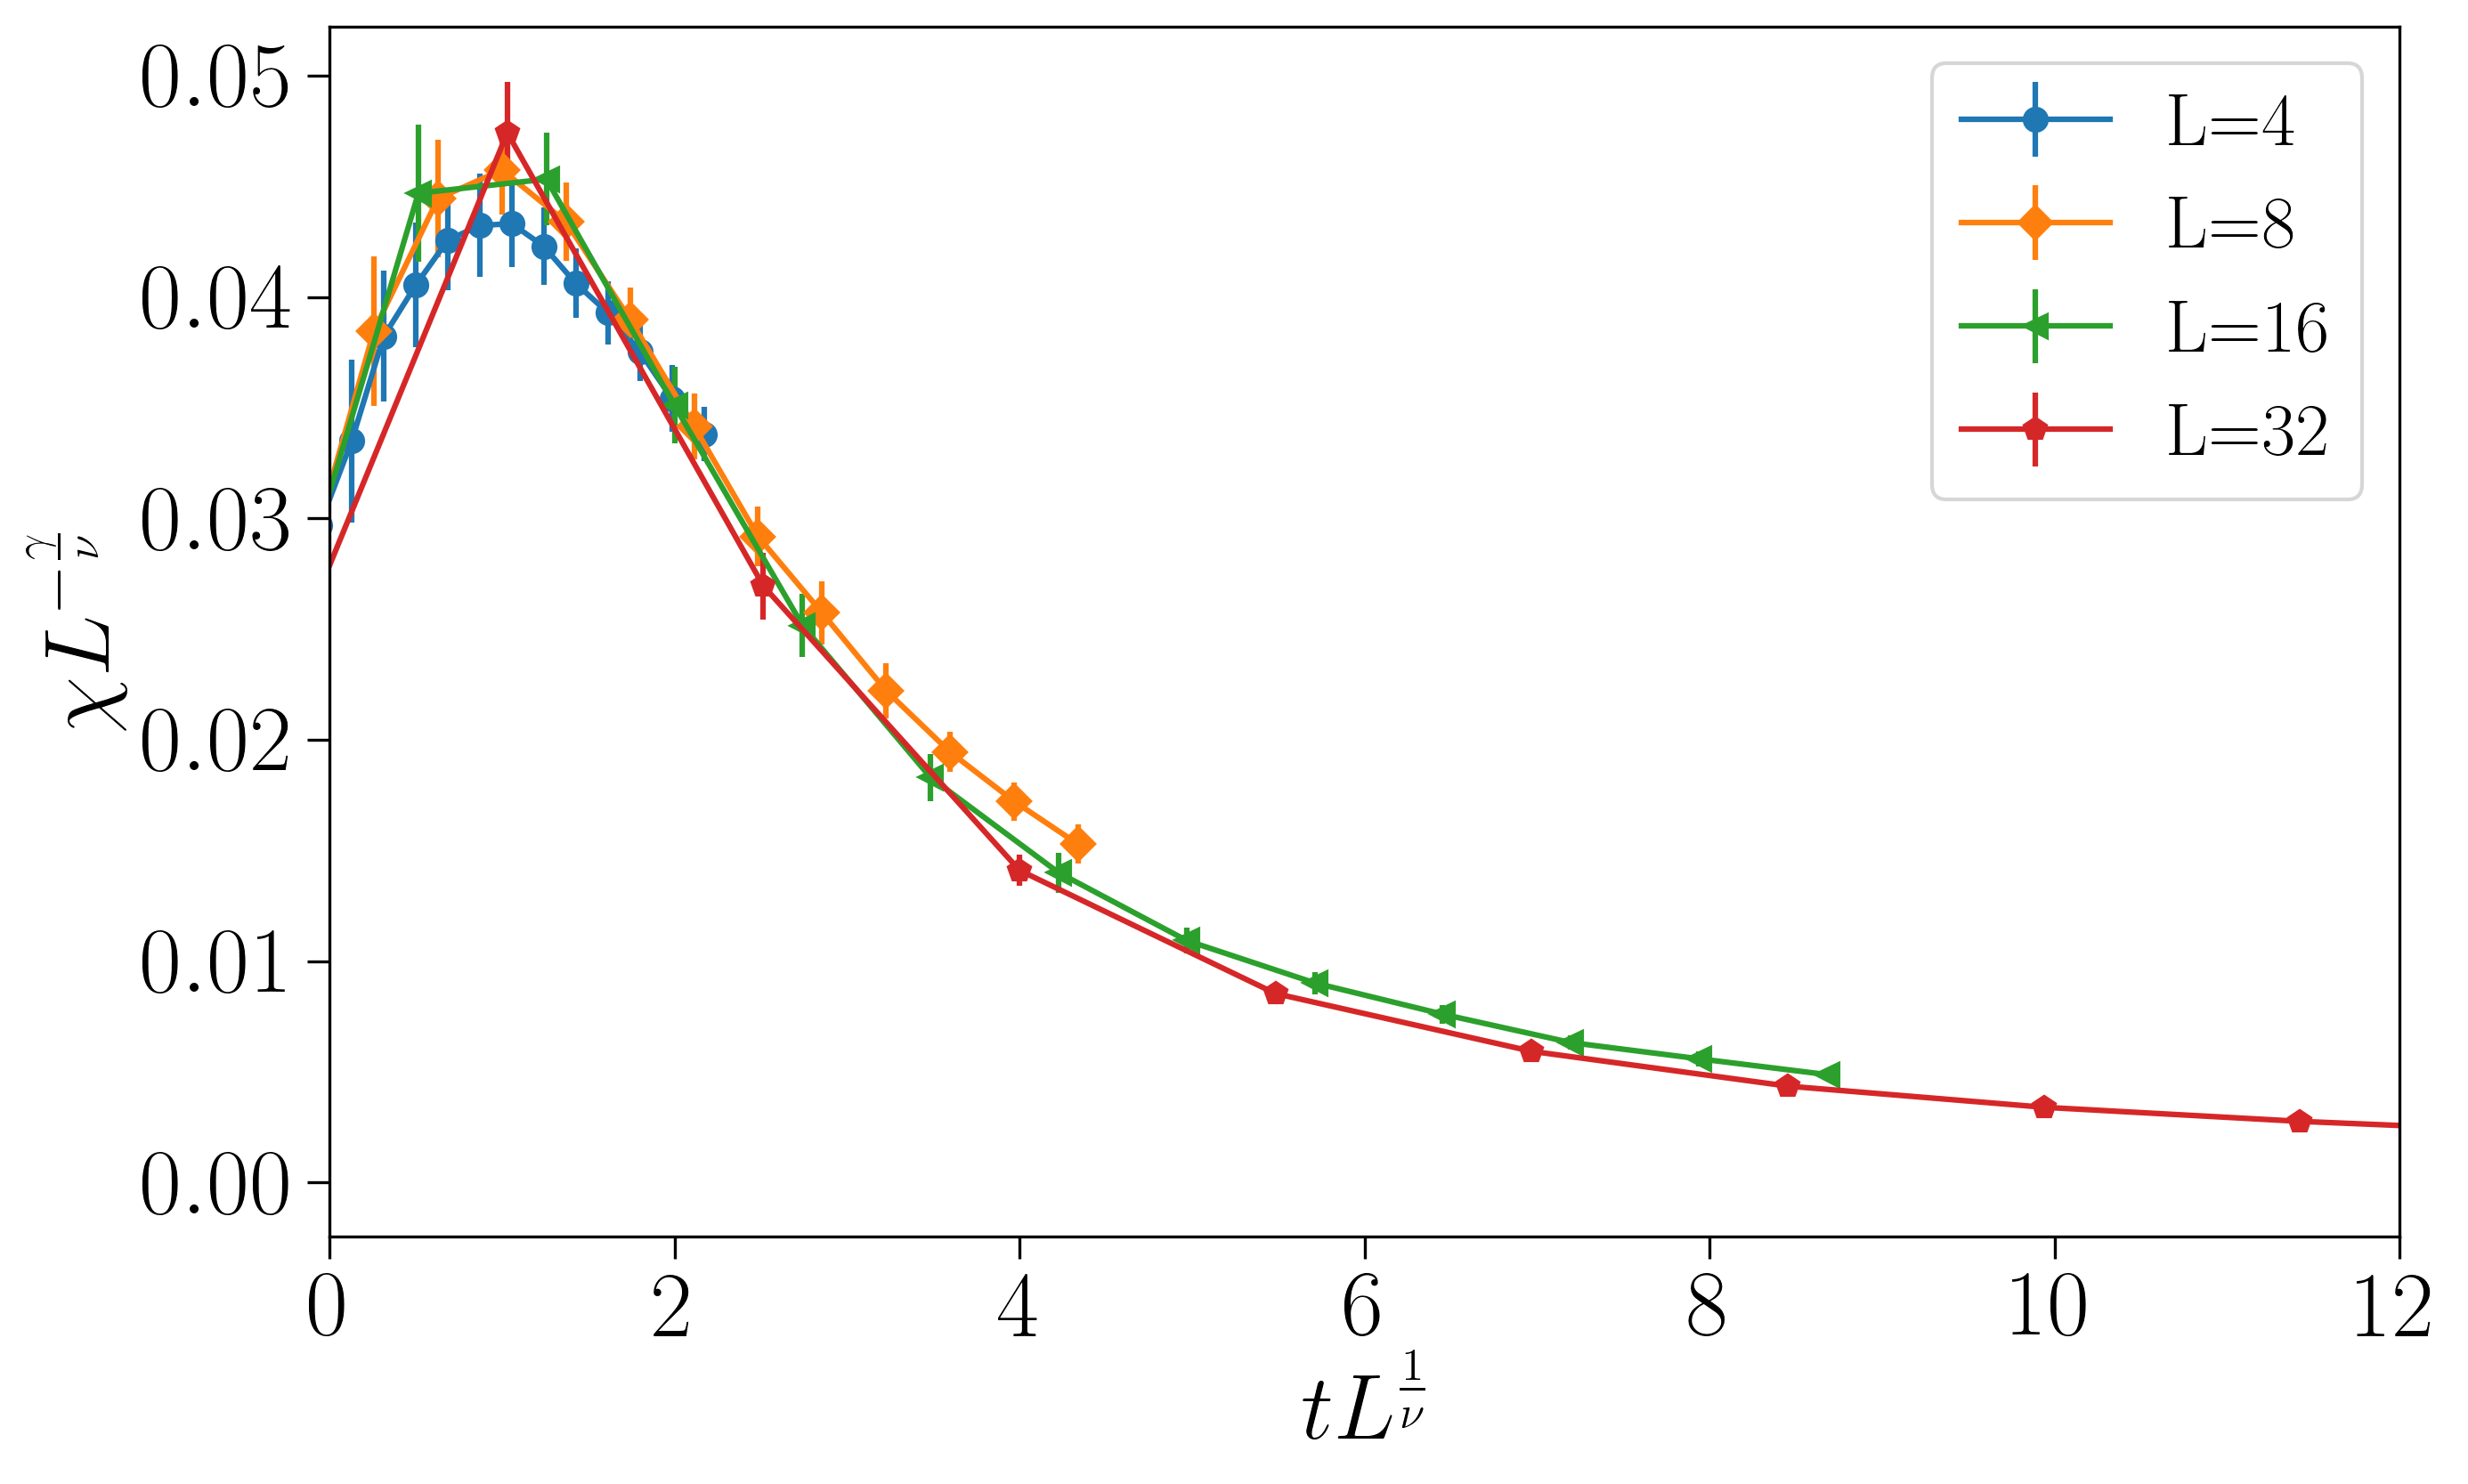

In [272]:
v=1
for i in range(len(L_list)):
    plt.errorbar(((T-2.269)/2.269)*(L[i]**(1/v)), X[i]/(L[i]**g_v),yerr = X_STD[i]/(L[i]**g_v),marker=markers[i], linestyle='-',label="L="+str(L_list[i]))
# plt.axvline(x=TC,linestyle = 'dashed', label = fr"$T_c$={round(TC,2)}")
plt.xlabel(r"$t L^{\frac{1}{\nu}}$", fontsize=25) 
plt.ylabel(r"$\chi L^{-\frac{\gamma}{\nu}} $", fontsize=25)   
plt.xlim(0,12)
plt.legend()
plt.savefig('/Users/johnngan/Desktop/PHYS3999/images/XL_tL.pdf', bbox_inches='tight')
plt.show()

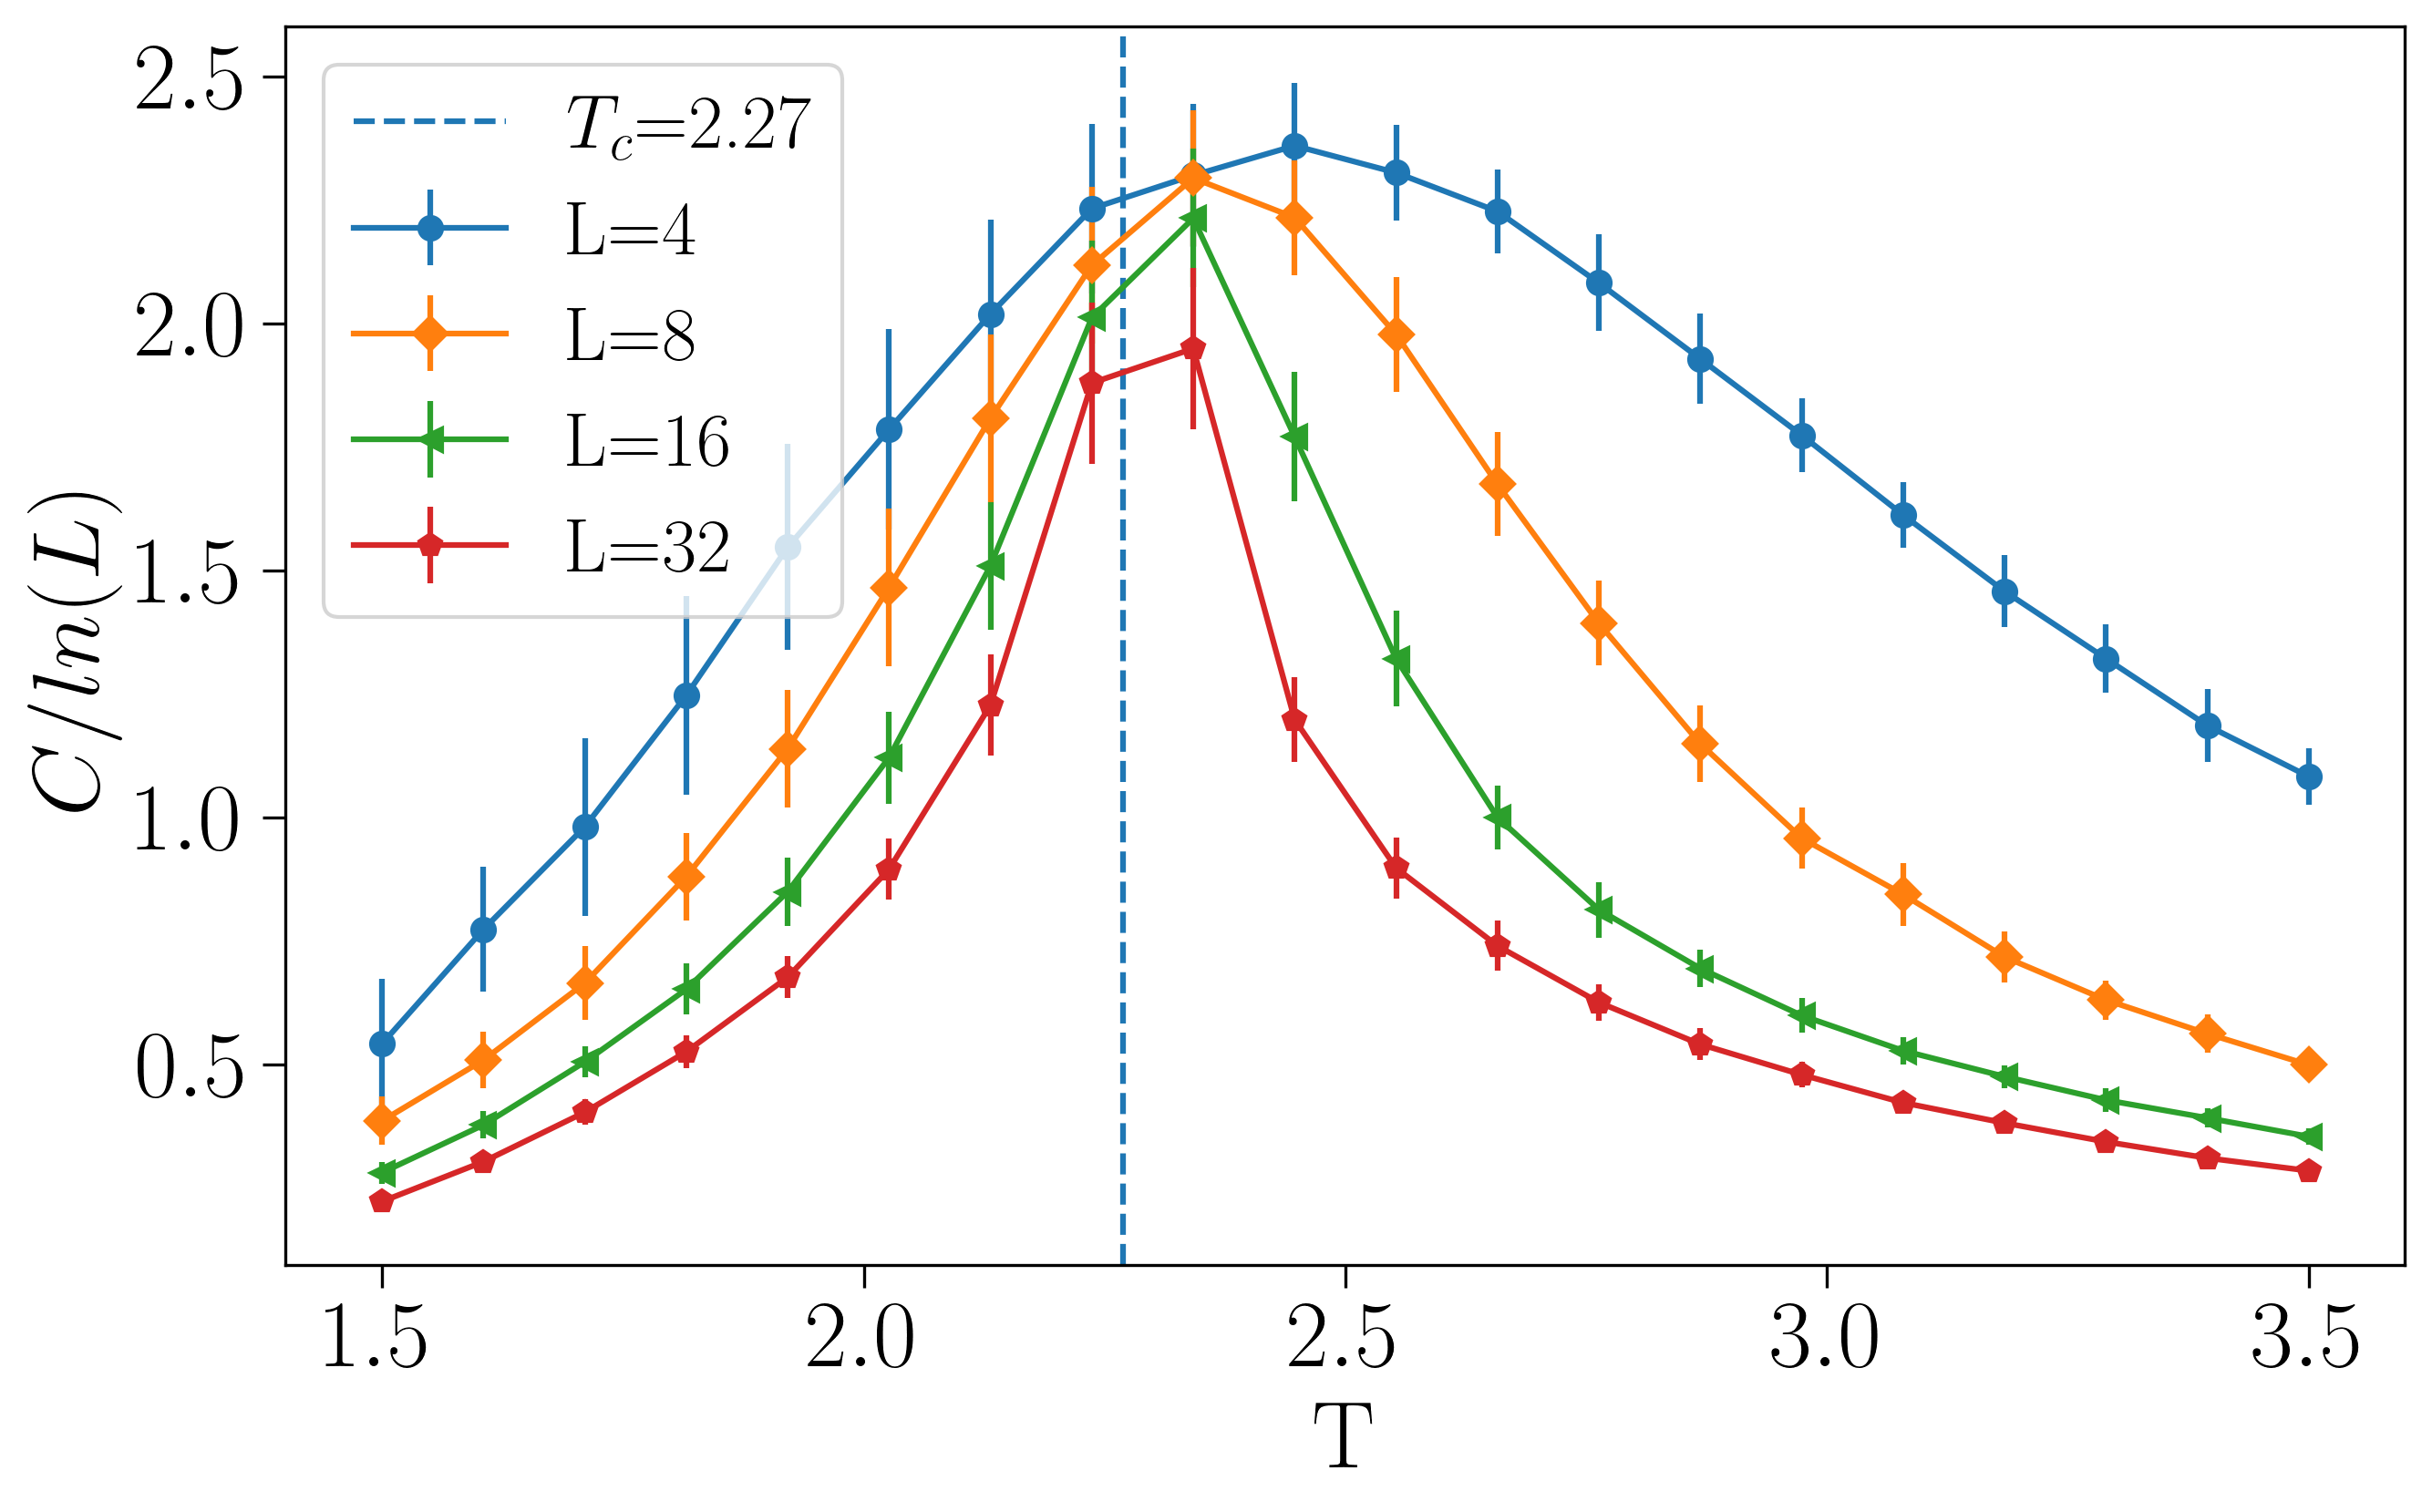

In [273]:
C=np.array(C_SW)
C_STD=np.array(C_STD_SW)
for i in range(len(L_list)):
    plt.errorbar(T, C[i]/np.log(L[i]),yerr = C_STD[i]/np.log(L[i]),marker=markers[i], linestyle='-',label="L="+str(L_list[i]))
plt.axvline(x=2.269,linestyle = 'dashed', label = fr"$T_c$={round(2.269,2)}")
plt.xlabel("T", fontsize=25) 
plt.ylabel(r"$C / ln(L)$", fontsize=25)   
plt.legend()
plt.savefig('/Users/johnngan/Desktop/PHYS3999/images/CL_T.pdf', bbox_inches='tight')
plt.show()

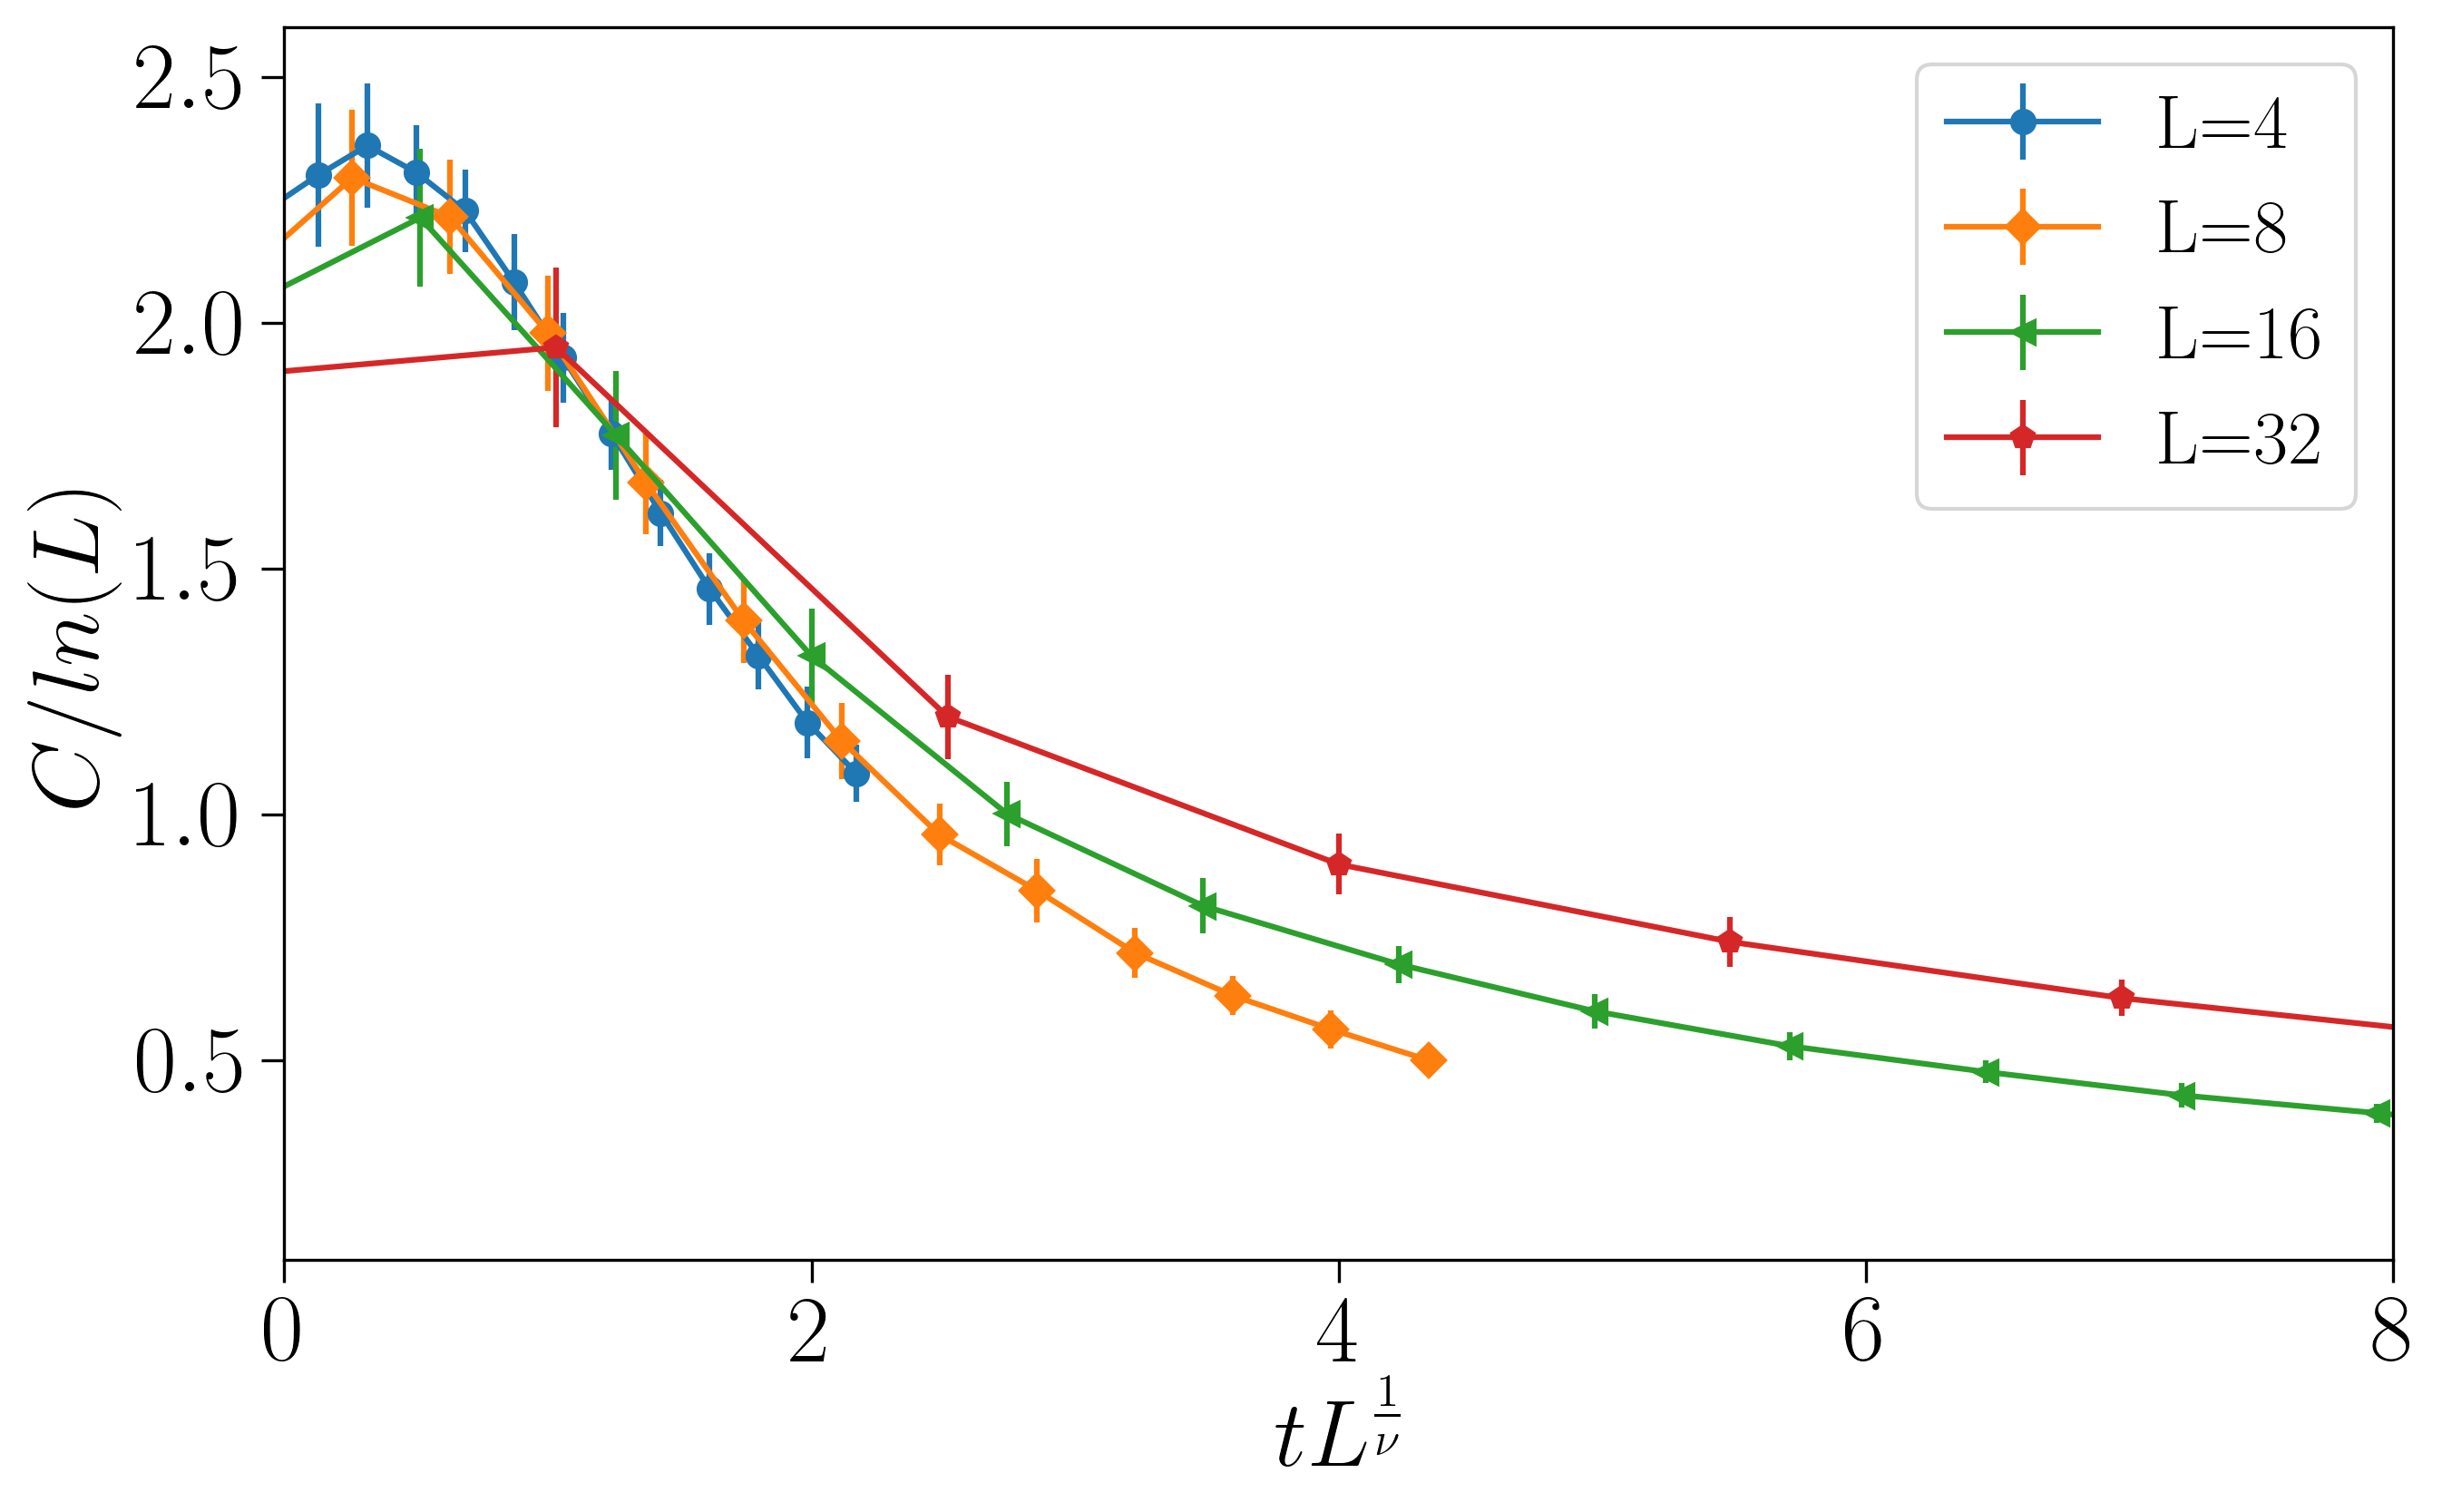

In [279]:
for i in range(len(L_list)):
    plt.errorbar(((T-2.269)/2.269)*(L[i]**(1/v)), C[i]/np.log(L[i]),yerr = C_STD[i]/np.log(L[i]),marker=markers[i], linestyle='-',label="L="+str(L_list[i]))
#plt.axvline(x=TC,linestyle = 'dashed', label = fr"$T_c$={round(TC,2)}")
plt.xlabel(r"$t L^{\frac{1}{\nu}}$", fontsize=25) 
plt.ylabel(r"$C / ln(L)$", fontsize=25) 
plt.xlim(0,8)
plt.legend()
plt.savefig('/Users/johnngan/Desktop/PHYS3999/images/CL_tL.pdf', bbox_inches='tight')
plt.show()

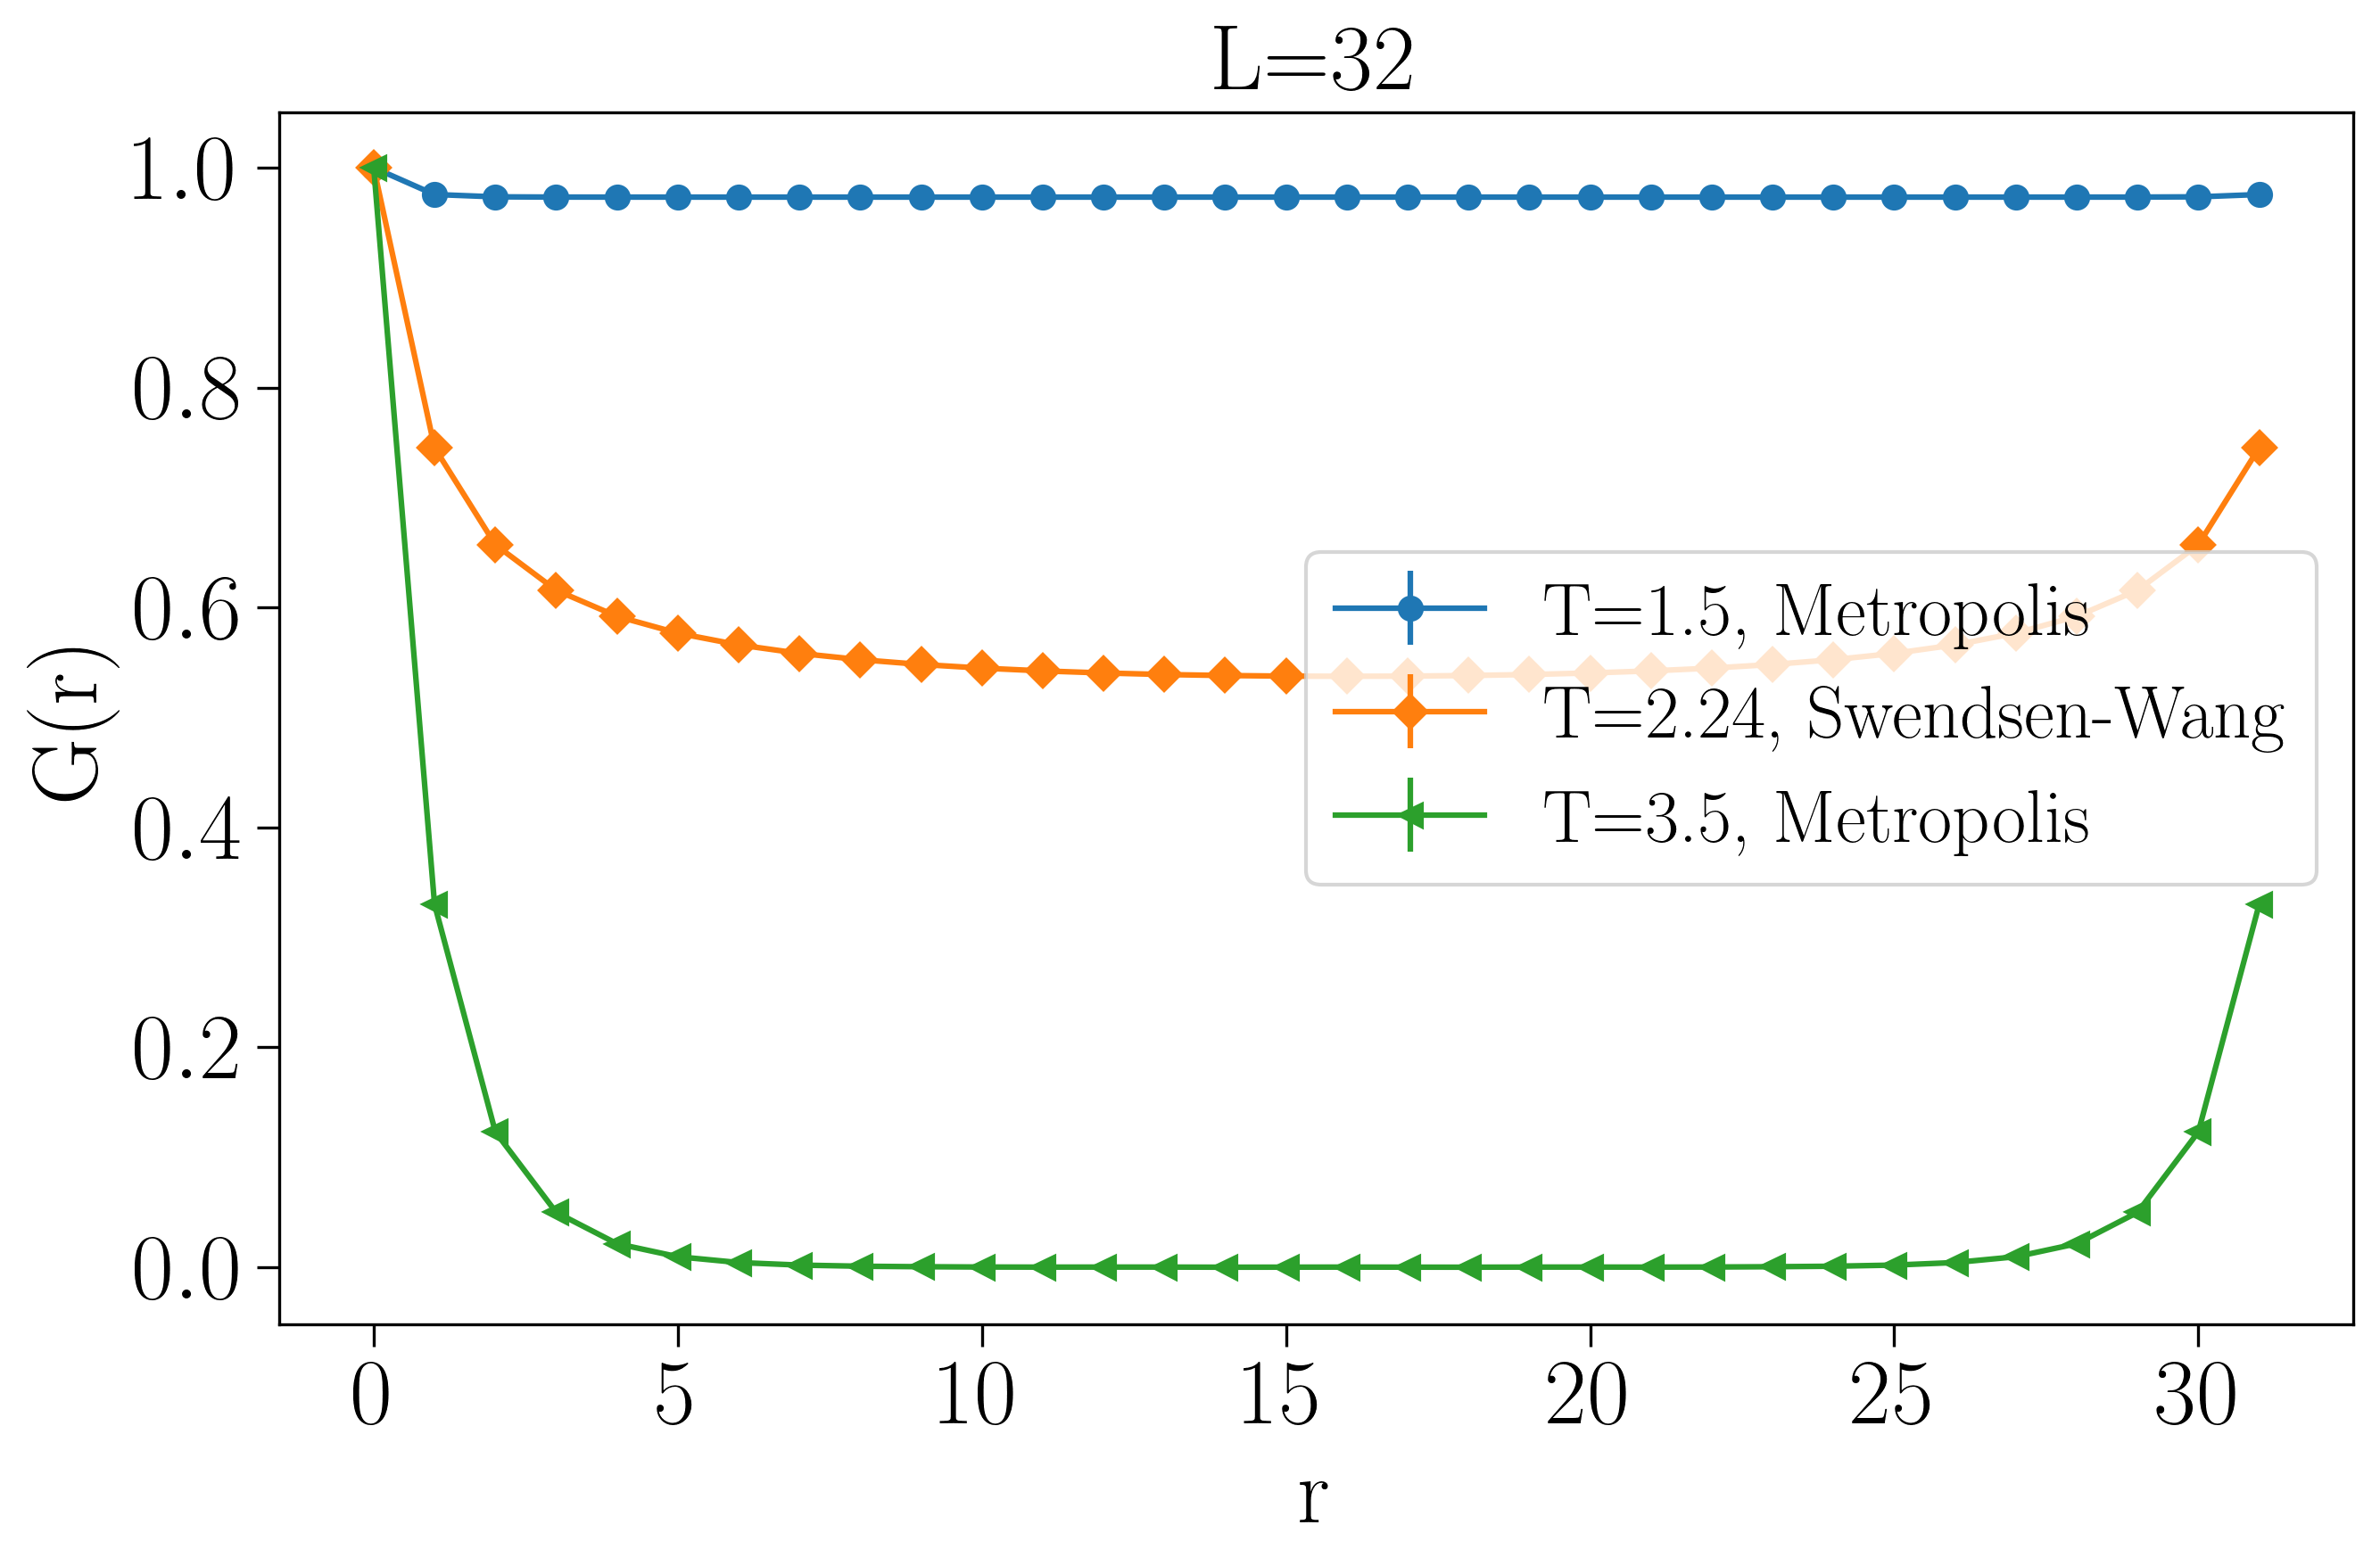

In [297]:
plt.errorbar(list(range(L_list[-1])), G_M[-1][0],yerr = G_STD_M[-1][0],marker=markers[0], linestyle='-',label=f"T={tmin}, Metropolis")
plt.errorbar(list(range(L_list[-1])), G_SW[-1][1],yerr = G_STD_SW[-1][1],marker=markers[1], linestyle='-',label=f"T={round(T_corr,2)}, Swendsen-Wang")
plt.errorbar(list(range(L_list[-1])), G_M[-1][2],yerr = G_STD_M[-1][2],marker=markers[2], linestyle='-',label=f"T={tmax}, Metropolis")
plt.xlabel("r", fontsize=25) 
plt.ylabel("G(r)", fontsize=25) 
plt.title(f"L={L_list[-1]}", fontsize=25)
#plt.xscale("log")
#plt.yscale("log")
plt.legend(loc="center right")
plt.savefig('/Users/johnngan/Desktop/PHYS3999/images/G_r.pdf', bbox_inches='tight')
plt.show()

In [111]:
import matplotlib.pyplot as plt
%matplotlib inline

def Q3(L_list, Mcstep, t1):
    Equstep=1000
    G_corr_expect_L=[]
    G_corr_std_L=[]
    for L in L_list:
        #print("L = " + str(L))
        #record start time of the loop
        #start_time = time.time()
        #size of the configuration
        N = L*L
        
        G_corr_expect = []
        
        init_state = lattice(L)  
        for j in range(Equstep):
            MC = SwendsenWang(init_state,L,t1)
        G_corr_list = []
        
        for k in range(Mcstep):
            MC = SwendsenWang(init_state,L,t1)
            G_corr_list.append(Correlation(MC,L))
                
            if k%(Mcstep/100) ==0 and k!=0:
                G_corr_expect.append(np.mean(G_corr_list, axis =0))
                G_corr_list = []
                #print(f"{k} steps finished")          

        #<C(r)> of target temperature
        G_corr_expect_L.append(np.mean(G_corr_expect, axis=0))
        #standard deviation of C(r) of target temperature
        G_corr_std_L.append(np.std(G_corr_expect, axis=0, ddof = 1))
        #time used for the loop for each L
        #print("computing time for L="+str(L)+": %s seconds" % (time.time() - start_time))    

    for i in range(len(L_list)):
        plt.errorbar(np.arange(L_list[i]), G_corr_expect_L[i], G_corr_std_L[i], fmt=markers[i], markersize=3,label="L="+str(L_list[i]))
    plt.xlabel("r", fontsize=25) 
    plt.ylabel("G(r)", fontsize=25)

    #plt.title(f"Autocorrelation function at T = {round(t1,2)} of Swendsen-Wang algorithm", fontsize=25)
    #plt.yscale("log")
    plt.legend()
    plt.show()
    return G_corr_expect_L, G_corr_std_L

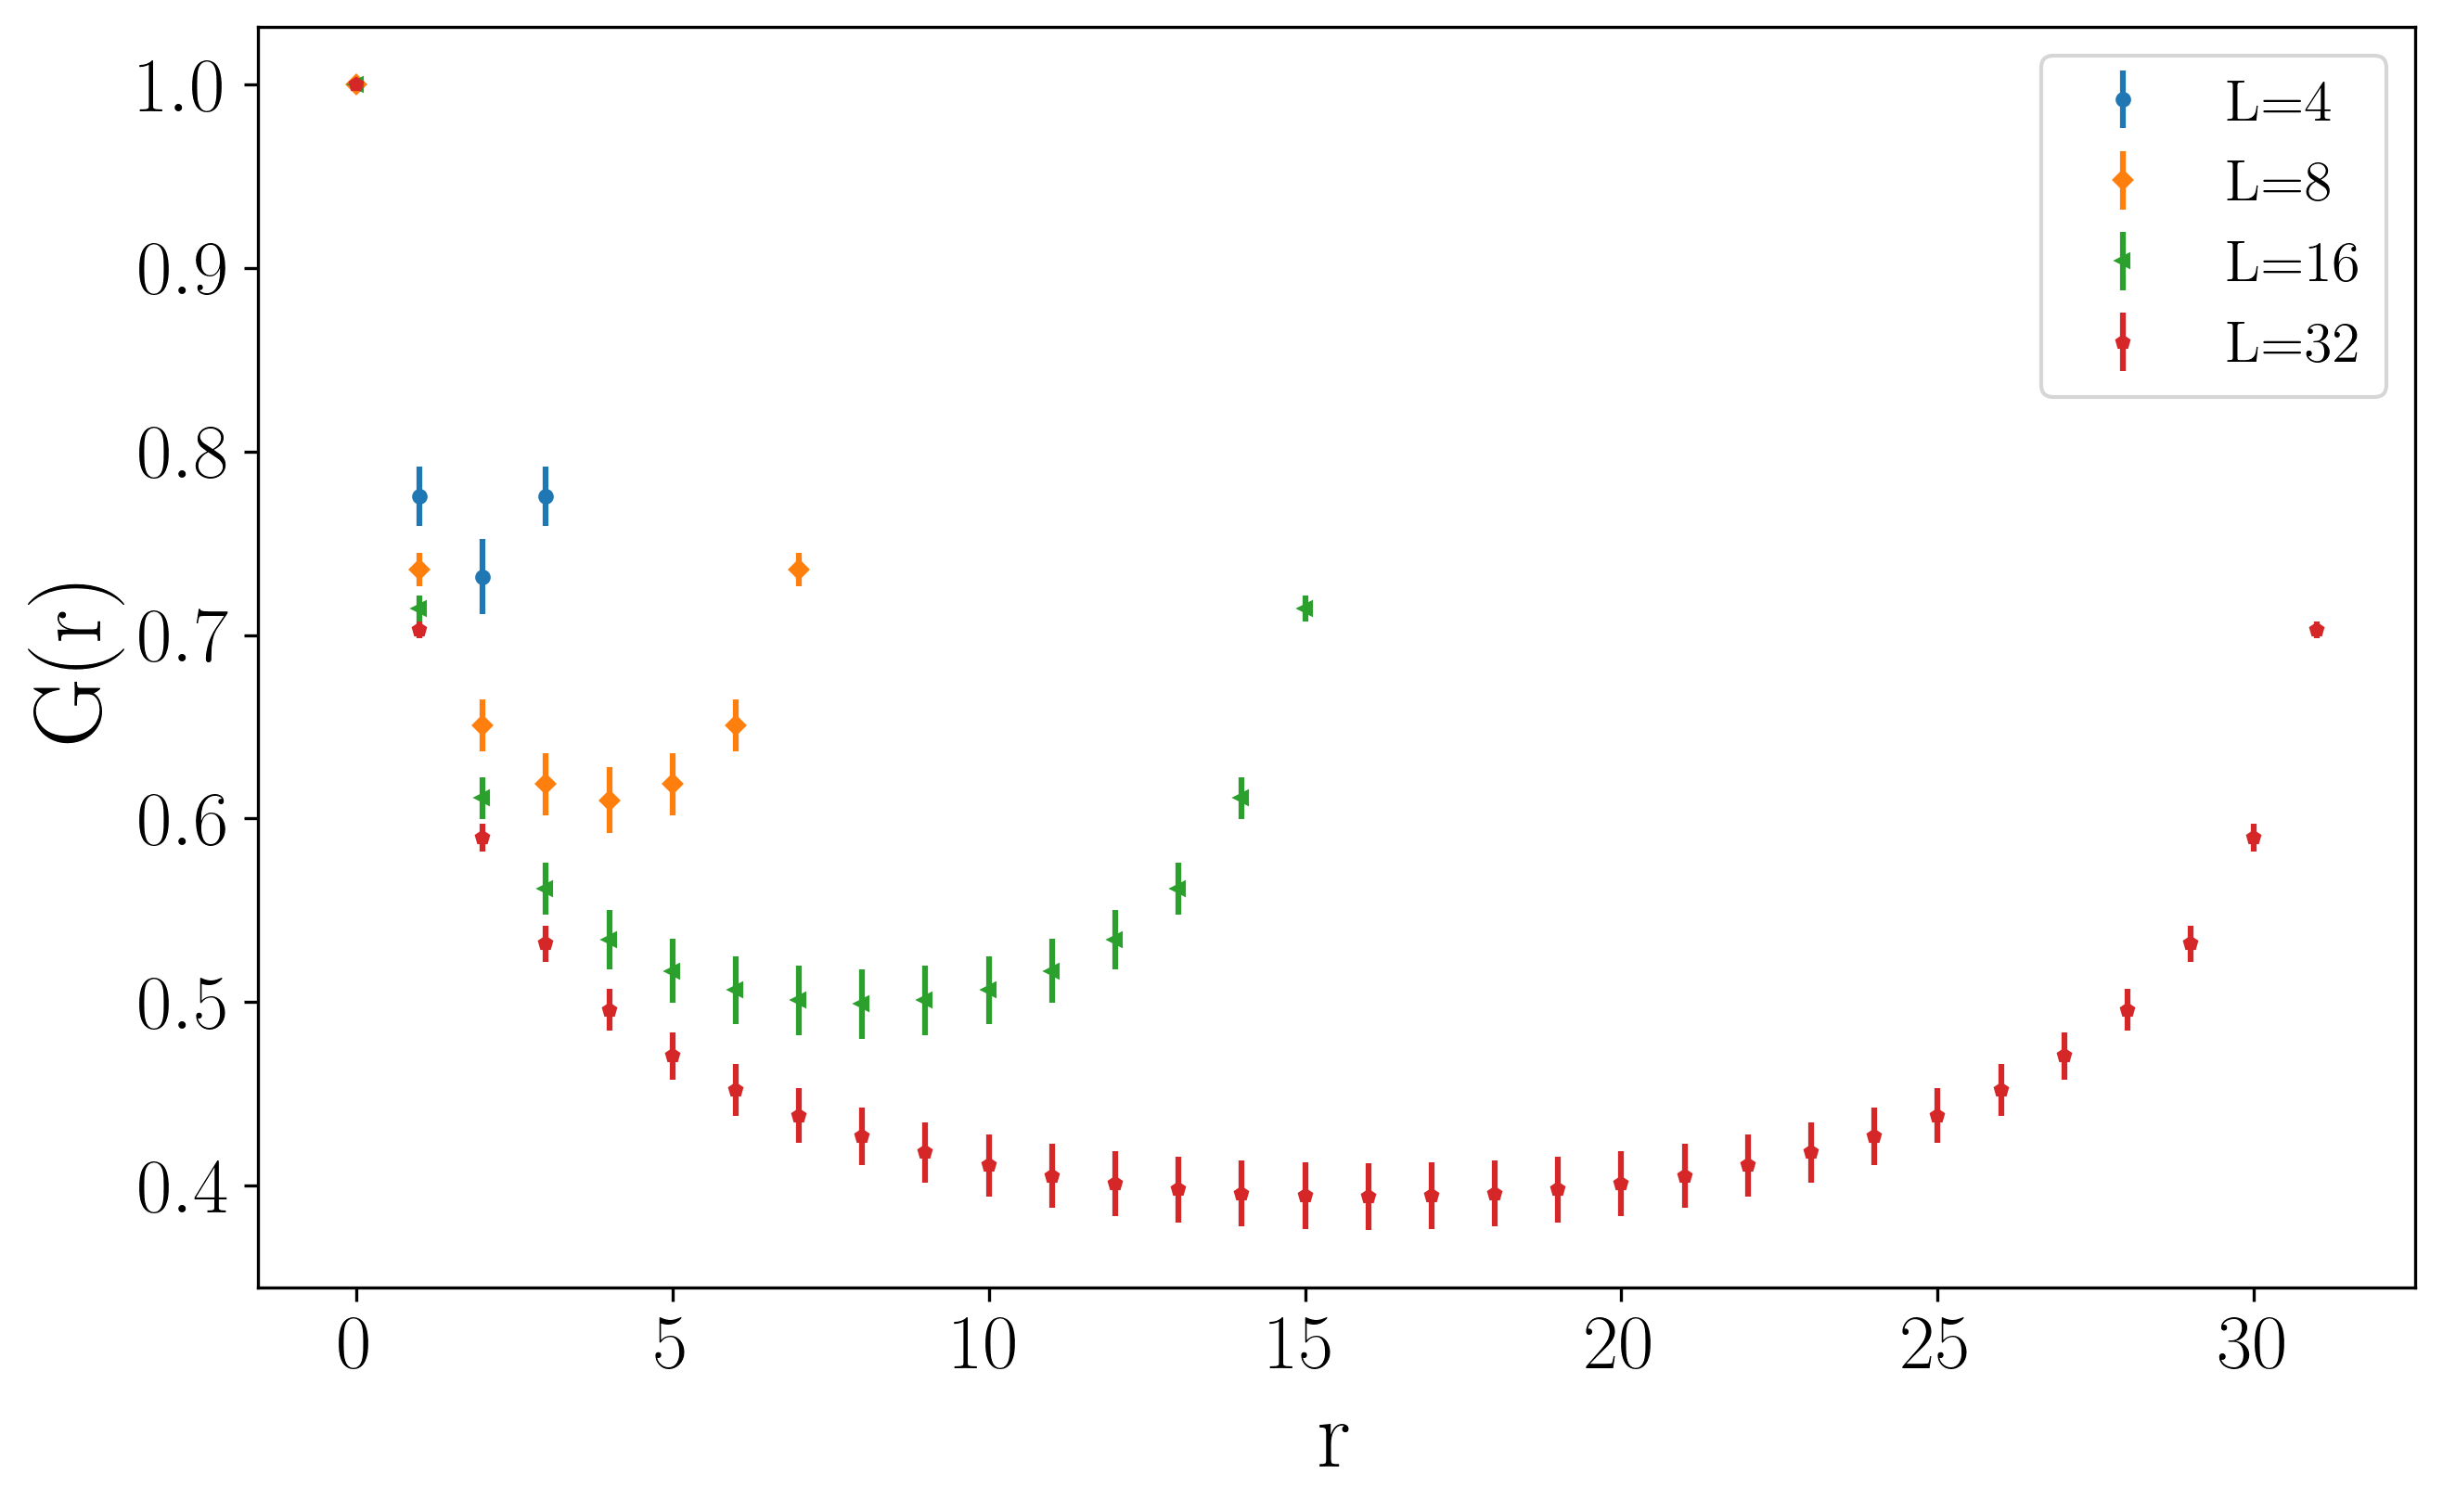

In [141]:
G_CORR_T2, G_CORR_STD_T2 = Q3([4,8,16,32], 100000, 2.285)

/var/folders/z0/r6zbkl914dl0h6jv5ktxb95h0000gn/T/ipykernel_29953/4268903730.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  G_CORR_T2=np.array([np.array(x) for x in G_CORR_T2])
/var/folders/z0/r6zbkl914dl0h6jv5ktxb95h0000gn/T/ipykernel_29953/4268903730.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  G_CORR_STD_T2=np.array([np.array(x) for x in G_CORR_STD_T2])


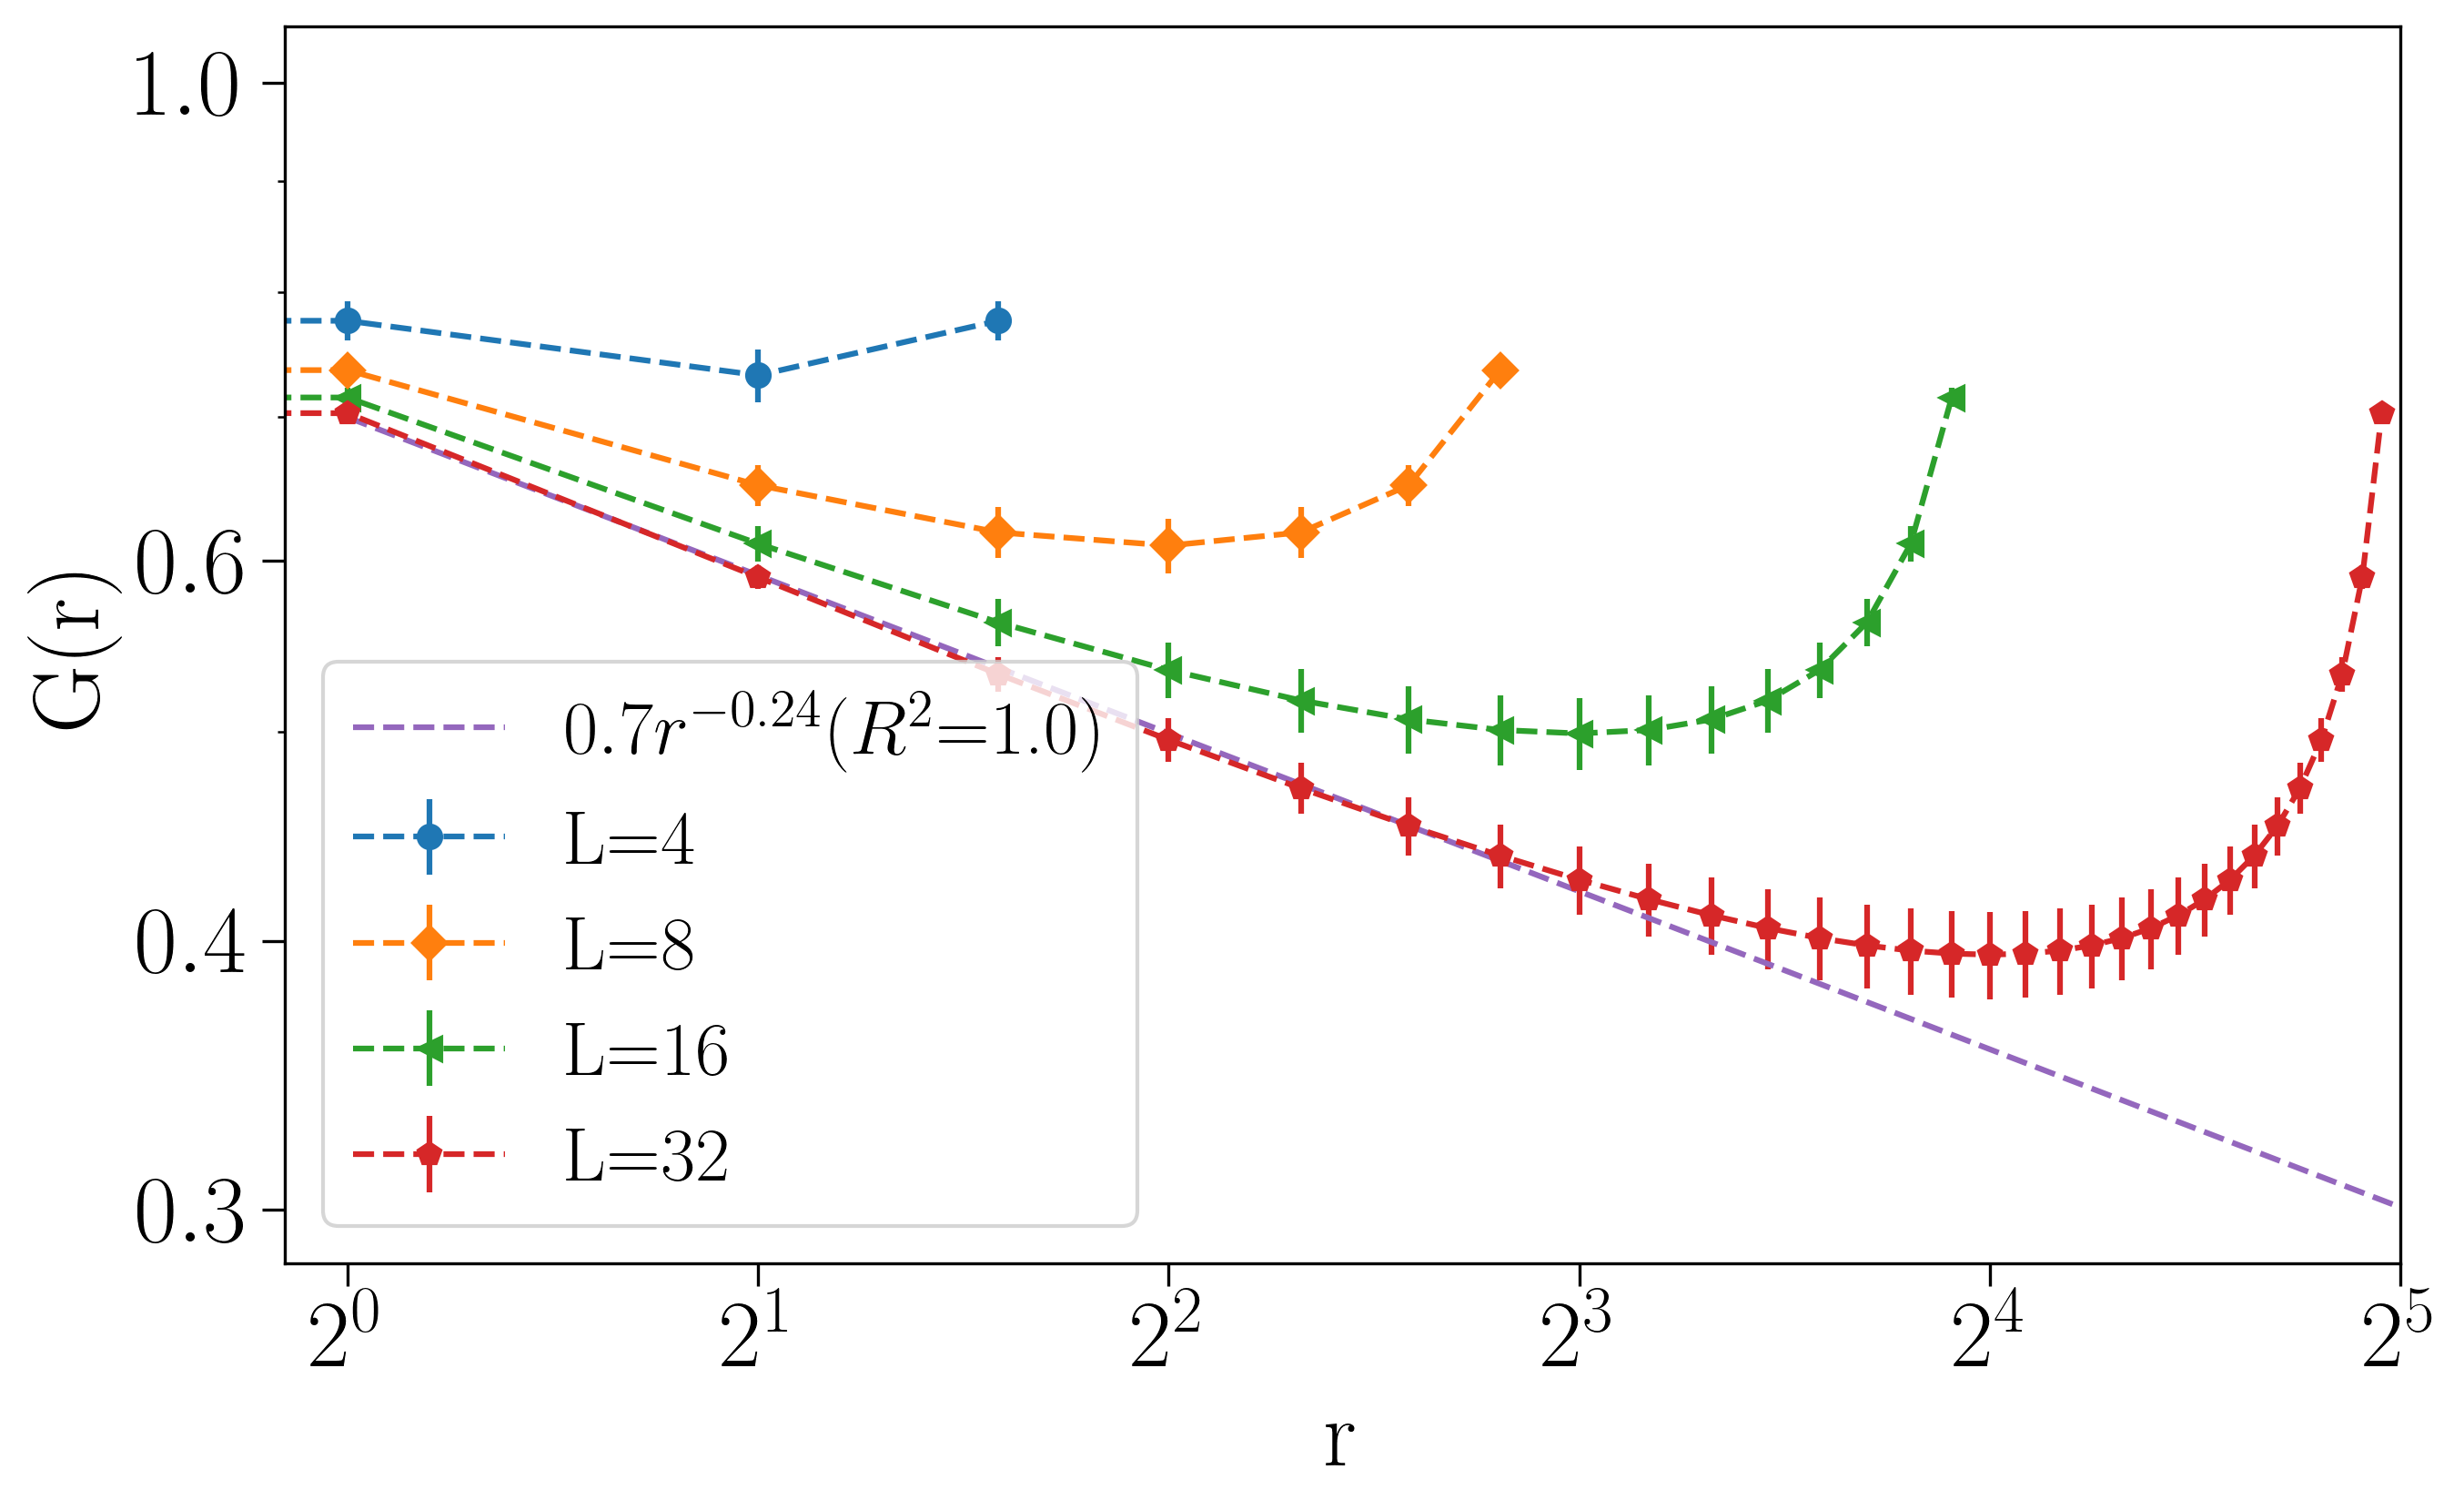

In [299]:
from scipy.optimize import curve_fit
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams['figure.dpi'] = 300
d=2
n=1/4
#L_list=[4,8,16,32]
L_list=[4,8,16,32]
#L_list=[10,20,50,100,200,400,1000]
G_CORR_T2=np.array([np.array(x) for x in G_CORR_T2])
G_CORR_STD_T2=np.array([np.array(x) for x in G_CORR_STD_T2])

#G_SW_log=[np.log(G_SW[i][1][:G_SW[i][1].argmin()]) for i in range(len(G_SW))]
#c, m = [ConjugateDescent(G_SW_log[i],np.arange(len(G_SW_log[i]))) for i in range(len(G_SW))]
#G_CORR_corrected_T2=G_CORR_T2[-1][1:G_CORR_T2[-1].argmin()-7]
G_CORR_corrected_T2=G_CORR_T2[-1][1:int(L_list[-1]/2)-7]
pars_T2, cov_T2 = curve_fit(power_law, np.arange(1,len(G_CORR_corrected_T2)+1), G_CORR_corrected_T2, p0=[0.5, -0.3])
residuals_T2 = G_CORR_corrected_T2- power_law(np.arange(1,len(G_CORR_corrected_T2)+1), *pars_T2)
ss_tot_T2 = np.sum((G_CORR_corrected_T2-np.mean(G_CORR_corrected_T2))**2)
ss_res_T2 = np.sum(residuals_T2**2)

r_squared_T2 = 1 - (ss_res_T2 / ss_tot_T2)
r = np.linspace(1,L_list[-1])
for i in range(len(L_list)):
    #plt.errorbar(list(range(L_list[i])[:G_CORR[i].argmin()]), G_CORR[i][:G_CORR[i].argmin()],G_CORR_STD[i][:G_CORR[i].argmin()],marker=markers[i], linestyle=' ',label=f"L={L_list[i]}")
    plt.errorbar(list(range(L_list[i])), G_CORR_T2[i],G_CORR_STD_T2[i],marker=markers[i], linestyle='dashed',label=f"L={L_list[i]}")
plt.plot(r, power_law(r, *pars_T2),linestyle = 'dashed', label = fr"${round(pars_T2[0],2)}r^{{{round(pars_T2[1],2)}}}$($R^2$={round(r_squared_T2,2)})")
#plt.plot(r, power_law(r, pars[0], -(d-2+n)),linestyle = 'dashed', label = f"{round(pars[0],2)}r^{round(-(d-2+n),2)}")
#plt.plot(r, power_law(r, 0.1, -(d-2+n)),linestyle = 'dashed', label = f"{round(0.1,2)}r^{round(-(d-2+n),2)}")
plt.xlabel("r", fontsize=25) 
plt.ylabel("G(r)", fontsize=25) 
# plt.title(f"T={2.285}", fontsize=25)
plt.yscale("log")
plt.xscale("log", base=2)
plt.yticks([0.3, 0.4, 0.6, 1])

from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
plt.gca().yaxis.set_major_formatter(formatter) 
plt.xlim(0.9,L_list[-1])
plt.legend()
plt.savefig('/Users/johnngan/Desktop/PHYS3999/images/G_r_2.pdf', bbox_inches='tight')
plt.show()

In [298]:
pars_T2[1]

-0.24348177589007294

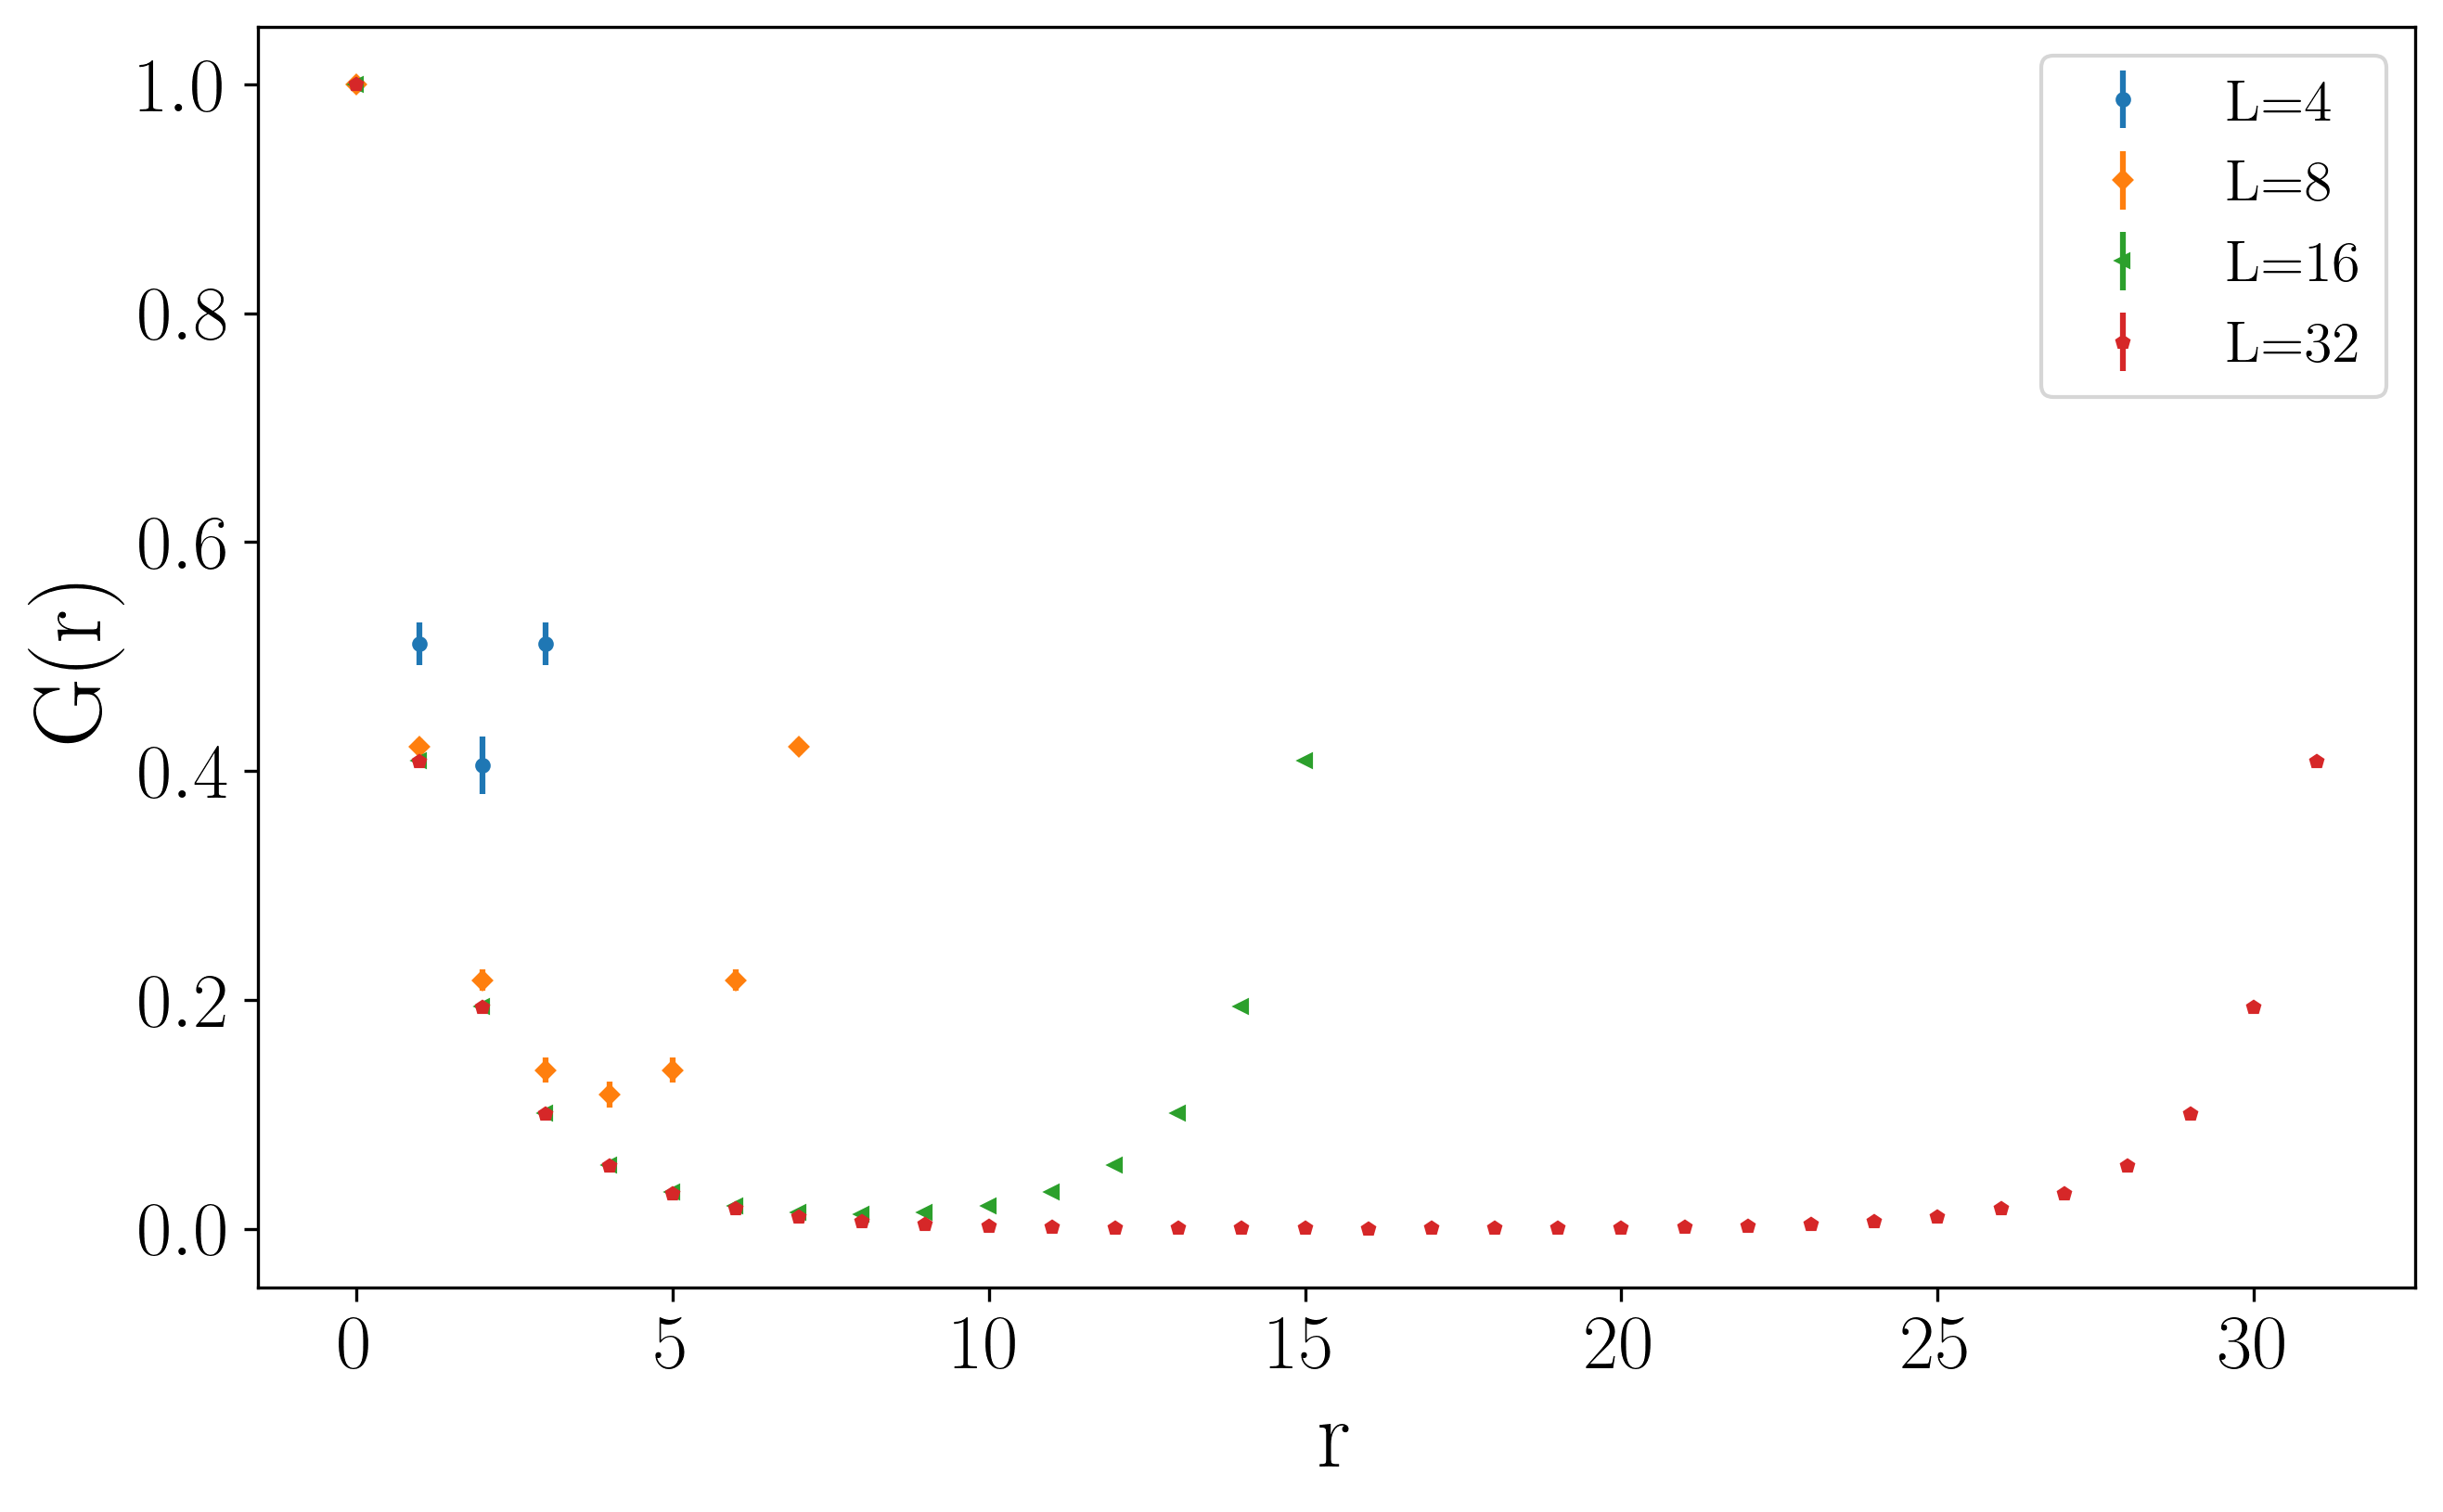

In [143]:
G_CORR_T3, G_CORR_STD_T3 = Q3([4,8,16,32], 100000, 3)

In [144]:
def expotential(x,a,b):
    return a*np.exp(-x/b)

/var/folders/z0/r6zbkl914dl0h6jv5ktxb95h0000gn/T/ipykernel_29953/2205623782.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  G_CORR_T3=np.array([np.array(x) for x in G_CORR_T3])
/var/folders/z0/r6zbkl914dl0h6jv5ktxb95h0000gn/T/ipykernel_29953/2205623782.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  G_CORR_STD_T3=np.array([np.array(x) for x in G_CORR_STD_T3])


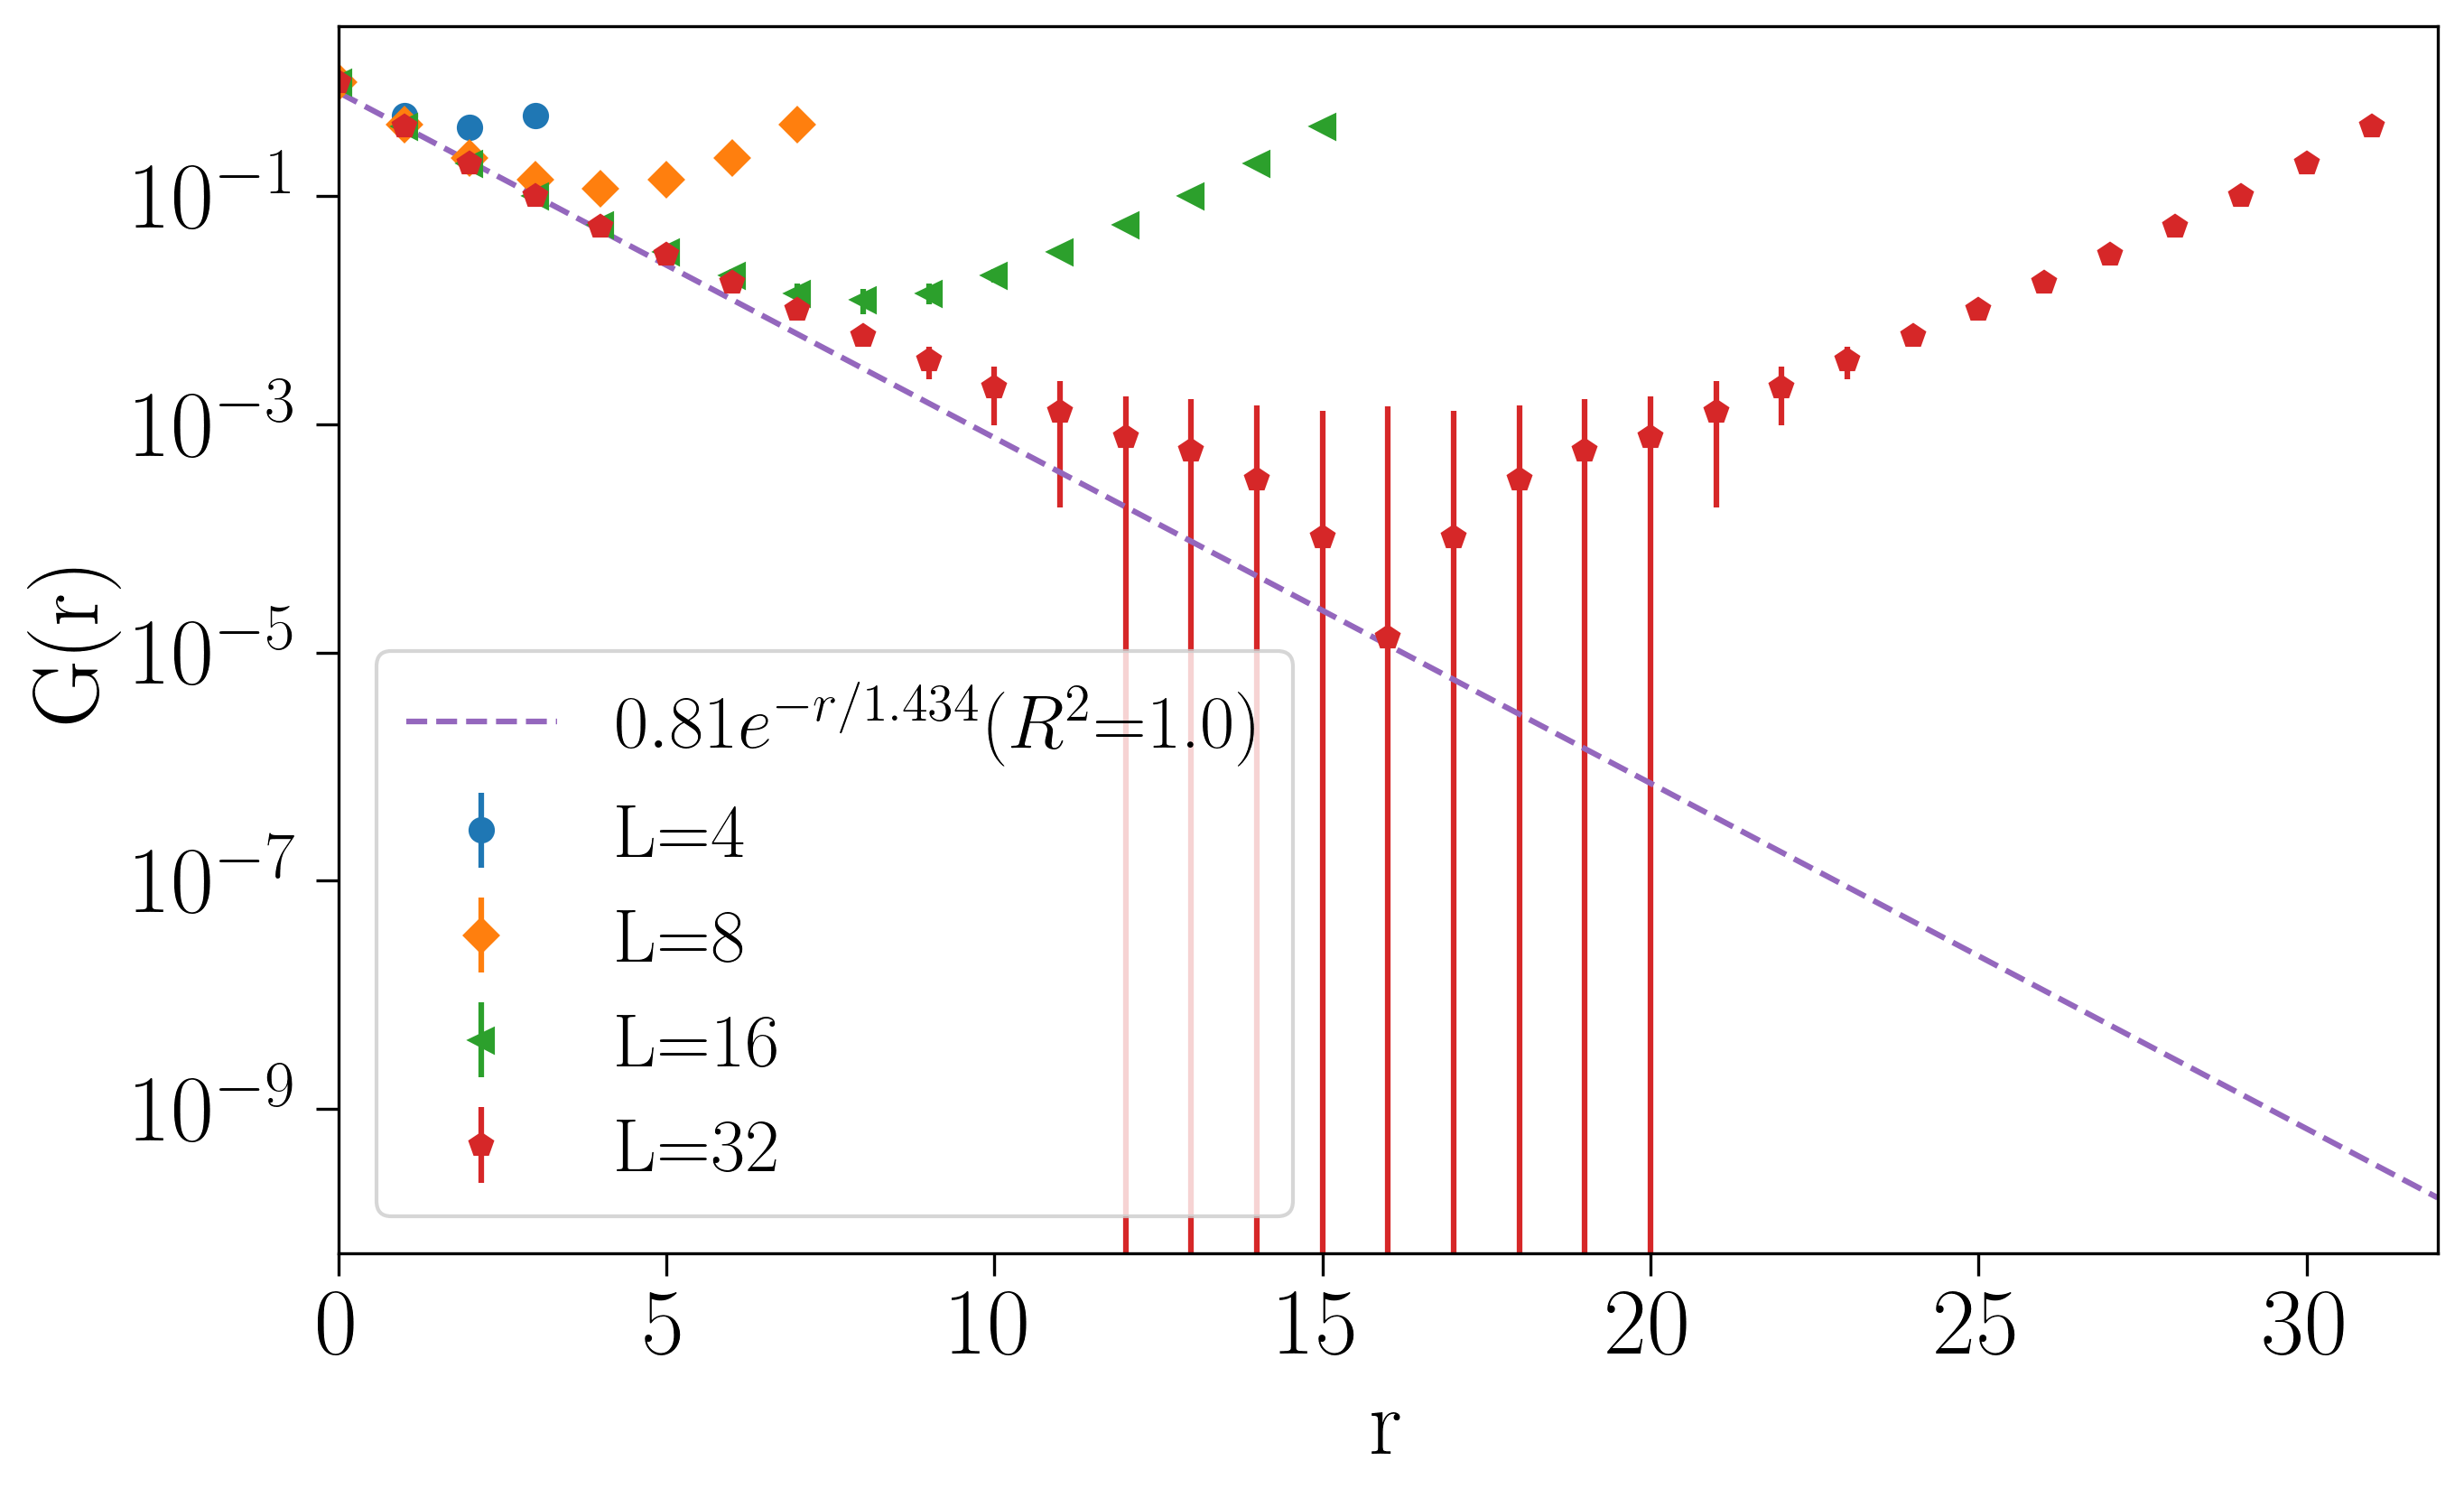

In [300]:
from scipy.optimize import curve_fit
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams['figure.dpi'] = 300
d=2
n=1/4
#L_list=[4,8,16,32]
L_list=[4,8,16,32]
#L_list=[10,20,50,100,200,400,1000]
G_CORR_T3=np.array([np.array(x) for x in G_CORR_T3])
G_CORR_STD_T3=np.array([np.array(x) for x in G_CORR_STD_T3])

#G_SW_log=[np.log(G_SW[i][1][:G_SW[i][1].argmin()]) for i in range(len(G_SW))]
#c, m = [ConjugateDescent(G_SW_log[i],np.arange(len(G_SW_log[i]))) for i in range(len(G_SW))]
#G_CORR_corrected=G_CORR[-1][1:G_CORR[-1].argmin()]
G_CORR_corrected_T3=G_CORR_T3[-1][1:int(L_list[-1]/2)-7]
pars_T3, cov_T3 = curve_fit(expotential, np.arange(1,len(G_CORR_corrected_T3)+1), G_CORR_corrected_T3)
residuals_T3 = G_CORR_corrected_T3- expotential(np.arange(1,len(G_CORR_corrected_T3)+1), *pars_T3)
ss_tot_T3 = np.sum((G_CORR_corrected_T3-np.mean(G_CORR_corrected_T3))**2)
ss_res_T3 = np.sum(residuals_T3**2)

r_squared_T3 = 1 - (ss_res_T3 / ss_tot_T3)
r = np.linspace(0,L_list[-1])
for i in range(len(L_list)):
    #plt.errorbar(list(range(L_list[i])[:G_CORR[i].argmin()]), G_CORR[i][:G_CORR[i].argmin()],G_CORR_STD[i][:G_CORR[i].argmin()],marker=markers[i], linestyle=' ',label=f"L={L_list[i]}")
    plt.errorbar(list(range(L_list[i])), G_CORR_T3[i],G_CORR_STD_T3[i],marker=markers[i], linestyle=' ',label=f"L={L_list[i]}")
plt.plot(r, expotential(r, *pars_T3),linestyle = 'dashed', label = fr"${round(pars_T3[0],2)}e^{{-r/{round(pars_T3[1],3)}}}$($R^2$={round(r_squared_T3,2)})")
#plt.plot(r, power_law(r, pars[0], -(d-2+n)),linestyle = 'dashed', label = f"{round(pars[0],2)}r^{round(-(d-2+n),2)}")
#plt.plot(r, power_law(r, 0.1, -(d-2+n)),linestyle = 'dashed', label = f"{round(0.1,2)}r^{round(-(d-2+n),2)}")
plt.xlabel("r", fontsize=25) 
plt.ylabel("G(r)", fontsize=25) 
# plt.title(f"T={3}", fontsize=25)
plt.yscale("log")
#plt.xscale("log")
plt.xlim(0,L_list[-1])
plt.legend()
plt.savefig('/Users/johnngan/Desktop/PHYS3999/images/G_r_3.pdf', bbox_inches='tight')
plt.show()

# Binder ratio

In [81]:
def Q4(L_list,Mcstep,tmax,tmin,tp):
    
    #iterations until it reaches equilibrium state
    Equstep = 1000
    #temperature
    T = np.linspace(tmin,tmax,tp)
    
    #setting up lists
    m_abs_expect_L = []
    m_sq_expect_L = []
    m_abs_std_L = []
    m_sq_std_L = []  
    
    #for each lattice size
    for L in L_list:
        #record start time of the loop
        start_time = time.time()
        
        #size of the configuration
        N = L*L
    
        #reset lists
        m_abs_expect_tp = []
        m_sq_expect_tp = []
        m_abs_std_tp = []
        m_sq_std_tp = []

        #for each temerature point
        for i in range(tp):
            #reset lists
            m_abs_expect = []
            m_sq_expect = []

            Config = lattice(L)  

            for j in range(Equstep):         
                MC = SwendsenWang(Config,L,T[i])

            #setting up lists
            m_list = []

            #perform Swendsen-Wang algorithm to collect data
            for k in range(Mcstep):
                MC = SwendsenWang(Config,L,T[i])
                #Magnitization m
                m_list.append(Magnetization(MC,L))

                #binning
                if k%(Mcstep/100) ==0 and k!=0:         
                    #<|m|> per bin
                    m_abs_expect.append(np.mean([abs(i) for i in m_list]))
                    #<m^2> per bin
                    m_sq_expect.append(np.mean([i**2 for i in m_list]))

                    #reset the list
                    m_list = []

            #<|m|> per temperature point
            m_abs_expect_tp.append(np.mean(m_abs_expect))
            #<m^2> per temperature point
            m_sq_expect_tp.append(np.mean(m_sq_expect))

            #standard deviation of |m| per temperature point
            m_abs_std_tp.append(np.std(m_abs_expect, ddof = 1))
            #standard deviation of m^2 per temperature point
            m_sq_std_tp.append(np.std(m_sq_expect, ddof = 1))
            
            #check progress
            if (i+1)%10 == 0 and i!=0:
                print(str(i+1)+" temperature points finished")

        #<|m|> per L
        m_abs_expect_L.append(m_abs_expect_tp)
        #<m^2> per L
        m_sq_expect_L.append(m_sq_expect_tp)

        #standard deviation of |m| per L
        m_abs_std_L.append(m_abs_std_tp)
        #standard deviation of m^2 per L
        m_sq_std_L.append(m_sq_std_tp)
        
        #time used for the loop for each L
        print("computing time for L="+str(L)+": %s seconds" % (time.time() - start_time))

    return m_abs_expect_L, m_sq_expect_L, m_abs_std_L, m_sq_std_L

In [99]:
M_ABS_SW,M_SQ_SW,M_ABS_STD_SW,M_SQ_STD_SW=Q4([4,8,16,32],100000,3.5,1.5,20)

10 temperature points finished
20 temperature points finished
computing time for L=4: 106.30590295791626 seconds
10 temperature points finished
20 temperature points finished
computing time for L=8: 228.29049396514893 seconds
10 temperature points finished
20 temperature points finished
computing time for L=16: 730.4016010761261 seconds
10 temperature points finished
20 temperature points finished
computing time for L=32: 2740.4984838962555 seconds


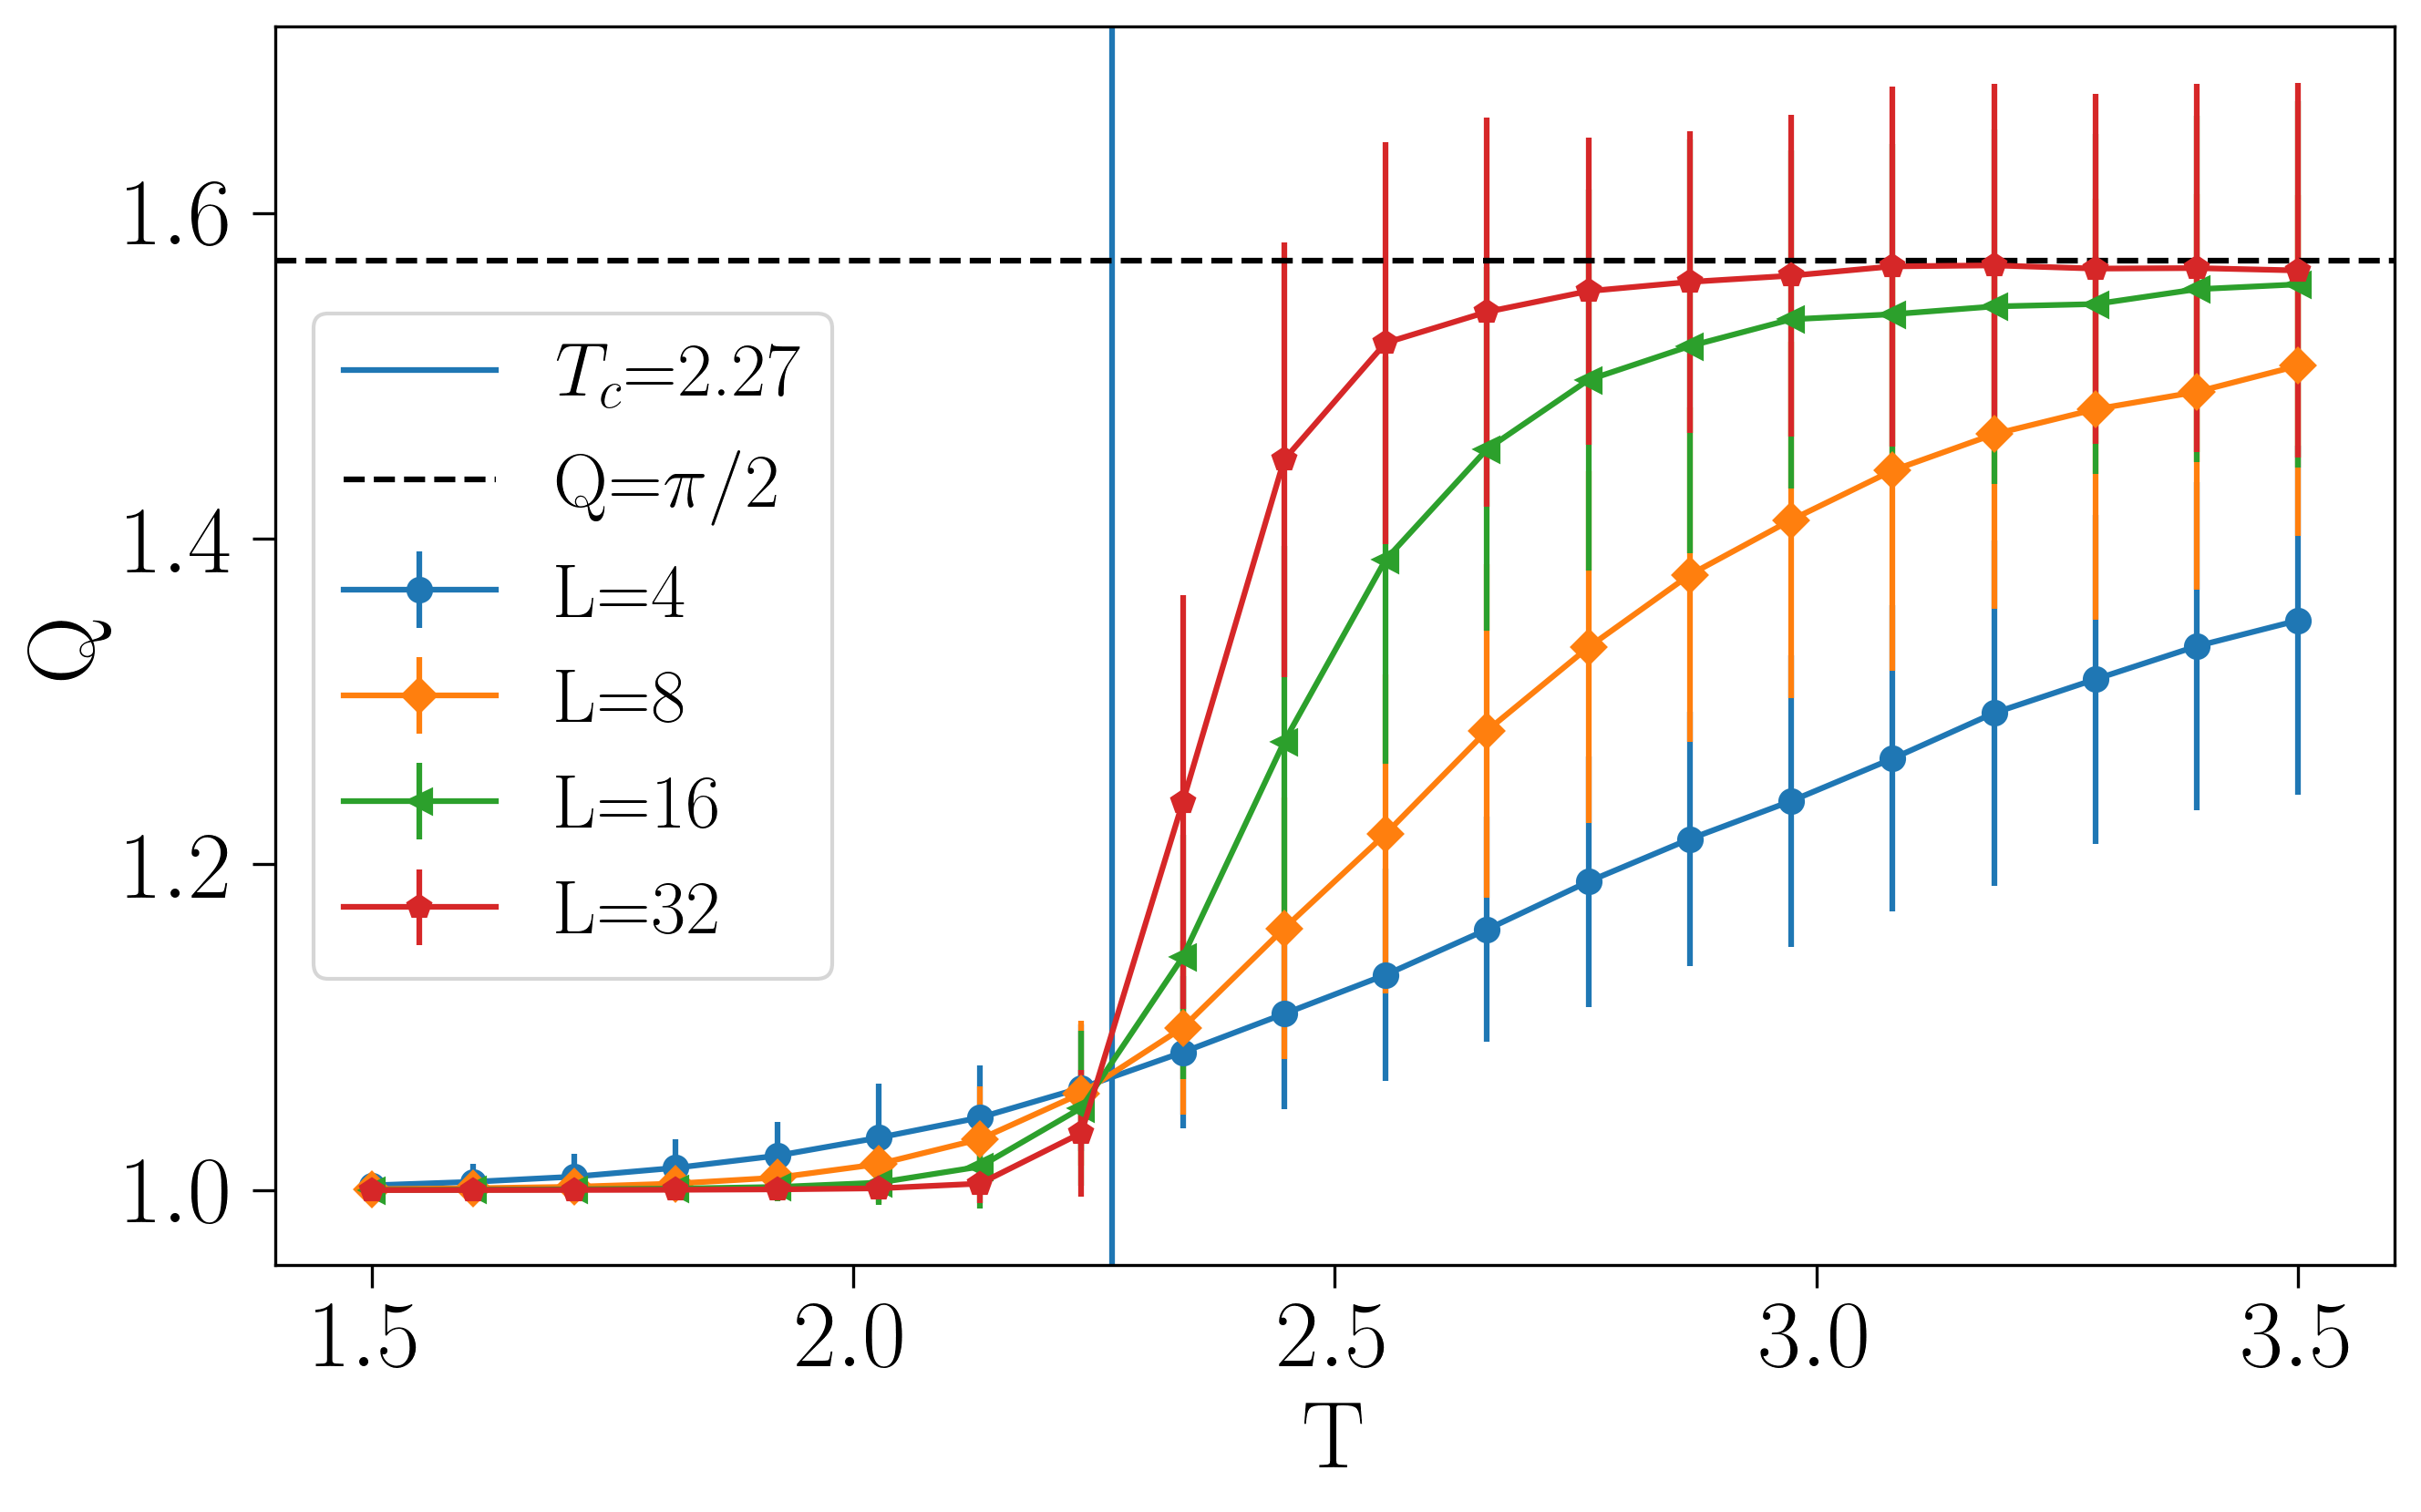

In [285]:
T = np.linspace(1.5,3.5,20)
M_ABS = np.array(M_ABS_SW)
M_SQ = np.array(M_SQ_SW)
M_ABS_STD = np.array(M_ABS_STD_SW)
M_SQ_STD = np.array(M_SQ_STD_SW)
Q = M_SQ/M_ABS**2
Q_STD = np.sqrt((M_SQ_STD/(M_ABS**2))**2 + (2*M_SQ*M_ABS_STD/(M_ABS**3))**2)
for i in range(len(L_list)):
    plt.errorbar(T, Q[i],yerr = Q_STD[i],marker=markers[i], linestyle='-',label="L="+str(L_list[i]))
    #plt.plot(T, Q[i],marker=markers[i], linestyle='-',label="L="+str(L_list[i]))
plt.axvline(x=2.269, label = r"$T_c$=2.27")
plt.axhline(y=np.pi/2,c='black',linestyle='dashed', label = r"Q=$\pi/2$")
plt.xlabel("T", fontsize=25) 
plt.ylabel("Q", fontsize=25)   
# plt.title("Binder ratio", fontsize=25)
plt.legend()
plt.savefig('/Users/johnngan/Desktop/PHYS3999/images/Q_T.pdf', bbox_inches='tight')
plt.show()

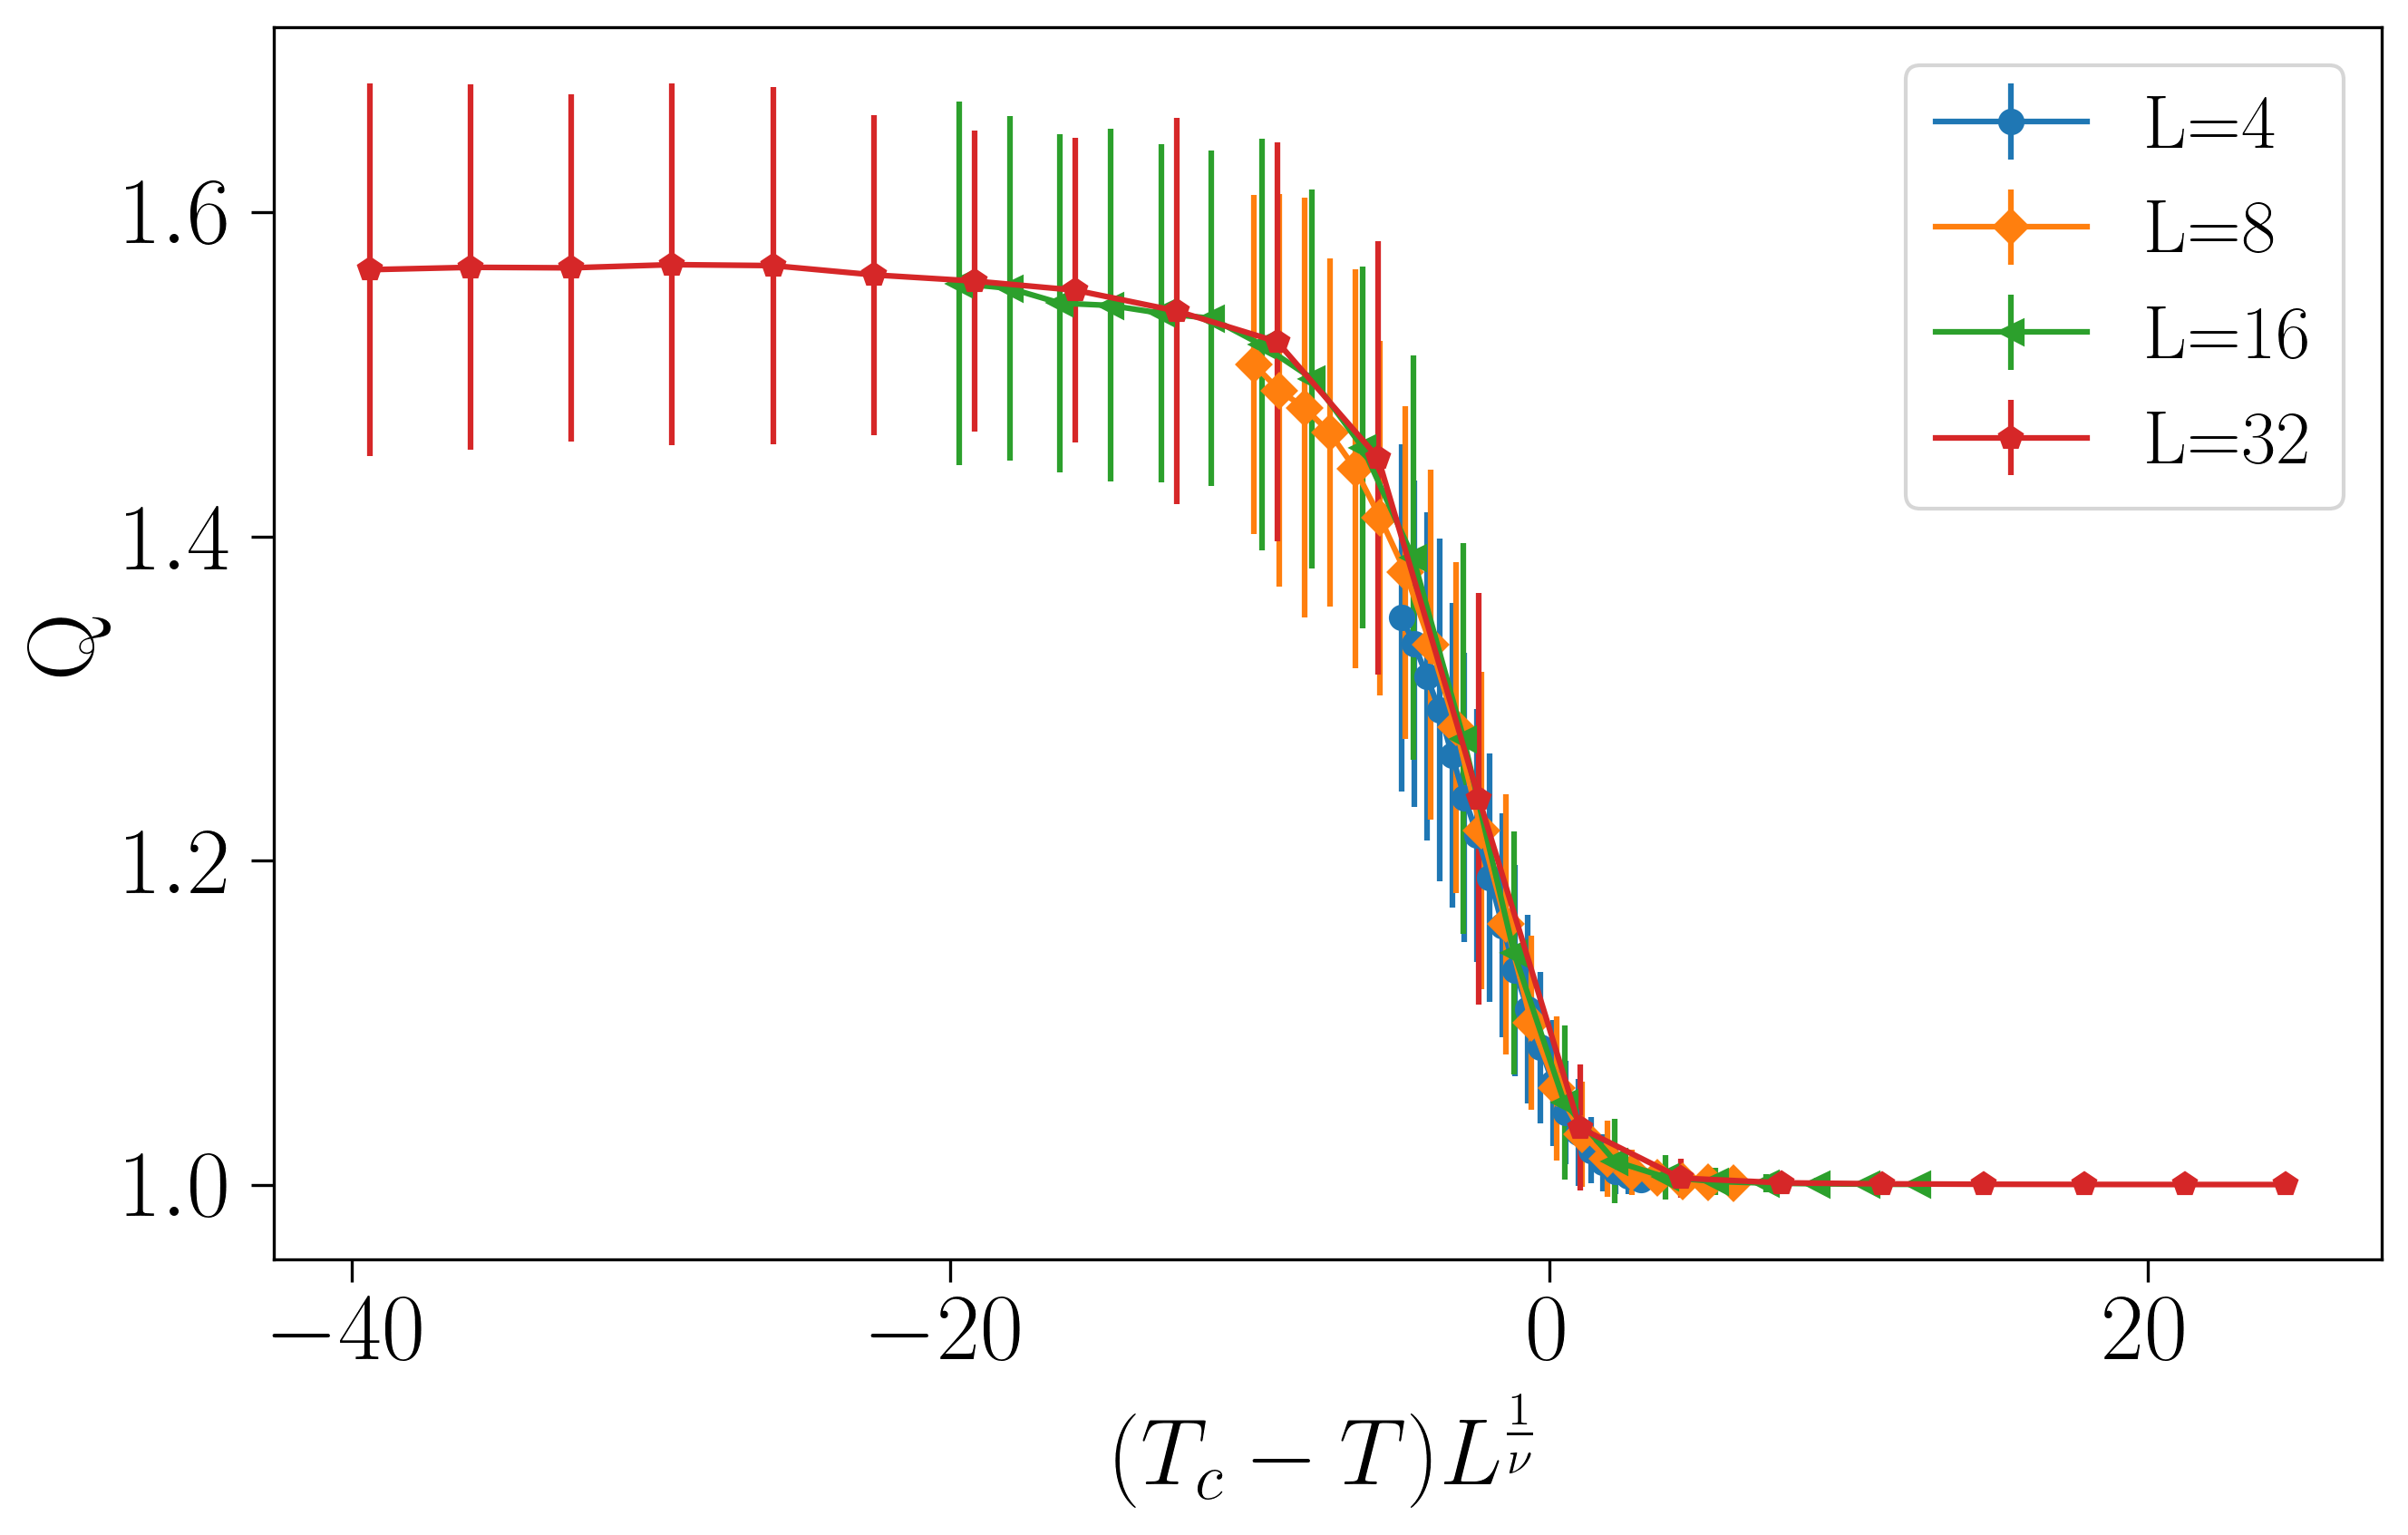

In [287]:
v=1
for i in range(len(L_list)):
    plt.errorbar((2.269-T)*(L[i]**(1/v)), Q[i],yerr = Q_STD[i],marker=markers[i], linestyle='-',label="L="+str(L_list[i]))
    #plt.plot(T, Q[i],marker=markers[i], linestyle='-',label="L="+str(L_list[i]))
# plt.axvline(x=2.269, label = r"$T_c$=2.27")
plt.xlabel(r"$(T_c-T) L^{\frac{1}{\nu}}$", fontsize=25) 
plt.ylabel("Q", fontsize=25)   
# plt.title("Binder ratio", fontsize=25)
plt.legend()
plt.savefig('/Users/johnngan/Desktop/PHYS3999/images/Q_tL.pdf', bbox_inches='tight')
plt.show()

In [103]:
L_TC=[4,8,16,32]
M_ABS_TC,M_SQ_TC,M_ABS_STD_TC,M_SQ_ABS_TC = Q4(L_TC,100000,2.3,2.25,21)

10 temperature points finished
20 temperature points finished
computing time for L=4: 100.21006798744202 seconds
10 temperature points finished
20 temperature points finished
computing time for L=8: 226.99536395072937 seconds
10 temperature points finished
20 temperature points finished
computing time for L=16: 718.236517906189 seconds
10 temperature points finished
20 temperature points finished
computing time for L=32: 2709.499664783478 seconds


In [105]:
M_SQ_STD_TC=M_SQ_ABS_TC

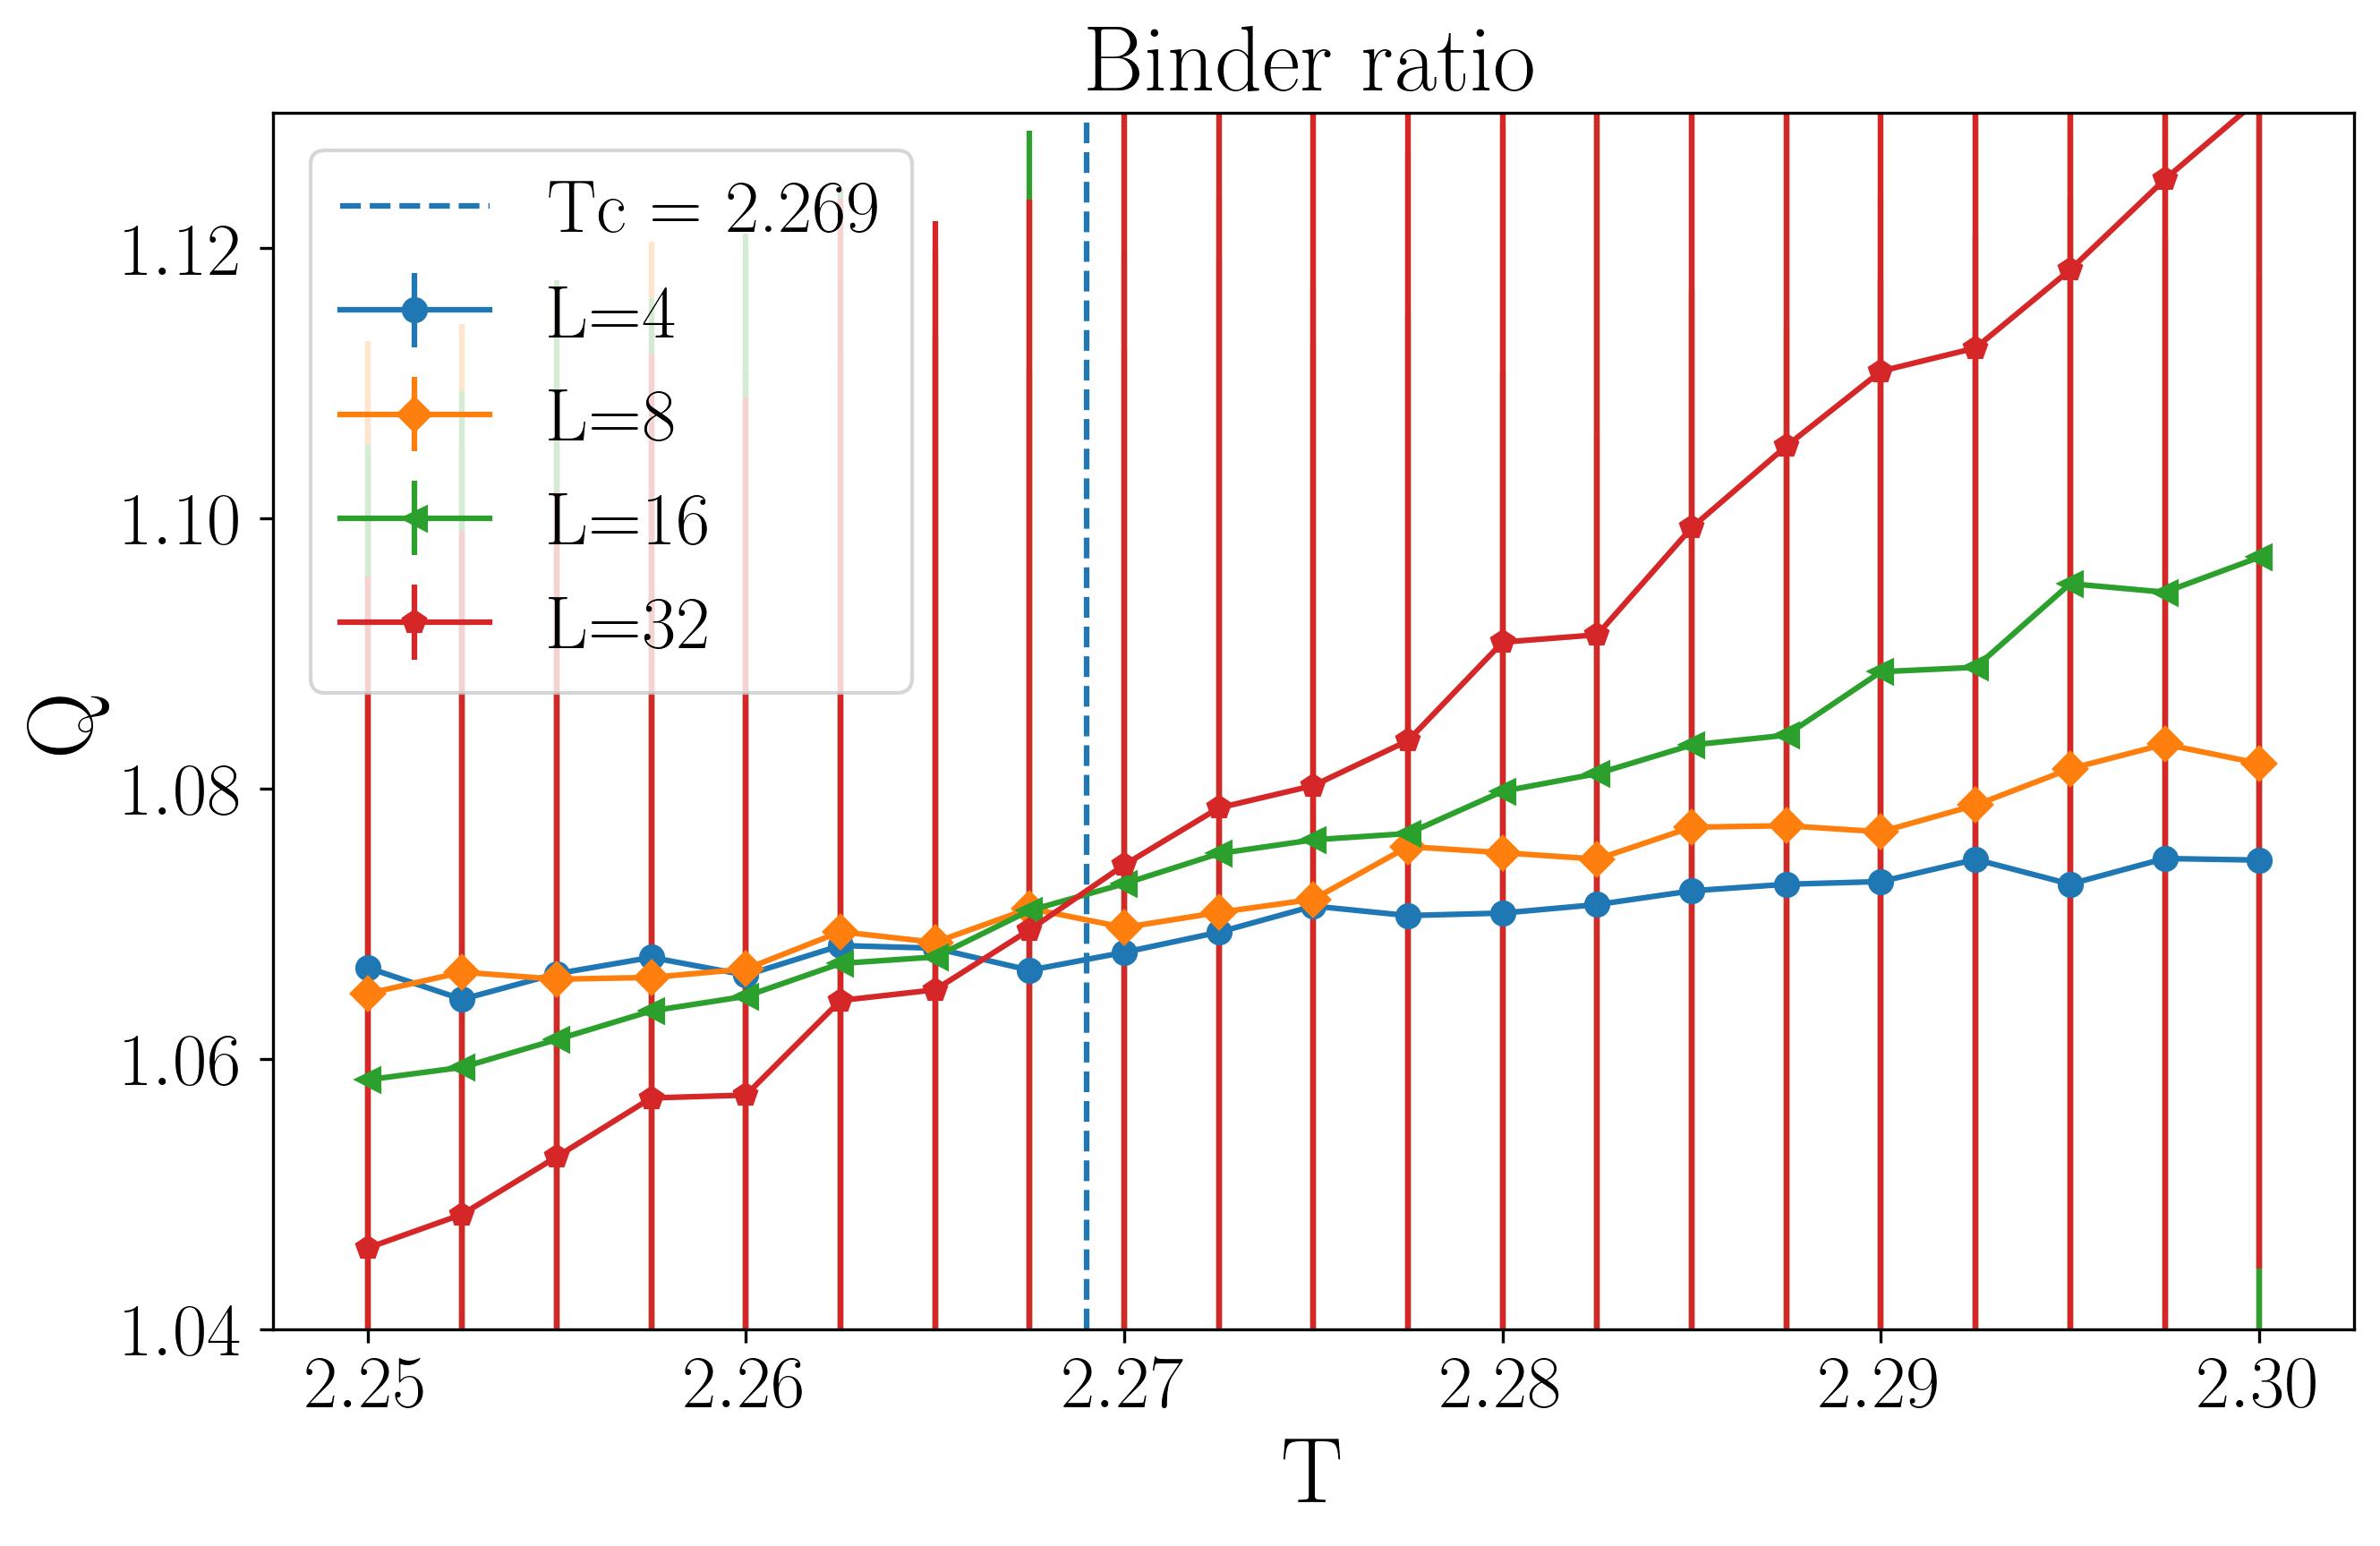

In [223]:
#iterations until it reaches equilibrium state
Equstep = 1000
#maximum temperature
tmax = 2.30
#minimum temperature
tmin = 2.25
#number of temperature points
tp = 21
#temperature
T_TC = np.linspace(tmin,tmax,tp)

M_ABS_TC = np.array(M_ABS_TC)
M_SQ_TC = np.array(M_SQ_TC)
M_ABS_STD_TC = np.array(M_ABS_STD_TC)
M_SQ_STD_TC = np.array(M_SQ_STD_TC)
Q = M_SQ_TC/M_ABS_TC**2
Q_STD_TC = np.sqrt((M_SQ_STD_TC/(M_ABS_TC**2))**2 + (2*M_SQ_TC*M_ABS_STD_TC/(M_ABS_TC**3))**2)
for i in range(len(L_TC)):
    plt.errorbar(T_TC, Q[i],yerr = Q_STD_TC[i],marker=markers[i], linestyle='-',label="L="+str(L_list[i]))
    #plt.plot(T, Q[i],marker=markers[i], linestyle='-',label="L="+str(L_list[i]))
plt.axvline(x=2.269, linestyle='dashed', label = fr"$T_c$ = {2.269}")
plt.xlabel("T", fontsize=25) 
plt.ylabel("Q", fontsize=25)   
plt.title("Binder ratio", fontsize=25)
plt.ylim(1.04,1.13)
plt.legend()
plt.savefig('/Users/johnngan/Desktop/PHYS3999/images/Q_TC.pdf', bbox_inches='tight')
plt.show()